# Î≥ÄÎèôÏÑ± ÎèåÌåå + ADX/Chaikin + Ï†àÎåÄÎ™®Î©òÌÖÄ + Î≥ÄÎèôÏÑ± ÌïÑÌÑ∞ Ï†ÑÎûµ

Í∏∞Ï°¥ ADX/Chaikin Ï†ÑÎûµÏóê Ï∂îÍ∞Ä ÌïÑÌÑ∞Î•º Ï†ÅÏö©ÌïòÏó¨ Í±∞Îûò ÎπàÎèÑÎ•º ÎåÄÌè≠ Í∞êÏÜå
- Í∏∞Ï°¥: Î≥ÄÎèôÏÑ± ÎèåÌåå + (ADX Í∞ïÏÑ∏ OR Chaikin Í∞ïÏÑ∏)
- Ï∂îÍ∞Ä: Ï†àÎåÄ Î™®Î©òÌÖÄ ÌïÑÌÑ∞ (20Ïùº ÏàòÏùµÎ•† > 0)
- Ï∂îÍ∞Ä: Î≥ÄÎèôÏÑ± ÌïÑÌÑ∞ (ATR ÏÉÅÏäπ ÎòêÎäî Range ÌôïÎåÄ)

## 1. ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ Î∞è ÌôòÍ≤Ω ÏÑ§Ï†ï

In [709]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# matplotlib ÌïúÍ∏Ä ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. BigQuery Ïó∞Í≤∞ Î∞è ADX/Chaikin Ìè¨Ìï® Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò

In [710]:
# BigQuery ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏ Ï¥àÍ∏∞Ìôî
def get_bigquery_client():
    service_account_path = "/Users/cg01-piwoo/my_quant/access_info/data/quantsungyong-663604552de9.json"
    credentials = service_account.Credentials.from_service_account_file(
        service_account_path,
        scopes=["https://www.googleapis.com/auth/cloud-platform"]
    )
    return bigquery.Client(credentials=credentials, project=credentials.project_id)

client = get_bigquery_client()


# ADXÏôÄ Chaikin ÏßÄÌëúÎ•º Ìè¨Ìï®Ìïú Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò
def get_stock_data_with_indicators(ticker, start_date=None, end_date=None):
    date_conditions = []
    if start_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') >= '{start_date}'")
    if end_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') <= '{end_date}'")
    
    date_filter = f"AND {' AND '.join(date_conditions)}" if date_conditions else ""
    
    query = f"""
    WITH raw_data AS (
      SELECT 
        ticker,
        -- Í∞ÄÍ≤© Îç∞Ïù¥ÌÑ∞
        JSON_EXTRACT_ARRAY(data, '$.dates') AS dates_array,
        JSON_EXTRACT_ARRAY(data, '$.open') AS open_array,
        JSON_EXTRACT_ARRAY(data, '$.high') AS high_array,
        JSON_EXTRACT_ARRAY(data, '$.low') AS low_array,
        JSON_EXTRACT_ARRAY(data, '$.close') AS close_array,
        JSON_EXTRACT_ARRAY(data, '$.volume') AS volume_array,
        
        -- ADX Í¥ÄÎ†® ÏßÄÌëú
        JSON_EXTRACT_ARRAY(data, '$.adx_14_values') AS adx_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.pdi_14_values') AS pdi_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.mdi_14_values') AS mdi_14_values_array,
        
        -- Chaikin Oscillator Í¥ÄÎ†® ÏßÄÌëú (ÏàòÏ†ïÎêú ÌïÑÎìúÎ™Ö)
        JSON_EXTRACT_ARRAY(data, '$.chaikin_oscillator') AS chaikin_oscillator_array,
        JSON_EXTRACT_ARRAY(data, '$.chaikin_9_signal_line') AS chaikin_signal_array,

        -- MACD Í¥ÄÎ†®
        JSON_EXTRACT_ARRAY(data, '$.macd_line') AS macd_line_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_9_signal_line') AS macd_9_signal_line_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_histogram') AS macd_histogram_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_signals') AS macd_signals_array,
        
        -- Stochastic
        JSON_EXTRACT_ARRAY(data, '$.stochastic_k_line') AS stochastic_k_line_array,
        JSON_EXTRACT_ARRAY(data, '$.stochastic_d_line') AS stochastic_d_line_array,
        
        -- OBV Í¥ÄÎ†®
        JSON_EXTRACT_ARRAY(data, '$.obv_values') AS obv_values_array,
        JSON_EXTRACT_ARRAY(data, '$.obv_9_ma') AS obv_9_ma_array,
        JSON_EXTRACT_ARRAY(data, '$.obv_signals') AS obv_signals_array,

        -- RSI Í¥ÄÎ†®
        JSON_EXTRACT_ARRAY(data, '$.rsi_14_values') AS rsi_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_9_signal_line') AS rsi_9_signal_line_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_histogram') AS rsi_histogram_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_signals') AS rsi_signals_array,
              
        -- ATR Í¥ÄÎ†® ÏßÄÌëú
        JSON_EXTRACT_ARRAY(data, '$.atr') AS atr_array,

        -- Î∞∞Ïó¥ Í∏∏Ïù¥
        ARRAY_LENGTH(JSON_EXTRACT_ARRAY(data, '$.close')) AS array_length
        
      FROM 
        `quantsungyong.finviz_data.stock_data_with_indicators`
      WHERE 
        ticker = '{ticker}'
    ),
    indices AS (
      SELECT r.ticker, pos
      FROM raw_data r,
      UNNEST(GENERATE_ARRAY(0, r.array_length - 1)) AS pos
    )
    SELECT 
      -- ÎÇ†ÏßúÏôÄ Í∞ÄÍ≤© Îç∞Ïù¥ÌÑ∞
      JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') AS date,
      CAST(JSON_EXTRACT_SCALAR(r.open_array[OFFSET(i.pos)], '$') AS FLOAT64) AS open,
      CAST(JSON_EXTRACT_SCALAR(r.high_array[OFFSET(i.pos)], '$') AS FLOAT64) AS high,
      CAST(JSON_EXTRACT_SCALAR(r.low_array[OFFSET(i.pos)], '$') AS FLOAT64) AS low,
      CAST(JSON_EXTRACT_SCALAR(r.close_array[OFFSET(i.pos)], '$') AS FLOAT64) AS close,
      CAST(JSON_EXTRACT_SCALAR(r.volume_array[OFFSET(i.pos)], '$') AS INT64) AS volume,
      
      -- RSI Í¥ÄÎ†®
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.rsi_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS rsi_signals,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.macd_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS macd_signals,
      
      
      -- ATR Í¥ÄÎ†® ÏßÄÌëú
      CASE 
        WHEN ARRAY_LENGTH(r.atr_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.atr_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS atr,
      -- ADX Í¥ÄÎ†® ÏßÄÌëú
      CASE 
        WHEN ARRAY_LENGTH(r.adx_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.adx_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS adx_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.pdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.pdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS pdi_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.mdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.mdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS mdi_14,
      
      -- Chaikin Oscillator (ÏàòÏ†ïÎêú ÌïÑÎìúÎ™Ö)
      CASE 
        WHEN ARRAY_LENGTH(r.chaikin_oscillator_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.chaikin_oscillator_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS chaikin_oscillator,
      
      CASE 
        WHEN ARRAY_LENGTH(r.chaikin_signal_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.chaikin_signal_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS chaikin_signal,

      -- Stochastic
      CASE 
        WHEN ARRAY_LENGTH(r.stochastic_k_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.stochastic_k_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS stochastic_k_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.stochastic_d_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.stochastic_d_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS stochastic_d_line,

      -- MACD Í¥ÄÎ†®
      CASE 
        WHEN ARRAY_LENGTH(r.macd_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.macd_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS macd_signals,
      
      -- OBV Í¥ÄÎ†®
      CASE 
        WHEN ARRAY_LENGTH(r.obv_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.obv_values_array[OFFSET(i.pos)], '$') AS INT64)
        ELSE NULL 
      END AS obv_values,
      
      CASE 
        WHEN ARRAY_LENGTH(r.obv_9_ma_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.obv_9_ma_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS obv_9_ma,
      
      CASE 
        WHEN ARRAY_LENGTH(r.obv_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.obv_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS obv_signals

    FROM raw_data r
    CROSS JOIN indices i
    WHERE i.ticker = r.ticker {date_filter}
    ORDER BY date DESC
    """
    
    try:
        df = client.query(query).to_dataframe()
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        # ChaikinÏùò Ï†ÑÏùº Í∞í Í≥ÑÏÇ∞
        df['chaikin_yesterday'] = df['chaikin_oscillator'].shift(1)

        print(f"‚úÖ {ticker} Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: {len(df)}Í∞ú Î†àÏΩîÎìú")
        return df
    except Exception as e:
        print(f"‚ùå Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ïã§Ìå®: {e}")
        return None

## Ìï®ÏàòÏ†ïÏùò

Í∏∞Ï°¥ ADX/Chaikin Ï†ÑÎûµÏóê Ï∂îÍ∞Ä ÌïÑÌÑ∞Î•º Ï†ÅÏö©ÌïòÏó¨ Í±∞Îûò ÎπàÎèÑÎ•º ÎåÄÌè≠ Í∞êÏÜå
- Í∏∞Ï°¥: Î≥ÄÎèôÏÑ± ÎèåÌåå + (ADX Í∞ïÏÑ∏ OR Chaikin Í∞ïÏÑ∏)
- Ï∂îÍ∞Ä: Ï†àÎåÄ Î™®Î©òÌÖÄ ÌïÑÌÑ∞ (20Ïùº ÏàòÏùµÎ•† > 0)
- Ï∂îÍ∞Ä: ATR Í∏∞Î∞ò Î≥ÄÎèôÏÑ± ÌïÑÌÑ∞ (ATR ÏÉÅÏäπ ÎòêÎäî ATR > ÌèâÍ∑†)

### Ïò§Îäò Îß§ÏàòÌï† Ï¢ÖÎ™©ÏùÑ ÏïåÎ†§Ï£ºÎäî Ìï®Ïàò

In [711]:
def analyze_today_signals(stock_data, strategy_func, lookback_days=10, momentum_period=20, 
                         top_n=3, k=0.3, adx_threshold=35, **kwargs):
    """
    ÏµúÍ∑º 10ÏùºÍ∞Ñ Îç∞Ïù¥ÌÑ∞Î•º Î∂ÑÏÑùÌïòÏó¨ Ïò§ÎäòÏùò Îß§Îß§ Ïã†Ìò∏Î•º ÌåêÎã®ÌïòÎäî Ìï®Ïàò
    
    Parameters:
    - stock_data: Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ ÎîïÏÖîÎÑàÎ¶¨
    - strategy_func: Ï†ÑÎûµ Ìï®Ïàò (v4 ÎòêÎäî v5)
    - lookback_days: Î∂ÑÏÑùÌï† ÏµúÍ∑º ÏùºÏàò (Í∏∞Î≥∏ 10Ïùº)
    - momentum_period: Î™®Î©òÌÖÄ Í≥ÑÏÇ∞ Í∏∞Í∞Ñ (Í∏∞Î≥∏ 20Ïùº)
    - top_n: ÏÉÅÏúÑ nÍ∞ú Ï¢ÖÎ™© (Í∏∞Î≥∏ 3Í∞ú)
    - k: Î≥ÄÎèôÏÑ± ÎèåÌåå KÍ∞í (Í∏∞Î≥∏ 0.3)
    - adx_threshold: ADX ÏûÑÍ≥ÑÍ∞í (Í∏∞Î≥∏ 35)
    
    Returns:
    - trading_recommendation: Îß§Îß§ Ï∂îÏ≤ú ÎîïÏÖîÎÑàÎ¶¨
    """
    import pandas as pd
    import numpy as np
    from datetime import datetime
    
    print(f"\n{'='*80}")
    print(f"{'üìä Ïò§ÎäòÏùò Îß§Îß§ Ïã†Ìò∏ Î∂ÑÏÑù (ÏµúÍ∑º 10Ïùº Í∏∞Ï§Ä)':^80}")
    print(f"{'='*80}")
    print(f"Î∂ÑÏÑù ÏãúÍ∞Ñ: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Î∂ÑÏÑù ÏÑ§Ï†ï: K={k}, ADX={adx_threshold}, Î™®Î©òÌÖÄÍ∏∞Í∞Ñ={momentum_period}Ïùº")
    print("-"*80)
    
    # Í∞Å Ï¢ÖÎ™©Î≥Ñ Ï†ÑÎûµ Ïã§Ìñâ
    all_results = {}
    for ticker, df in stock_data.items():
        result = strategy_func(df, k=k, adx_threshold=adx_threshold, **kwargs)
        all_results[ticker] = result
    
    # ÏµúÍ∑º 10Ïùº Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù
    analysis_results = []
    
    for ticker, result in all_results.items():
        if len(result) < lookback_days + momentum_period:
            continue
            
        # ÏµúÍ∑º 10Ïùº Îç∞Ïù¥ÌÑ∞
        recent_data = result.iloc[-(lookback_days+1):]
        
        # Î™®Î©òÌÖÄ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞ (ÏµúÏã† Ï¢ÖÍ∞Ä Í∏∞Ï§Ä)
        current_close = recent_data['close'].iloc[-1]
        close_20d_ago = result['close'].iloc[-(momentum_period+1)]
        momentum_score = ((current_close - close_20d_ago) / close_20d_ago * 100) if close_20d_ago > 0 else 0
        
        # ÏµúÍ∑º 10ÏùºÍ∞Ñ ÌïÑÌÑ∞ ÌôúÏÑ±Ìôî ÎπàÎèÑ
        filter_activity = {
            'UPTREND': recent_data['UPTREND'].sum() if 'UPTREND' in recent_data.columns else 0,
            'GREEN4': recent_data['GREEN4'].sum() if 'GREEN4' in recent_data.columns else 0,
            'obv_filter': recent_data['obv_filter'].sum() if 'obv_filter' in recent_data.columns else 0,
            'GREEN2': recent_data['GREEN2'].sum() if 'GREEN2' in recent_data.columns else 0,
            'macd_filter': recent_data['macd_filter'].sum() if 'macd_filter' in recent_data.columns else 0,
            'rsi_filter': recent_data['rsi_filter'].sum() if 'rsi_filter' in recent_data.columns else 0
        }
        
        # ÏµúÍ∑º 10ÏùºÍ∞Ñ Îß§Ïàò Ïã†Ìò∏ Î∞úÏÉù ÌöüÏàò
        buy_signals_count = recent_data['buy_signal'].sum() if 'buy_signal' in recent_data.columns else 0
        
        # ÏµúÍ∑º 10ÏùºÍ∞Ñ ÌèâÍ∑† ÏàòÏùµÎ•†
        avg_returns = recent_data['returns'].mean() if 'returns' in recent_data.columns else 0
        
        # ÏµúÏã† ÏßÄÌëú ÏÉÅÌÉú (Ïñ¥Ï†ú Ï¢ÖÍ∞Ä Í∏∞Ï§Ä)
        latest_idx = -1
        current_filters = {
            'UPTREND': bool(recent_data['UPTREND'].iloc[latest_idx]) if 'UPTREND' in recent_data.columns else False,
            'GREEN4': bool(recent_data['GREEN4'].iloc[latest_idx]) if 'GREEN4' in recent_data.columns else False,
            'obv_filter': bool(recent_data['obv_filter'].iloc[latest_idx]) if 'obv_filter' in recent_data.columns else False,
            'GREEN2': bool(recent_data['GREEN2'].iloc[latest_idx]) if 'GREEN2' in recent_data.columns else False,
            'macd_filter': bool(recent_data['macd_filter'].iloc[latest_idx]) if 'macd_filter' in recent_data.columns else False,
            'rsi_filter': bool(recent_data['rsi_filter'].iloc[latest_idx]) if 'rsi_filter' in recent_data.columns else False
        }
        
        # Ï∂îÏÑ∏ Í∞ïÎèÑ Í≥ÑÏÇ∞ (ÏµúÍ∑º 10ÏùºÍ∞Ñ Ï¢ÖÍ∞Ä Í∏∞Ïö∏Í∏∞)
        prices = recent_data['close'].values
        x = np.arange(len(prices))
        if len(prices) > 1:
            slope, _ = np.polyfit(x, prices, 1)
            trend_strength = slope / prices[0] * 100  # ÏùºÏùº Î≥ÄÌôîÏú® %
        else:
            trend_strength = 0
            
        # Î≥ÄÎèôÏÑ± Í≥ÑÏÇ∞ (ÏµúÍ∑º 10Ïùº)
        volatility = recent_data['returns'].std() * np.sqrt(252) if 'returns' in recent_data.columns else 0
        
        # ATR ÏÉÅÌÉú
        atr_condition = recent_data['atr'].iloc[-1] > recent_data['atr'].rolling(window=20).mean().iloc[-1] if 'atr' in recent_data.columns else False
        
        # RSIÏôÄ MACD Í∞í Ï∂îÍ∞Ä
        rsi_value = recent_data['rsi_14'].iloc[-1] if 'rsi_14' in recent_data.columns else None
        macd_histogram = recent_data['macd_histogram'].iloc[-1] if 'macd_histogram' in recent_data.columns else None
        
        analysis_results.append({
            'ticker': ticker,
            'momentum_score': momentum_score,
            'current_price': current_close,
            'filter_activity_10d': filter_activity,
            'total_filter_days': sum(filter_activity.values()),
            'buy_signals_10d': buy_signals_count,
            'avg_returns_10d': avg_returns * 100,
            'current_filters': current_filters,
            'active_filters_now': sum(current_filters.values()),
            'trend_strength': trend_strength,
            'volatility_annual': volatility * 100,
            'atr_expanding': atr_condition,
            'yesterday_range': recent_data['high'].iloc[-1] - recent_data['low'].iloc[-1],
            'target_price_addon': (recent_data['high'].iloc[-2] - recent_data['low'].iloc[-2]) * k,
            'yesterday_open' : recent_data['open'].iloc[-1],
            'rsi_value': rsi_value,
            'macd_histogram': macd_histogram
        })
    
    # DataFrameÏúºÎ°ú Î≥ÄÌôòÌïòÍ≥† Î™®Î©òÌÖÄ ÏàúÏúÑ Ï†ïÎ†¨
    analysis_df = pd.DataFrame(analysis_results)
    analysis_df = analysis_df.sort_values('momentum_score', ascending=False)
    analysis_df['momentum_rank'] = range(1, len(analysis_df) + 1)
    
    # ÏãúÏû• ÏÉÅÌô© Î∂ÑÏÑù
    print("\nüìà ÏãúÏû• ÏÉÅÌô© Î∂ÑÏÑù:")
    print("-"*80)
    
    # Ï†ÑÏ≤¥ Ï¢ÖÎ™© Ï§ë ÌïÑÌÑ∞ ÌôúÏÑ±Ìôî ÎπÑÏú®
    total_stocks = len(analysis_df)
    stocks_with_filters = len(analysis_df[analysis_df['active_filters_now'] > 0])
    filter_ratio = stocks_with_filters / total_stocks * 100 if total_stocks > 0 else 0
    
    print(f"‚úì Ï†ÑÏ≤¥ {total_stocks}Í∞ú Ï¢ÖÎ™© Ï§ë {stocks_with_filters}Í∞ú({filter_ratio:.1f}%)Í∞Ä ÌïÑÌÑ∞ Ï°∞Í±¥ Ï∂©Ï°±")
    
    # ÌèâÍ∑† Î™®Î©òÌÖÄ
    avg_momentum = analysis_df['momentum_score'].mean()
    positive_momentum = len(analysis_df[analysis_df['momentum_score'] > 0])
    
    print(f"‚úì ÌèâÍ∑† Î™®Î©òÌÖÄ: {avg_momentum:.2f}% (ÏñëÏàò: {positive_momentum}/{total_stocks})")
    
    # ÏµúÍ∑º 10Ïùº ÌèâÍ∑† ÏàòÏùµÎ•†
    overall_avg_returns = analysis_df['avg_returns_10d'].mean()
    print(f"‚úì ÏµúÍ∑º 10Ïùº ÌèâÍ∑† ÏùºÏàòÏùµÎ•†: {overall_avg_returns:.3f}%")
    
    # Îß§Îß§ Ï∂îÏ≤ú
    print("\nüéØ Ïò§ÎäòÏùò Îß§Îß§ Ï∂îÏ≤ú:")
    print("-"*80)
    
    # Î™®Î©òÌÖÄ ÏÉÅÏúÑ Ï¢ÖÎ™© Ï§ë ÌïÑÌÑ∞ Ï°∞Í±¥ ÎßåÏ°±ÌïòÎäî Ï¢ÖÎ™©
    top_momentum = analysis_df.head(top_n)
    candidates = top_momentum[top_momentum['active_filters_now'] > 0]
    
    if len(candidates) > 0:
        print(f"\n‚úÖ Îß§Ïàò ÌõÑÎ≥¥ Ï¢ÖÎ™© ({len(candidates)}Í∞ú):")
        for _, stock in candidates.iterrows():
            print(f"\n  üéØ {stock['ticker']} (Î™®Î©òÌÖÄ {stock['momentum_rank']}ÏúÑ)")
            print(f"     - Î™®Î©òÌÖÄ: {stock['momentum_score']:.2f}%")
            print(f"     - ÌòÑÏû¨Í∞Ä: ${stock['current_price']:.2f}")
            print(f"     - Î™©ÌëúÍ∞Ä: ${stock['yesterday_open'] + stock['target_price_addon']:.2f}")

            # ÌôúÏÑ± ÌïÑÌÑ∞ ÌëúÏãú
            active_filters = []
            for fname, fval in stock['current_filters'].items():
                if fval:
                    active_filters.append(fname)
            print(f"     - ÌôúÏÑ± ÌïÑÌÑ∞: {', '.join(active_filters)}")
            
            # RSIÏôÄ MACD Í∞í ÌëúÏãú
            if stock['rsi_value'] is not None:
                print(f"     - RSI: {stock['rsi_value']:.1f}")
            if stock['macd_histogram'] is not None:
                print(f"     - MACD ÌûàÏä§ÌÜ†Í∑∏Îû®: {stock['macd_histogram']:.4f}")
            
            # ÏµúÍ∑º 10Ïùº ÌÜµÍ≥Ñ
            print(f"     - ÏµúÍ∑º 10Ïùº: Îß§ÏàòÏã†Ìò∏ {stock['buy_signals_10d']}Ìöå, ÌèâÍ∑†ÏàòÏùµ {stock['avg_returns_10d']:.3f}%")
            print(f"     - Ï∂îÏÑ∏Í∞ïÎèÑ: {stock['trend_strength']:.3f}%/Ïùº")
            
            # ÌïÑÌÑ∞ ÌôúÏÑ±Ìôî ÎπàÎèÑ
            filter_freq = []
            for fname, fcount in stock['filter_activity_10d'].items():
                if fcount > 0:
                    filter_freq.append(f"{fname}({fcount}Ïùº)")
            print(f"     - 10ÏùºÍ∞Ñ ÌïÑÌÑ∞ÌôúÏÑ±: {', '.join(filter_freq)}")
    else:
        print("\n‚ö†Ô∏è  ÌòÑÏû¨ Îß§Ïàò Ï°∞Í±¥ÏùÑ ÎßåÏ°±ÌïòÎäî Ï¢ÖÎ™©Ïù¥ ÏóÜÏäµÎãàÎã§.")
        print("\nÎåÄÏïà:")
        
        # Î™®Î©òÌÖÄÏùÄ ÎÜíÏßÄÎßå ÌïÑÌÑ∞Í∞Ä ÏóÜÎäî Í≤ΩÏö∞
        high_momentum_no_filter = analysis_df[(analysis_df['momentum_rank'] <= 5) & 
                                             (analysis_df['active_filters_now'] == 0)]
        if len(high_momentum_no_filter) > 0:
            print("\nüìä Î™®Î©òÌÖÄÏùÄ ÎÜíÏßÄÎßå ÌïÑÌÑ∞ ÎØ∏Ï∂©Ï°± Ï¢ÖÎ™©:")
            for _, stock in high_momentum_no_filter.head(3).iterrows():
                recent_filter_days = stock['total_filter_days']
                print(f"  - {stock['ticker']}: Î™®Î©òÌÖÄ {stock['momentum_score']:.2f}% (ÏµúÍ∑º 10Ïùº Ï§ë {recent_filter_days}Ïùº ÌïÑÌÑ∞ ÌôúÏÑ±)")
        
        # ÌïÑÌÑ∞Îäî ÏûàÏßÄÎßå Î™®Î©òÌÖÄ ÏàúÏúÑÍ∞Ä ÎÇÆÏùÄ Í≤ΩÏö∞
        filter_but_low_momentum = analysis_df[(analysis_df['momentum_rank'] > top_n) & 
                                             (analysis_df['active_filters_now'] > 0)]
        if len(filter_but_low_momentum) > 0:
            print("\nüìä ÌïÑÌÑ∞ Ï∂©Ï°±ÌïòÏßÄÎßå Î™®Î©òÌÖÄ ÏàúÏúÑÍ∞Ä ÎÇÆÏùÄ Ï¢ÖÎ™©:")
            for _, stock in filter_but_low_momentum.head(3).iterrows():
                active_filters = [fname for fname, fval in stock['current_filters'].items() if fval]
                print(f"  - {stock['ticker']}: Î™®Î©òÌÖÄ {stock['momentum_rank']}ÏúÑ ({stock['momentum_score']:.2f}%), ÌïÑÌÑ∞: {', '.join(active_filters)}")
    
    # ÌïÑÌÑ∞Î≥Ñ ÌôúÏÑ±Ìôî ÌòÑÌô©
    print("\nüìä ÌïÑÌÑ∞Î≥Ñ ÌôúÏÑ±Ìôî ÌòÑÌô©:")
    print("-"*80)
    filter_stats = {}
    for filter_name in ['UPTREND', 'GREEN4', 'obv_filter', 'GREEN2', 'macd_filter', 'rsi_filter']:
        active_count = sum(1 for _, row in analysis_df.iterrows() if row['current_filters'].get(filter_name, False))
        filter_stats[filter_name] = active_count
        print(f"  - {filter_name}: {active_count}Í∞ú Ï¢ÖÎ™© ÌôúÏÑ±Ìôî")
    
    # ÏúÑÌóò Ïã†Ìò∏
    print("\n‚ö†Ô∏è  Ï£ºÏùòÏÇ¨Ìï≠:")
    print("-"*80)
    
    # Î≥ÄÎèôÏÑ±Ïù¥ ÎÜíÏùÄ Ï¢ÖÎ™©
    high_volatility = analysis_df[analysis_df['volatility_annual'] > 50]
    if len(high_volatility) > 0:
        print(f"‚úì Ïó∞Í∞Ñ Î≥ÄÎèôÏÑ± 50% Ïù¥ÏÉÅ Ï¢ÖÎ™©: {', '.join(high_volatility['ticker'].tolist())}")
    
    # ÏµúÍ∑º ÏàòÏùµÎ•†Ïù¥ ÏùåÏàòÏù∏ Ï¢ÖÎ™©
    negative_returns = analysis_df[analysis_df['avg_returns_10d'] < -0.5]
    if len(negative_returns) > 0:
        print(f"‚úì ÏµúÍ∑º 10Ïùº ÌèâÍ∑† -0.5% Ïù¥Ìïò Ï¢ÖÎ™©: {', '.join(negative_returns['ticker'].tolist())}")
    
    # Ï≤¥ÌÅ¨Î¶¨Ïä§Ìä∏
    print("\nüìã Ïò§ÎäòÏùò Ï≤¥ÌÅ¨Î¶¨Ïä§Ìä∏:")
    print("-"*80)
    print("‚ñ° ÏãúÏû• Í∞úÏû• Ï†Ñ Îâ¥Ïä§ Î∞è Í≥µÏãú ÌôïÏù∏")
    print("‚ñ° 9Ïãú Ï†ïÍ∞Å Í∞Å Ï¢ÖÎ™© ÏãúÍ∞Ä ÌôïÏù∏")
    print("‚ñ° Î™©ÌëúÍ∞Ä Í≥ÑÏÇ∞ (ÏãúÍ∞Ä + Ïñ¥Ï†ú Î≥ÄÎèôÌè≠ √ó KÍ∞í)")
    print("‚ñ° Î™©ÌëúÍ∞Ä ÎèåÌåå Ïãú ÌïÑÌÑ∞ Ï°∞Í±¥ Ïû¨ÌôïÏù∏")
    print("‚ñ° Î∂ÑÌï† Îß§Ïàò Í≥†Î†§ (ÌäπÌûà Î≥ÄÎèôÏÑ± ÎÜíÏùÄ Ï¢ÖÎ™©)")
    print("‚ñ° ÏÜêÏ†à Í∏∞Ï§Ä ÏÑ§Ï†ï (Ïòà: -3%)")
    
    # Í≤∞Í≥º Î∞òÌôò
    recommendation = {
        'analysis_time': datetime.now(),
        'market_condition': {
            'filter_ratio': filter_ratio,
            'avg_momentum': avg_momentum,
            'avg_returns_10d': overall_avg_returns,
            'filter_stats': filter_stats
        },
        'candidates': candidates.to_dict('records') if len(candidates) > 0 else [],
        'full_analysis': analysis_df,
        'action': 'BUY' if len(candidates) > 0 else 'WAIT'
    }
    
    # ÏµúÏ¢Ö Í≤∞Î°†
    print("\n" + "="*80)
    if recommendation['action'] == 'BUY':
        print(f"üü¢ Í≤∞Î°†: {len(candidates)}Í∞ú Ï¢ÖÎ™© Îß§Ïàò Í∞ÄÎä•")
    else:
        print("üî¥ Í≤∞Î°†: Ïò§ÎäòÏùÄ Í¥ÄÎßù Ï∂îÏ≤ú")
    print("="*80)
    
    return recommendation

# ÏÇ¨Ïö© ÏòàÏãú
# recommendation = analyze_today_signals(stock_data, volatility_breakout_with_all_filters_v5, 
#                                       lookback_days=10, k=0.3, adx_threshold=35)

### ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≤∞Í≥ºÎ•º ÌååÏùºÎ°ú Îñ®Íµ¨Îäî Ìï®Ïàò

In [712]:
# Í∞úÏÑ†Îêú ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ìï®Ïàò - CSV Ï†ÄÏû• Í∏∞Îä• Ï∂îÍ∞Ä
def calculate_momentum_portfolio_returns_with_csv(stock_data, strategy_func, momentum_period=20, 
                                       rebalance_period=30, top_n=3, save_csv=False, 
                                       csv_filename=None, **kwargs):
    """
    ÏÉÅÎåÄÎ™®Î©òÌÖÄÏùÑ Ï†ÅÏö©Ìïú Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (CSV Ï†ÄÏû• Í∏∞Îä• Ìè¨Ìï®)
    
    Parameters:
    - save_csv: CSV ÌååÏùº Ï†ÄÏû• Ïó¨Î∂Ä (Í∏∞Î≥∏ False)
    - csv_filename: Ï†ÄÏû•Ìï† CSV ÌååÏùºÎ™Ö (Í∏∞Î≥∏Í∞í: momentum_calculation_YYYYMMDD_HHMMSS.csv)
    """
    # Î™®Îì† Ï¢ÖÎ™©Ïùò Í≤∞Í≥º Ï†ÄÏû•
    all_results = {}
    all_dates = None
    
    # Í∞Å Ï¢ÖÎ™©Î≥Ñ Ï†ÑÎûµ Ïã§Ìñâ
    for ticker, df in stock_data.items():
        result = strategy_func(df, **kwargs)
        all_results[ticker] = result
        
        if all_dates is None:
            all_dates = set(result.index)
        else:
            all_dates = all_dates.intersection(set(result.index))
    
    # Í≥µÌÜµ ÎÇ†ÏßúÎßå ÏÑ†ÌÉù
    common_dates = sorted(list(all_dates))
    
    # Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏùºÏùº ÏàòÏùµÎ•† Ï†ÄÏû•
    portfolio_returns = pd.Series(index=common_dates, dtype=float)
    portfolio_returns[:] = 0.0
    
    # Ï¢ÖÎ™©Î≥Ñ Í∞ÄÏ§ëÏπò Í∏∞Î°ù
    weights_history = pd.DataFrame(index=common_dates, columns=list(stock_data.keys()))
    weights_history[:] = 0.0
    
    # Î¶¨Î∞∏Îü∞Ïã± ÎÇ†Ïßú Í≥ÑÏÇ∞
    rebalance_dates = common_dates[::rebalance_period]
    
    # ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≥ÑÏÇ∞Í≥ºÏ†ï Ï†ÄÏû•ÏùÑ ÏúÑÌïú Î¶¨Ïä§Ìä∏
    momentum_calculation_records = []
    
    # Í∞Å Î¶¨Î∞∏Îü∞Ïã± Í∏∞Í∞ÑÎ≥Ñ Ï≤òÎ¶¨
    for i in range(len(rebalance_dates)):
        start_date = rebalance_dates[i]
        end_date = rebalance_dates[i + 1] if i + 1 < len(rebalance_dates) else common_dates[-1]
        
        # Î™®Î©òÌÖÄ Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú Í≥ºÍ±∞ ÏàòÏùµÎ•†
        momentum_start_idx = common_dates.index(start_date) - momentum_period
        if momentum_start_idx < 0:
            momentum_start_idx = 0
        
        # Í∞Å Ï¢ÖÎ™©Ïùò Î™®Î©òÌÖÄ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
        momentum_scores = {}
        momentum_details = {}
        
        for ticker, result in all_results.items():
            # Î™®Î©òÌÖÄ Í∏∞Í∞Ñ ÎèôÏïàÏùò Í∞ÄÍ≤© Îç∞Ïù¥ÌÑ∞
            momentum_prices = result['close'].loc[common_dates[momentum_start_idx]:start_date]
            
            if len(momentum_prices) >= 2:
                # ÏãúÏûëÍ∞ÄÍ≤©Í≥º Ï¢ÖÎ£åÍ∞ÄÍ≤©
                start_price = momentum_prices.iloc[0]
                end_price = momentum_prices.iloc[-1]
                
                # Î™®Î©òÌÖÄ ÏàòÏùµÎ•† Í≥ÑÏÇ∞
                momentum_return = (end_price / start_price - 1) if start_price > 0 else 0
                
                # NaNÏù¥ÎÇò inf Ï≤òÎ¶¨
                if pd.isna(momentum_return) or np.isinf(momentum_return):
                    momentum_return = 0
                
                momentum_scores[ticker] = momentum_return
                momentum_details[ticker] = {
                    'start_price': start_price,
                    'end_price': end_price,
                    'momentum_return': momentum_return,
                    'momentum_period_start': momentum_prices.index[0],
                    'momentum_period_end': momentum_prices.index[-1]
                }
            else:
                momentum_scores[ticker] = 0
                momentum_details[ticker] = {
                    'start_price': 0,
                    'end_price': 0,
                    'momentum_return': 0,
                    'momentum_period_start': None,
                    'momentum_period_end': None
                }
        
        # ÏÉÅÏúÑ NÍ∞ú Ï¢ÖÎ™© ÏÑ†ÌÉù
        sorted_tickers = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        selected_tickers = [ticker for ticker, _ in sorted_tickers[:top_n]]
        
        # ÏÑ†ÌÉùÎêú Ï¢ÖÎ™©Ïóê ÎèôÏùº Í∞ÄÏ§ë
        weight = 1.0 / len(selected_tickers) if selected_tickers else 0
        
        # Î¶¨Î∞∏Îü∞Ïã± ÏãúÏ†êÏùò Í≥ÑÏÇ∞Í≥ºÏ†ï Í∏∞Î°ù
        for rank, (ticker, score) in enumerate(sorted_tickers):
            record = {
                'rebalance_date': start_date,
                'ticker': ticker,
                'rank': rank + 1,
                'momentum_score': score * 100,  # ÌçºÏÑºÌä∏Î°ú Î≥ÄÌôò
                'momentum_period_start': momentum_details[ticker]['momentum_period_start'],
                'momentum_period_end': momentum_details[ticker]['momentum_period_end'],
                'start_price': momentum_details[ticker]['start_price'],
                'end_price': momentum_details[ticker]['end_price'],
                'selected': ticker in selected_tickers,
                'weight': weight if ticker in selected_tickers else 0,
                'rebalance_period_start': start_date,
                'rebalance_period_end': end_date
            }
            momentum_calculation_records.append(record)
        
        # Ìï¥Îãπ Í∏∞Í∞Ñ ÎèôÏïàÏùò ÏàòÏùµÎ•† Í≥ÑÏÇ∞
        period_dates = [d for d in common_dates if start_date <= d <= end_date]
        
        for date in period_dates:
            daily_return = 0.0
            
            # ÏÑ†ÌÉùÎêú Ï¢ÖÎ™©Îì§Ïùò ÏàòÏùµÎ•† Í∞ÄÏ§ë ÌèâÍ∑†
            for ticker in selected_tickers:
                ticker_return = all_results[ticker].loc[date, 'returns']
                # NaNÏù¥ÎÇò inf Ï≤òÎ¶¨
                if pd.isna(ticker_return) or np.isinf(ticker_return):
                    ticker_return = 0
                daily_return += ticker_return * weight
                weights_history.loc[date, ticker] = weight
            
            portfolio_returns.loc[date] = daily_return
    
    # ÎàÑÏ†Å ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (NaN Ï≤òÎ¶¨)
    clean_returns = portfolio_returns.replace([np.inf, -np.inf], 0).fillna(0)
    portfolio_cumulative = (1 + clean_returns).cumprod()
    
    # ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≥ÑÏÇ∞Í≥ºÏ†ïÏùÑ DataFrameÏúºÎ°ú Î≥ÄÌôò
    momentum_calculation_df = pd.DataFrame(momentum_calculation_records)
    
    # CSV Ï†ÄÏû• ÏòµÏÖòÏù¥ ÏºúÏ†∏ÏûàÏúºÎ©¥ ÌååÏùºÎ°ú Ï†ÄÏû•
    if save_csv:
        if csv_filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            csv_filename = f"momentum_calculation_{timestamp}.csv"
        
        # Í≥ÑÏÇ∞Í≥ºÏ†ï CSV Ï†ÄÏû•
        momentum_calculation_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
        print(f"\nüìä ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≥ÑÏÇ∞Í≥ºÏ†ïÏù¥ '{csv_filename}'Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
        
        # Ï∂îÍ∞ÄÎ°ú ÏùºÎ≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í∞ÄÏ§ëÏπòÎèÑ Ï†ÄÏû•
        weights_filename = csv_filename.replace('.csv', '_weights.csv')
        weights_history.to_csv(weights_filename, encoding='utf-8-sig')
        print(f"üìä ÏùºÎ≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í∞ÄÏ§ëÏπòÍ∞Ä '{weights_filename}'Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
        
        # ÏöîÏïΩ ÌÜµÍ≥Ñ Ï∂úÎ†•
        print(f"\nüìä ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≥ÑÏÇ∞ ÏöîÏïΩ:")
        print(f"- Ï¥ù Î¶¨Î∞∏Îü∞Ïã± ÌöüÏàò: {len(rebalance_dates)}Ìöå")
        print(f"- Ï¥ù Í≥ÑÏÇ∞ Î†àÏΩîÎìú: {len(momentum_calculation_df)}Í∞ú")
        print(f"- Î∂ÑÏÑù Í∏∞Í∞Ñ: {common_dates[0]} ~ {common_dates[-1]}")
        print(f"- ÌèâÍ∑† Î™®Î©òÌÖÄ Ïä§ÏΩîÏñ¥: {momentum_calculation_df['momentum_score'].mean():.2f}%")
        
        # Ï¢ÖÎ™©Î≥Ñ ÏÑ†ÌÉù ÎπàÎèÑ
        selection_stats = momentum_calculation_df[momentum_calculation_df['selected']].groupby('ticker').size()
        print(f"\nüìä Ï¢ÖÎ™©Î≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ìé∏ÏûÖ ÌöüÏàò:")
        for ticker, count in selection_stats.sort_values(ascending=False).items():
            print(f"  - {ticker}: {count}Ìöå")
    
    return portfolio_returns, portfolio_cumulative, weights_history, momentum_calculation_df

### Ìï®Ïàò1

In [713]:
# ATR Í≥ÑÏÇ∞ Ìï®Ïàò
def calculate_atr(df, period=14):
    """
    ATR (Average True Range) Í≥ÑÏÇ∞
    
    Parameters:
    - df: DataFrame with 'high', 'low', 'close' columns
    - period: ATR Í≥ÑÏÇ∞ Í∏∞Í∞Ñ (Í∏∞Î≥∏ 14)
    
    Returns:
    - Series: ATR values
    """
    # True Range Í≥ÑÏÇ∞
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift(1))
    low_close = np.abs(df['low'] - df['close'].shift(1))
    
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    
    # ATR Í≥ÑÏÇ∞ (Îã®ÏàúÏù¥ÎèôÌèâÍ∑†)
    atr = tr.rolling(window=period).mean()
    
    return atr


### Ìï®Ïàò2

In [714]:
def volatility_breakout_with_all_filters(df, k=0.5, adx_threshold=20, 
                                        momentum_threshold=0.0, momentum_period=20, use_atr_filter=True, atr_period=20,
                                        slippage=0.0, commission=0.0):
    """
    Î≥ÄÎèôÏÑ± ÎèåÌåå + ADX/Chaikin + Ï†àÎåÄÎ™®Î©òÌÖÄ + ATR ÌïÑÌÑ∞Î•º Î™®Îëê Ï†ÅÏö©Ìïú Ï†ÑÎûµ
    
    Îß§Ïàò Ï°∞Í±¥: Î≥ÄÎèôÏÑ± ÎèåÌåå + (ADX Ï°∞Í±¥ OR Chaikin Ï°∞Í±¥) + Ï†àÎåÄÎ™®Î©òÌÖÄ + ATR ÌïÑÌÑ∞
    - ADX Ï°∞Í±¥: ADX > threshold & +DI > -DI
    - Chaikin Ï°∞Í±¥: ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday)
    - Ï†àÎåÄÎ™®Î©òÌÖÄ: 20Ïùº ÏàòÏùµÎ•† > momentum_threshold
    - ATR ÌïÑÌÑ∞: ATR > ATR 20Ïùº ÌèâÍ∑† (Î≥ÄÎèôÏÑ± ÌôïÎåÄ ÏãúÍ∏∞)
    
    Parameters:
    - df: Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (ADX, Chaikin, ATR, Î™®Î©òÌÖÄ Ìè¨Ìï®)
    - k: KÍ∞í (Í∏∞Î≥∏ 0.5)
    - adx_threshold: ADX ÏûÑÍ≥ÑÍ∞í (Í∏∞Î≥∏ 20)
    - momentum_threshold: Ï†àÎåÄ Î™®Î©òÌÖÄ ÏûÑÍ≥ÑÍ∞í (Í∏∞Î≥∏ 0.0)
    - use_atr_filter: ATR ÌïÑÌÑ∞ ÏÇ¨Ïö© Ïó¨Î∂Ä (Í∏∞Î≥∏ True)
    - slippage: Ïä¨Î¶¨ÌîºÏßÄ ÎπÑÏú® (Í∏∞Î≥∏ 0.0)
    - commission: ÏàòÏàòÎ£å ÎπÑÏú® (Í∏∞Î≥∏ 0.0)
    
    Returns:
    - DataFrame: Î∞±ÌÖåÏä§ÌåÖ Í≤∞Í≥º
    """
    result = df.copy()
    
    # Ï†ÑÏùº Range Í≥ÑÏÇ∞
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # ÏßÑÏûÖÍ∞Ä Í≥ÑÏÇ∞ (ÎãπÏùº ÏãúÍ∞Ä + Ï†ÑÏùº Range √ó K)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    
    # Î≥ÄÎèôÏÑ± ÎèåÌåå Ïã†Ìò∏
    result['volatility_signal'] = result['high'] > result['target_price']
    
    # ADX ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX > threshold & +DI > -DI)
    result['UPTREND'] = (
        (result['adx_14'] > adx_threshold) & 
        (result['pdi_14'] > result['mdi_14'])
    )
    
    # ChaikinÏùò Ï†ÑÏùº Í∞í Í≥ÑÏÇ∞
    result['chaikin_yesterday'] = result['chaikin_oscillator'].shift(1)    

    # Chaikin ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday))
    result['GREEN4'] = (
        (result['adx_14'] < adx_threshold) & 
        ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'] > result['chaikin_yesterday']))
    )
    
    # Ï†àÎåÄ Î™®Î©òÌÖÄ ÌïÑÌÑ∞ (20Ïùº ÏàòÏùµÎ•† > threshold)    
    # Ï†àÎåÄ Î™®Î©òÌÖÄ Í≥ÑÏÇ∞ (20Ïùº ÏàòÏùµÎ•†)
    result['momentum_20'] = result['close'].pct_change(periods=momentum_period)
            
    result['momentum_filter'] = result['momentum_20'] > momentum_threshold
    
    # ATR ÌïÑÌÑ∞ (ATR > 20Ïùº ÌèâÍ∑†)
    # ATR Í≥ÑÏÇ∞ Ï∂îÍ∞Ä
    result['atr'] = calculate_atr(result, atr_period)
    result['atr_ma'] = result['atr'].rolling(window=atr_period).mean()

    if use_atr_filter:
        result['atr_filter'] = result['atr'] > result['atr_ma']
    else:
        result['atr_filter'] = True  # ATR ÌïÑÌÑ∞ ÎØ∏ÏÇ¨Ïö© Ïãú Ìï≠ÏÉÅ True
    
    # ÏµúÏ¢Ö Îß§Ïàò Ïã†Ìò∏ (Î™®Îì† Ï°∞Í±¥ Ï∂©Ï°±)
    result['buy_signal'] = (
        result['volatility_signal'] & 
        (
            (result['UPTREND'] & (result['momentum_filter'] | result['atr_filter'])) | 
            result['GREEN4']
        ) 
        # result['atr_filter']
    )
    
    # Îß§ÏàòÍ∞ÄÏôÄ Îß§ÎèÑÍ∞Ä (Ïä¨Î¶¨ÌîºÏßÄ Ï†ÅÏö©)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    # ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (ÏàòÏàòÎ£å Ìè¨Ìï®)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        # ÏàòÏàòÎ£åÎ•º Í≥†Î†§Ìïú ÏàòÏùµÎ•†
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        # ÏàòÏàòÎ£å ÏóÜÎäî ÏàòÏùµÎ•†
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    # ÎàÑÏ†Å ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold ÏàòÏùµÎ•†
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    # Ïñ¥Îñ§ ÌïÑÌÑ∞Î°ú ÏßÑÏûÖÌñàÎäîÏßÄ ÌëúÏãú
    result['entry_type'] = 'none'
    result.loc[result['buy_signal'] & result['UPTREND'], 'entry_type'] = 'ADX'
    result.loc[result['buy_signal'] & result['GREEN4'], 'entry_type'] = 'Chaikin'
    result.loc[result['buy_signal'] & result['UPTREND'] & result['GREEN4'], 'entry_type'] = 'Both'
    
    return result



### Ìï®Ïàò3

In [715]:
# Í∏∞Ï°¥ Ìï®ÏàòÎì§ÏùÄ Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ
def volatility_breakout_with_adx_chaikin(df, k=0.5, adx_threshold=20, slippage=0.0, commission=0.0):
    """
    ADX/Chaikin Î≥µÌï© ÌïÑÌÑ∞Î•º Ï†ÅÏö©Ìïú Î≥ÄÎèôÏÑ± ÎèåÌåå Ï†ÑÎûµ (Ï†àÎåÄÎ™®Î©òÌÖÄ/ATR ÌïÑÌÑ∞ ÏóÜÏùå)
    """
    result = df.copy()
    
    # Ï†ÑÏùº Range Í≥ÑÏÇ∞
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # ÏßÑÏûÖÍ∞Ä Í≥ÑÏÇ∞ (ÎãπÏùº ÏãúÍ∞Ä + Ï†ÑÏùº Range √ó K)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    
    # Î≥ÄÎèôÏÑ± ÎèåÌåå Ïã†Ìò∏
    result['volatility_signal'] = result['high'] > result['target_price']
    
    # ADX ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX > 20 & +DI > -DI)
    result['UPTREND'] = (
        (result['adx_14'] > adx_threshold) & 
        (result['pdi_14'] > result['mdi_14'])
    )


    # Chaikin ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday))
    result['GREEN4'] = (
        (result['adx_14'] < adx_threshold) & 
        ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'] > result['chaikin_yesterday']))
    )
        
    # Chaikin ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX < 20 & (Chaikin > Signal OR Chaikin > Yesterday))
    result['GREEN4'] = (
        (result['adx_14'] < adx_threshold) & 
        ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'] > result['chaikin_yesterday']))
    )
    
    # ÏµúÏ¢Ö Îß§Ïàò Ïã†Ìò∏ (Î≥ÄÎèôÏÑ± ÎèåÌåå + (ADX ÌïÑÌÑ∞ OR Chaikin ÌïÑÌÑ∞))
    result['buy_signal'] = result['volatility_signal'] & (result['GREEN4'] | result['UPTREND'])
    
    # Îß§ÏàòÍ∞ÄÏôÄ Îß§ÎèÑÍ∞Ä (Ïä¨Î¶¨ÌîºÏßÄ Ï†ÅÏö©)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    # ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (ÏàòÏàòÎ£å Ìè¨Ìï®)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    # Ïñ¥Îñ§ ÌïÑÌÑ∞Î°ú ÏßÑÏûÖÌñàÎäîÏßÄ ÌëúÏãú
    result['entry_type'] = 'none'
    result.loc[result['buy_signal'] & result['UPTREND'], 'entry_type'] = 'ADX'
    result.loc[result['buy_signal'] & result['GREEN4'], 'entry_type'] = 'Chaikin'
    result.loc[result['buy_signal'] & result['UPTREND'] & result['GREEN4'], 'entry_type'] = 'Both'
    
    return result

### Ìï®Ïàò4

In [716]:
def volatility_breakout_with_all_filters_v2(df, k=0.5, adx_threshold=20, 
                                        momentum_threshold=0.0, momentum_period=20, use_atr_filter=True, atr_period=20,
                                        slippage=0.0, commission=0.0):
    """
    Î≥ÄÎèôÏÑ± ÎèåÌåå + ADX/Chaikin + Ï†àÎåÄÎ™®Î©òÌÖÄ + ATR ÌïÑÌÑ∞Î•º Î™®Îëê Ï†ÅÏö©Ìïú Ï†ÑÎûµ
    
    Îß§Ïàò Ï°∞Í±¥: Î≥ÄÎèôÏÑ± ÎèåÌåå + (ADX Ï°∞Í±¥ OR Chaikin Ï°∞Í±¥) + Ï†àÎåÄÎ™®Î©òÌÖÄ + ATR ÌïÑÌÑ∞
    - ADX Ï°∞Í±¥: ADX > threshold & +DI > -DI
    - Chaikin Ï°∞Í±¥: ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday)
    - Ï†àÎåÄÎ™®Î©òÌÖÄ: 20Ïùº ÏàòÏùµÎ•† > momentum_threshold
    - ATR ÌïÑÌÑ∞: ATR > ATR 20Ïùº ÌèâÍ∑† (Î≥ÄÎèôÏÑ± ÌôïÎåÄ ÏãúÍ∏∞)
    
    Parameters:
    - df: Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (ADX, Chaikin, ATR, Î™®Î©òÌÖÄ Ìè¨Ìï®)
    - k: KÍ∞í (Í∏∞Î≥∏ 0.5)
    - adx_threshold: ADX ÏûÑÍ≥ÑÍ∞í (Í∏∞Î≥∏ 20)
    - momentum_threshold: Ï†àÎåÄ Î™®Î©òÌÖÄ ÏûÑÍ≥ÑÍ∞í (Í∏∞Î≥∏ 0.0)
    - use_atr_filter: ATR ÌïÑÌÑ∞ ÏÇ¨Ïö© Ïó¨Î∂Ä (Í∏∞Î≥∏ True)
    - slippage: Ïä¨Î¶¨ÌîºÏßÄ ÎπÑÏú® (Í∏∞Î≥∏ 0.0)
    - commission: ÏàòÏàòÎ£å ÎπÑÏú® (Í∏∞Î≥∏ 0.0)
    
    Returns:
    - DataFrame: Î∞±ÌÖåÏä§ÌåÖ Í≤∞Í≥º
    """
    result = df.copy()
    
    # Ï†ÑÏùº Range Í≥ÑÏÇ∞
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # ÏßÑÏûÖÍ∞Ä Í≥ÑÏÇ∞ (ÎãπÏùº ÏãúÍ∞Ä + Ï†ÑÏùº Range √ó K)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    
    # Î≥ÄÎèôÏÑ± ÎèåÌåå Ïã†Ìò∏
    result['volatility_signal'] = result['high'] > result['target_price']
    
    # ADX ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX > threshold & +DI > -DI)
    result['UPTREND'] = (
        (result['adx_14'] > adx_threshold) & 
        (result['pdi_14'] > result['mdi_14'])
    )
    
    # OBVÏùò Ï†ÑÏùº Í∞í Í≥ÑÏÇ∞
    # OBV ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX < threshold & (OBV > Signal OR OBV > Yesterday))
    result['obv_yesterday'] = result['obv_values'].shift(1)
    result['obv_filter'] = (
        (result['adx_14'] < adx_threshold) & 
         (result['obv_values'] > result['obv_yesterday'])
    )

    # ChaikinÏùò Ï†ÑÏùº Í∞í Í≥ÑÏÇ∞
    # Chaikin ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday))
    result['chaikin_yesterday'] = result['chaikin_oscillator'].shift(1)    
    result['GREEN4'] = (
        (result['adx_14'] < adx_threshold) & 
        ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'] > result['chaikin_yesterday']))
    )
    
    # Ï†àÎåÄ Î™®Î©òÌÖÄ ÌïÑÌÑ∞ (20Ïùº ÏàòÏùµÎ•† > threshold)    
    # Ï†àÎåÄ Î™®Î©òÌÖÄ Í≥ÑÏÇ∞ (20Ïùº ÏàòÏùµÎ•†)
    result['momentum_20'] = result['close'].pct_change(periods=momentum_period)
    result['momentum_filter'] = result['momentum_20'] > momentum_threshold
    
    # ATR ÌïÑÌÑ∞ (ATR > 20Ïùº ÌèâÍ∑†)
    # ATR Í≥ÑÏÇ∞ Ï∂îÍ∞Ä
    result['atr'] = calculate_atr(result, atr_period)
    result['atr_ma'] = result['atr'].rolling(window=atr_period).mean()


    # GREEN2 : UPTREND & OBV DIFF > 0
    result['GREEN2'] = (
        (result['adx_14'] > adx_threshold) & 
        (result['pdi_14'] > result['mdi_14']) &
        ((result['obv_values'] - result['obv_9_ma']) > 0)
    )    
    if use_atr_filter:
        result['atr_filter'] = result['atr'] > result['atr_ma']
    else:
        result['atr_filter'] = True  # ATR ÌïÑÌÑ∞ ÎØ∏ÏÇ¨Ïö© Ïãú Ìï≠ÏÉÅ True
    
    # ÏµúÏ¢Ö Îß§Ïàò Ïã†Ìò∏ (Î™®Îì† Ï°∞Í±¥ Ï∂©Ï°±)
    result['buy_signal'] = (
        result['volatility_signal'] & 
        # result['GREEN4']
        # result['atr_filter']
        # result['UPTREND']
        # result['momentum_filter']
        result['obv_filter']
        # (result['obv_filter'] | result['GREEN2'])
    )
    
    # Îß§ÏàòÍ∞ÄÏôÄ Îß§ÎèÑÍ∞Ä (Ïä¨Î¶¨ÌîºÏßÄ Ï†ÅÏö©)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    # ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (ÏàòÏàòÎ£å Ìè¨Ìï®)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        # ÏàòÏàòÎ£åÎ•º Í≥†Î†§Ìïú ÏàòÏùµÎ•†
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        # ÏàòÏàòÎ£å ÏóÜÎäî ÏàòÏùµÎ•†
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    # ÎàÑÏ†Å ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold ÏàòÏùµÎ•†
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    # Ïñ¥Îñ§ ÌïÑÌÑ∞Î°ú ÏßÑÏûÖÌñàÎäîÏßÄ ÌëúÏãú
    result['entry_type'] = 'none'
    result.loc[result['buy_signal'] & result['UPTREND'], 'entry_type'] = 'ADX'
    result.loc[result['buy_signal'] & result['GREEN4'], 'entry_type'] = 'Chaikin'
    result.loc[result['buy_signal'] & result['UPTREND'] & result['GREEN4'], 'entry_type'] = 'Both'
    
    return result


### Ìï®Ïàò5

In [717]:
def volatility_breakout_with_all_filters_v3(df, k=0.5, adx_threshold=20, 
                                        momentum_threshold=0.0, momentum_period=20, use_atr_filter=True, atr_period=20,
                                        slippage=0.0, commission=0.0):
    """
    Î≥ÄÎèôÏÑ± ÎèåÌåå + ADX/Chaikin + Ï†àÎåÄÎ™®Î©òÌÖÄ + ATR ÌïÑÌÑ∞Î•º Î™®Îëê Ï†ÅÏö©Ìïú Ï†ÑÎûµ
    
    Îß§Ïàò Ï°∞Í±¥: Î≥ÄÎèôÏÑ± ÎèåÌåå + (ADX Ï°∞Í±¥ OR Chaikin Ï°∞Í±¥) + Ï†àÎåÄÎ™®Î©òÌÖÄ + ATR ÌïÑÌÑ∞
    - ADX Ï°∞Í±¥: ADX > threshold & +DI > -DI
    - Chaikin Ï°∞Í±¥: ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday)
    - Ï†àÎåÄÎ™®Î©òÌÖÄ: 20Ïùº ÏàòÏùµÎ•† > momentum_threshold
    - ATR ÌïÑÌÑ∞: ATR > ATR 20Ïùº ÌèâÍ∑† (Î≥ÄÎèôÏÑ± ÌôïÎåÄ ÏãúÍ∏∞)
    
    Parameters:
    - df: Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (ADX, Chaikin, ATR, Î™®Î©òÌÖÄ Ìè¨Ìï®)
    - k: KÍ∞í (Í∏∞Î≥∏ 0.5)
    - adx_threshold: ADX ÏûÑÍ≥ÑÍ∞í (Í∏∞Î≥∏ 20)
    - momentum_threshold: Ï†àÎåÄ Î™®Î©òÌÖÄ ÏûÑÍ≥ÑÍ∞í (Í∏∞Î≥∏ 0.0)
    - use_atr_filter: ATR ÌïÑÌÑ∞ ÏÇ¨Ïö© Ïó¨Î∂Ä (Í∏∞Î≥∏ True)
    - slippage: Ïä¨Î¶¨ÌîºÏßÄ ÎπÑÏú® (Í∏∞Î≥∏ 0.0)
    - commission: ÏàòÏàòÎ£å ÎπÑÏú® (Í∏∞Î≥∏ 0.0)
    
    Returns:
    - DataFrame: Î∞±ÌÖåÏä§ÌåÖ Í≤∞Í≥º
    """
    result = df.copy()
    
    # Ï†ÑÏùº Range Í≥ÑÏÇ∞
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # ÏßÑÏûÖÍ∞Ä Í≥ÑÏÇ∞ (ÎãπÏùº ÏãúÍ∞Ä + Ï†ÑÏùº Range √ó K)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    
    # Î≥ÄÎèôÏÑ± ÎèåÌåå Ïã†Ìò∏
    result['volatility_signal'] = result['high'] > result['target_price']
    
    # ADX ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX > threshold & +DI > -DI)
    result['UPTREND'] = (
        (result['adx_14'] > adx_threshold) & 
        (result['pdi_14'] > result['mdi_14'])
    )
    
    # OBVÏùò Ï†ÑÏùº Í∞í Í≥ÑÏÇ∞
    # OBV ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX < threshold & (OBV > Signal OR OBV > Yesterday))
    result['obv_yesterday'] = result['obv_values'].shift(1)
    result['obv_filter'] = (
        (result['adx_14'] < adx_threshold) & 
         (result['obv_values'] > result['obv_yesterday'])
    )

    # GREEN4 : ChaikinÏùò Ï†ÑÏùº Í∞í Í≥ÑÏÇ∞
    # GREEN4 : Chaikin ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday))
    result['chaikin_yesterday'] = result['chaikin_oscillator'].shift(1)    
    result['GREEN4'] = (
        (result['adx_14'] > adx_threshold) & 
        # ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'] > result['chaikin_yesterday'])
    )
    
    # Ï†àÎåÄ Î™®Î©òÌÖÄ ÌïÑÌÑ∞ (20Ïùº ÏàòÏùµÎ•† > threshold)    
    # Ï†àÎåÄ Î™®Î©òÌÖÄ Í≥ÑÏÇ∞ (20Ïùº ÏàòÏùµÎ•†)
    result['momentum_20'] = result['close'].pct_change(periods=momentum_period)
    result['momentum_filter'] = result['momentum_20'] > momentum_threshold
    
    # ATR ÌïÑÌÑ∞ (ATR > 20Ïùº ÌèâÍ∑†)
    # ATR Í≥ÑÏÇ∞ Ï∂îÍ∞Ä
    result['atr'] = calculate_atr(result, atr_period)
    result['atr_ma'] = result['atr'].rolling(window=atr_period).mean()


    # GREEN2 : UPTREND & OBV DIFF > 0
    result['GREEN2'] = (
        (result['adx_14'] > adx_threshold) & 
        (result['pdi_14'] > result['mdi_14']) &
        ((result['obv_values'] - result['obv_9_ma']) > 0)
    )    
    if use_atr_filter:
        result['atr_filter'] = result['atr'] > result['atr_ma']
    else:
        result['atr_filter'] = True  # ATR ÌïÑÌÑ∞ ÎØ∏ÏÇ¨Ïö© Ïãú Ìï≠ÏÉÅ True
    
    # ÏµúÏ¢Ö Îß§Ïàò Ïã†Ìò∏ (Î™®Îì† Ï°∞Í±¥ Ï∂©Ï°±)
    result['buy_signal'] = (
        result['volatility_signal'] & 
        # result['GREEN4']
        # result['atr_filter']
        # result['UPTREND']
        # result['momentum_filter']
        # result['obv_filter']
        (result['obv_filter'] | result['GREEN2'])
    )
    
    # Îß§ÏàòÍ∞ÄÏôÄ Îß§ÎèÑÍ∞Ä (Ïä¨Î¶¨ÌîºÏßÄ Ï†ÅÏö©)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    # ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (ÏàòÏàòÎ£å Ìè¨Ìï®)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        # ÏàòÏàòÎ£åÎ•º Í≥†Î†§Ìïú ÏàòÏùµÎ•†
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        # ÏàòÏàòÎ£å ÏóÜÎäî ÏàòÏùµÎ•†
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    # ÎàÑÏ†Å ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold ÏàòÏùµÎ•†
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    # Ïñ¥Îñ§ ÌïÑÌÑ∞Î°ú ÏßÑÏûÖÌñàÎäîÏßÄ ÌëúÏãú
    result['entry_type'] = 'none'
    result.loc[result['buy_signal'] & result['UPTREND'], 'entry_type'] = 'ADX'
    result.loc[result['buy_signal'] & result['GREEN4'], 'entry_type'] = 'Chaikin'
    result.loc[result['buy_signal'] & result['UPTREND'] & result['GREEN4'], 'entry_type'] = 'Both'
    
    return result


### Ìï®Ïàò6

In [718]:
def volatility_breakout_with_all_filters_v4(df, k=0.5, adx_threshold=20, 
                                        momentum_threshold=0.0, momentum_period=20, use_atr_filter=True, atr_period=20,
                                        slippage=0.0, commission=0.0):
    """
    Î≥ÄÎèôÏÑ± ÎèåÌåå + ADX/Chaikin + Ï†àÎåÄÎ™®Î©òÌÖÄ + ATR ÌïÑÌÑ∞Î•º Î™®Îëê Ï†ÅÏö©Ìïú Ï†ÑÎûµ
    
    Îß§Ïàò Ï°∞Í±¥: Î≥ÄÎèôÏÑ± ÎèåÌåå + (ADX Ï°∞Í±¥ OR Chaikin Ï°∞Í±¥) + Ï†àÎåÄÎ™®Î©òÌÖÄ + ATR ÌïÑÌÑ∞
    - ADX Ï°∞Í±¥: ADX > threshold & +DI > -DI
    - Chaikin Ï°∞Í±¥: ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday)
    - Ï†àÎåÄÎ™®Î©òÌÖÄ: 20Ïùº ÏàòÏùµÎ•† > momentum_threshold
    - ATR ÌïÑÌÑ∞: ATR > ATR 20Ïùº ÌèâÍ∑† (Î≥ÄÎèôÏÑ± ÌôïÎåÄ ÏãúÍ∏∞)
    
    Parameters:
    - df: Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (ADX, Chaikin, ATR, Î™®Î©òÌÖÄ Ìè¨Ìï®)
    - k: KÍ∞í (Í∏∞Î≥∏ 0.5)
    - adx_threshold: ADX ÏûÑÍ≥ÑÍ∞í (Í∏∞Î≥∏ 20)
    - momentum_threshold: Ï†àÎåÄ Î™®Î©òÌÖÄ ÏûÑÍ≥ÑÍ∞í (Í∏∞Î≥∏ 0.0)
    - use_atr_filter: ATR ÌïÑÌÑ∞ ÏÇ¨Ïö© Ïó¨Î∂Ä (Í∏∞Î≥∏ True)
    - slippage: Ïä¨Î¶¨ÌîºÏßÄ ÎπÑÏú® (Í∏∞Î≥∏ 0.0)
    - commission: ÏàòÏàòÎ£å ÎπÑÏú® (Í∏∞Î≥∏ 0.0)
    
    Returns:
    - DataFrame: Î∞±ÌÖåÏä§ÌåÖ Í≤∞Í≥º
    """
    result = df.copy()
    
    # Ï†ÑÏùº Range Í≥ÑÏÇ∞
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # ÏßÑÏûÖÍ∞Ä Í≥ÑÏÇ∞ (ÎãπÏùº ÏãúÍ∞Ä + Ï†ÑÏùº Range √ó K)
    result['target_price'] = result['open'].shift(1) + (result['prev_range'] * k)
    
    # Î≥ÄÎèôÏÑ± ÎèåÌåå Ïã†Ìò∏
    result['volatility_signal'] = result['high'].shift(0) > result['target_price']
    
    # ADX ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX > threshold & +DI > -DI)
    result['UPTREND'] = (
        (result['adx_14'].shift(1) > adx_threshold) & 
        (result['pdi_14'].shift(1) > result['mdi_14'].shift(1))
    )
    
    # OBVÏùò Ï†ÑÏùº Í∞í Í≥ÑÏÇ∞
    # OBV ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX < threshold & (OBV > Signal OR OBV > Yesterday))
    result['obv_yesterday'] = result['obv_values'].shift(2)
    result['obv_filter'] = (
        (result['adx_14'].shift(1) < adx_threshold) & 
         (result['obv_values'].shift(1) > result['obv_yesterday'])
    )

    
    # MACD ÌïÑÌÑ∞ Ï°∞Í±¥
    result['macd_yesterday'] = result['macd_histogram'].shift(2)
    result['macd_filter'] = (
        (result['adx_14'].shift(1) < adx_threshold) & 
         (result['macd_histogram'].shift(1) > result['macd_yesterday'])
    )

    # RSI ÌïÑÌÑ∞ Ï°∞Í±¥
    result['rsi_yesterday'] = result['rsi_histogram'].shift(2)
    result['rsi_filter'] = (
        (result['adx_14'].shift(1) < adx_threshold) & 
         (result['rsi_histogram'].shift(1) > result['rsi_yesterday'])
    )

    # GREEN4 : ChaikinÏùò Ï†ÑÏùº Í∞í Í≥ÑÏÇ∞
    # GREEN4 : Chaikin ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday))
    result['chaikin_yesterday'] = result['chaikin_oscillator'].shift(2)    
    result['GREEN4'] = (
        (result['adx_14'].shift(1) > adx_threshold) &
        # ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'].shift(1) > result['chaikin_yesterday'])
    )
    
    # Ï†àÎåÄ Î™®Î©òÌÖÄ ÌïÑÌÑ∞ (20Ïùº ÏàòÏùµÎ•† > threshold)    
    # Ï†àÎåÄ Î™®Î©òÌÖÄ Í≥ÑÏÇ∞ (20Ïùº ÏàòÏùµÎ•†)
    result['momentum_20'] = result['close'].shift(1).pct_change(periods=momentum_period)
    result['momentum_filter'] = result['momentum_20'] > momentum_threshold
    
    # ATR ÌïÑÌÑ∞ (ATR > 20Ïùº ÌèâÍ∑†)
    # ATR Í≥ÑÏÇ∞ Ï∂îÍ∞Ä
    result['atr'] = calculate_atr(result, atr_period)
    result['atr_ma'] = result['atr'].rolling(window=atr_period).mean()


    # GREEN2 : UPTREND & OBV DIFF > 0
    result['GREEN2'] = (
        (result['adx_14'].shift(1) > adx_threshold) & 
        (result['pdi_14'].shift(1) > result['mdi_14'].shift(1)) &
        ((result['obv_values'] - result['obv_9_ma']).shift(1) > 0)
    )    
    
    if use_atr_filter:
        result['atr_filter'] = result['atr'].shift(1) > result['atr_ma'].shift(1)
    else:
        result['atr_filter'] = True  # ATR ÌïÑÌÑ∞ ÎØ∏ÏÇ¨Ïö© Ïãú Ìï≠ÏÉÅ True
    
    # ÏµúÏ¢Ö Îß§Ïàò Ïã†Ìò∏ (Î™®Îì† Ï°∞Í±¥ Ï∂©Ï°±)
    result['buy_signal'] = (
        result['volatility_signal'] & 
        # result['GREEN4']
        # result['atr_filter'] &
        # result['UPTREND']
        # result['momentum_filter']
        # result['obv_filter']
        (result['obv_filter'] | result['GREEN2'] | result['rsi_filter']  | result['macd_filter']   | result['GREEN4']) 
        #
    )
    
    # Îß§ÏàòÍ∞ÄÏôÄ Îß§ÎèÑÍ∞Ä (Ïä¨Î¶¨ÌîºÏßÄ Ï†ÅÏö©)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    # ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (ÏàòÏàòÎ£å Ìè¨Ìï®)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        # ÏàòÏàòÎ£åÎ•º Í≥†Î†§Ìïú ÏàòÏùµÎ•†
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        # ÏàòÏàòÎ£å ÏóÜÎäî ÏàòÏùµÎ•†
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    # ÎàÑÏ†Å ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold ÏàòÏùµÎ•†
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    # Ïñ¥Îñ§ ÌïÑÌÑ∞Î°ú ÏßÑÏûÖÌñàÎäîÏßÄ ÌëúÏãú
    result['entry_type'] = 'none'
    result.loc[result['buy_signal'] & result['UPTREND'], 'entry_type'] = 'ADX'
    result.loc[result['buy_signal'] & result['GREEN4'], 'entry_type'] = 'Chaikin'
    result.loc[result['buy_signal'] & result['UPTREND'] & result['GREEN4'], 'entry_type'] = 'Both'
    
    return result


### Ìï®Ïàò 7

In [719]:
def volatility_breakout_with_all_filters_v5(df, k=0.5, adx_threshold=20, 
                                        momentum_threshold=0.0, momentum_period=20, use_atr_filter=True, atr_period=20,
                                        slippage=0.0, commission=0.0):
    """
    Î≥ÄÎèôÏÑ± ÎèåÌåå + ADX/Chaikin + Ï†àÎåÄÎ™®Î©òÌÖÄ + ATR ÌïÑÌÑ∞Î•º Î™®Îëê Ï†ÅÏö©Ìïú Ï†ÑÎûµ
    
    Îß§Ïàò Ï°∞Í±¥: Î≥ÄÎèôÏÑ± ÎèåÌåå + (ADX Ï°∞Í±¥ OR Chaikin Ï°∞Í±¥) + Ï†àÎåÄÎ™®Î©òÌÖÄ + ATR ÌïÑÌÑ∞
    - ADX Ï°∞Í±¥: ADX > threshold & +DI > -DI
    - Chaikin Ï°∞Í±¥: ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday)
    - Ï†àÎåÄÎ™®Î©òÌÖÄ: 20Ïùº ÏàòÏùµÎ•† > momentum_threshold
    - ATR ÌïÑÌÑ∞: ATR > ATR 20Ïùº ÌèâÍ∑† (Î≥ÄÎèôÏÑ± ÌôïÎåÄ ÏãúÍ∏∞)
    
    Parameters:
    - df: Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ (ADX, Chaikin, ATR, Î™®Î©òÌÖÄ Ìè¨Ìï®)
    - k: KÍ∞í (Í∏∞Î≥∏ 0.5)
    - adx_threshold: ADX ÏûÑÍ≥ÑÍ∞í (Í∏∞Î≥∏ 20)
    - momentum_threshold: Ï†àÎåÄ Î™®Î©òÌÖÄ ÏûÑÍ≥ÑÍ∞í (Í∏∞Î≥∏ 0.0)
    - use_atr_filter: ATR ÌïÑÌÑ∞ ÏÇ¨Ïö© Ïó¨Î∂Ä (Í∏∞Î≥∏ True)
    - slippage: Ïä¨Î¶¨ÌîºÏßÄ ÎπÑÏú® (Í∏∞Î≥∏ 0.0)
    - commission: ÏàòÏàòÎ£å ÎπÑÏú® (Í∏∞Î≥∏ 0.0)
    
    Returns:
    - DataFrame: Î∞±ÌÖåÏä§ÌåÖ Í≤∞Í≥º
    """
    result = df.copy()
    
    # Ï†ÑÏùº Range Í≥ÑÏÇ∞
    result['prev_range'] = (result['high'] - result['low']).shift(2)
    
    # ÏßÑÏûÖÍ∞Ä Í≥ÑÏÇ∞ (ÎãπÏùº ÏãúÍ∞Ä + Ï†ÑÏùº Range √ó K)
    result['target_price'] = result['open'].shift(1) + (result['prev_range'] * k)
    
    # Î≥ÄÎèôÏÑ± ÎèåÌåå Ïã†Ìò∏
    result['volatility_signal'] = result['high'].shift(0) > result['target_price']
    
    # ADX ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX > threshold & +DI > -DI)
    result['UPTREND'] = (
        (result['adx_14'].shift(1) > adx_threshold) & 
        (result['pdi_14'].shift(1) > result['mdi_14'].shift(1))
    )
    
    # OBVÏùò Ï†ÑÏùº Í∞í Í≥ÑÏÇ∞
    # OBV ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX < threshold & (OBV > Signal OR OBV > Yesterday))
    result['obv_yesterday'] = result['obv_values'].shift(2)
    result['obv_filter'] = (
        (result['adx_14'].shift(1) < adx_threshold) & 
         (result['obv_values'].shift(1) > result['obv_yesterday'])
    )

    
    # MACD ÌïÑÌÑ∞ Ï°∞Í±¥
    result['macd_yesterday'] = result['macd_histogram'].shift(2)
    result['macd_filter'] = (
        (result['adx_14'].shift(1) < adx_threshold) & 
         (result['macd_histogram'].shift(1) > result['macd_yesterday'])
    )

    # RSI ÌïÑÌÑ∞ Ï°∞Í±¥
    result['rsi_yesterday'] = result['rsi_histogram'].shift(2)
    result['rsi_filter'] = (
        (result['adx_14'].shift(1) < adx_threshold) & 
         (result['rsi_histogram'].shift(1) > result['rsi_yesterday'])
    )

    # GREEN4 : ChaikinÏùò Ï†ÑÏùº Í∞í Í≥ÑÏÇ∞
    # GREEN4 : Chaikin ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday))
    result['chaikin_yesterday'] = result['chaikin_oscillator'].shift(2)    
    result['GREEN4'] = (
        (result['adx_14'].shift(1) > adx_threshold) &
        # ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'].shift(1) > result['chaikin_yesterday'])
    )
    
    # Ï†àÎåÄ Î™®Î©òÌÖÄ ÌïÑÌÑ∞ (20Ïùº ÏàòÏùµÎ•† > threshold)    
    # Ï†àÎåÄ Î™®Î©òÌÖÄ Í≥ÑÏÇ∞ (20Ïùº ÏàòÏùµÎ•†)
    result['momentum_20'] = result['close'].shift(1).pct_change(periods=momentum_period)
    result['momentum_filter'] = result['momentum_20'] > momentum_threshold
    
    # ATR ÌïÑÌÑ∞ (ATR > 20Ïùº ÌèâÍ∑†)
    # ATR Í≥ÑÏÇ∞ Ï∂îÍ∞Ä
    result['atr'] = calculate_atr(result, atr_period)
    result['atr_ma'] = result['atr'].rolling(window=atr_period).mean()


    # GREEN2 : UPTREND & OBV DIFF > 0
    result['GREEN2'] = (
        (result['adx_14'].shift(1) > adx_threshold) & 
        (result['pdi_14'].shift(1) > result['mdi_14'].shift(1)) &
        ((result['obv_values'] - result['obv_9_ma']).shift(1) > 0)
    )    
    
    if use_atr_filter:
        result['atr_filter'] = result['atr'].shift(1) > result['atr_ma'].shift(1)
    else:
        result['atr_filter'] = True  # ATR ÌïÑÌÑ∞ ÎØ∏ÏÇ¨Ïö© Ïãú Ìï≠ÏÉÅ True
    
    # ÏµúÏ¢Ö Îß§Ïàò Ïã†Ìò∏ (Î™®Îì† Ï°∞Í±¥ Ï∂©Ï°±)
    result['buy_signal'] = (
        result['volatility_signal'] & 
        # result['GREEN4']
        # result['atr_filter'] &
        # result['UPTREND']
        # result['momentum_filter']
        # result['obv_filter']
        (result['obv_filter'] | result['rsi_filter'] | result['GREEN2']  | result['GREEN4'] | result['macd_filter']) 
        # 
    )
    
    # Îß§ÏàòÍ∞ÄÏôÄ Îß§ÎèÑÍ∞Ä (Ïä¨Î¶¨ÌîºÏßÄ Ï†ÅÏö©)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    # ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (ÏàòÏàòÎ£å Ìè¨Ìï®)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        # ÏàòÏàòÎ£åÎ•º Í≥†Î†§Ìïú ÏàòÏùµÎ•†
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        # ÏàòÏàòÎ£å ÏóÜÎäî ÏàòÏùµÎ•†
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    # ÎàÑÏ†Å ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold ÏàòÏùµÎ•†
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    # Ïñ¥Îñ§ ÌïÑÌÑ∞Î°ú ÏßÑÏûÖÌñàÎäîÏßÄ ÌëúÏãú
    result['entry_type'] = 'none'
    result.loc[result['buy_signal'] & result['UPTREND'], 'entry_type'] = 'ADX'
    result.loc[result['buy_signal'] & result['GREEN4'], 'entry_type'] = 'Chaikin'
    result.loc[result['buy_signal'] & result['UPTREND'] & result['GREEN4'], 'entry_type'] = 'Both'
    
    return result


## 4. Îç∞Ïù¥ÌÑ∞ Î°úÎìú

In [905]:
ETF = ['UST','UBT','SCO','ZSL','UJB','AGQ','UGL','YCS','RXD','TBF','TBX','KOLD','UCO','TQQQ','SQQQ','VDE','IWM']
classic_etf_leverage = ['TQQQ','SQQQ','ERX','UBT','UGL','YCL','YCS','TBT','FAS','URTY']
sector = ['XLC','XLY','XLP','XLF','XLI','XLB','XLK','XLE','XLRE','XLV']
sector_leverage = ['UCC', 'UGE', 'UYG', 'UXI', 'UYM', 'URE', 'RXL','SOXL','TECL']
top_safe = ['TQQQ','SQQQ','UGL','URTY', 'FAS']
exp_1 = ['TQQQ','SQQQ','ERX','UBT','UGL','TBT','FAS','URTY']
exp_2 = ['UBT','UGL','TBT']
exp_3 = ['TQQQ','SQQQ','FAS','UGL','RXL','UYG','AGQ','KOLD','UCO','SCO','YINN']
inverse_etf = ['ERY','SOXS','TECS','FAZ']
theme_sector = ['SHLD','ERX','VXX','TZA','UNG']
risk_hedge_etf = ['TAIL','FXY','IDOG','BTAL','FGM','ONEQ','VXX']
Íµ≠Í∞Ä_etf = ['XPP','IVLU','EWH','LDEM','EFNL','FEUZ','FGM','EWG','FGM','YINN','KSTR','FLGR','KTEC','EWO','ENIC','EWS']
it_captins = ['TSLA','AMZN','GOOGL','MSFT','NVDA','META','NFLX']
it_captins_leverage = ['TSLR','NVDL','FBL','AMZZ','MSFL','NFLX','GOOGL']
buy_aug_xxii = ['EWG','EWH','IWM','SOXL']
finviz=[
'RTO',
'SLNH',
'WKSP',
'COMM',
'FIZZ',
'VBTX',
'THM',
'MATX',
'CLSK',
'JNK',
'AFYA',
'STIM',
'CWB',
'AG',
'XYZ',
'MLPX',
'SSB',
'CLMT',
'NFLX',
'GFF',
]
# Î∂ÑÏÑù ÎåÄÏÉÅ Ï¢ÖÎ™©
tickers =  finviz
start_date = '2020-05-28'

# ADXÏôÄ Chaikin Ìè¨Ìï® Îç∞Ïù¥ÌÑ∞ Î°úÎìú
stock_data = {}
for ticker in tickers:
    df = get_stock_data_with_indicators(ticker, start_date)
    if df is not None and len(df) > 0:
        stock_data[ticker] = df
    else:
        print(f"‚ö†Ô∏è {ticker} Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ïã§Ìå® ÎòêÎäî ÎπÑÏñ¥ÏûàÏùå")

print(f"\n‚úÖ Ï¥ù {len(stock_data)}Í∞ú Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å")

# Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
if len(stock_data) == 0:
    print("‚ùå Î°úÎìúÎêú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§. BigQuery Ïó∞Í≤∞ÏùÑ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")
else:
    # Ï≤´ Î≤àÏß∏ Ï¢ÖÎ™©Ïùò Chaikin Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
    first_ticker = list(stock_data.keys())[0]
    test_df = stock_data[first_ticker]
    print(f"\nüìä {first_ticker}Ïùò Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥:")
    print(f"- Îç∞Ïù¥ÌÑ∞ Ïàò: {len(test_df)}Í∞ú")
    print(f"- ÏãúÏûëÏùº: {test_df.index.min()}")
    print(f"- Ï¢ÖÎ£åÏùº: {test_df.index.max()}")
    
    print(f"\nüìä {first_ticker}Ïùò Chaikin Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå:")
    print(test_df[['chaikin_oscillator', 'chaikin_signal']].head(10))
    
    # nullÏù¥ ÏïÑÎãå Chaikin Îç∞Ïù¥ÌÑ∞ Ïàò ÌôïÏù∏
    chaikin_valid = test_df['chaikin_oscillator'].notna().sum()
    print(f"\n‚úÖ {first_ticker}Ïùò Ïú†Ìö®Ìïú Chaikin Îç∞Ïù¥ÌÑ∞: {chaikin_valid}Í∞ú")
    
    # Chaikin ÌÜµÍ≥Ñ
    if chaikin_valid > 0:
        print(f"\nüìä {first_ticker}Ïùò Chaikin ÌÜµÍ≥Ñ:")
        print(f"ÏµúÏÜåÍ∞í: {test_df['chaikin_oscillator'].min():.2f}")
        print(f"ÏµúÎåÄÍ∞í: {test_df['chaikin_oscillator'].max():.2f}")
        print(f"ÌèâÍ∑†Í∞í: {test_df['chaikin_oscillator'].mean():.2f}")

‚úÖ RTO Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ SLNH Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ WKSP Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ COMM Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ FIZZ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ VBTX Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ THM Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ MATX Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ CLSK Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ JNK Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ AFYA Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ STIM Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ CWB Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ AG Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ XYZ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ MLPX Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ SSB Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ CLMT Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1257Í∞ú Î†àÏΩîÎìú
‚úÖ NFLX Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 1317Í∞ú Î†àÏΩîÎìú
‚úÖ GFF Îç∞Ïù¥ÌÑ∞ Î°

### - ÏÑ†ÌÉùÎêú ÏßÄÌëúÏóê ÎåÄÌïú Î∂ÑÏÑù

In [721]:
# ADX/Chaikin ÏßÄÌëú ÌÜµÍ≥Ñ
print("\nüìä Ï¢ÖÎ™©Î≥Ñ ADX/Chaikin ÏßÄÌëú Î∂ÑÏÑù:")
print("=" * 100)
print(f"{'Ìã∞Ïª§':^10} | {'ADX ÌèâÍ∑†':^10} | {'ADX>20':^10} | {'Chaikin>Signal':^14} | {'Chaikin>Yesterday':^18} | {'ADX OR Chaikin':^15}")
print("-" * 100)

for ticker, df in stock_data.items():
    # nullÏù¥ ÏïÑÎãå Îç∞Ïù¥ÌÑ∞Îßå Î∂ÑÏÑù
    valid_data = df.dropna(subset=['adx_14', 'chaikin_oscillator', 'chaikin_signal', 'chaikin_yesterday'])
    
    if len(valid_data) > 0:
        # ADX ÌÜµÍ≥Ñ
        adx_mean = valid_data['adx_14'].mean()
        adx_strong = (valid_data['adx_14'] > 20).sum() / len(valid_data) * 100
        
        # ADX ÌïÑÌÑ∞ Ï°∞Í±¥
        UPTREND_count = ((valid_data['adx_14'] > 20) & 
                            (valid_data['pdi_14'] > valid_data['mdi_14'])).sum() / len(valid_data) * 100
        
        # Chaikin ÌÜµÍ≥Ñ
        chaikin_above_signal = (valid_data['chaikin_oscillator'] > valid_data['chaikin_signal']).sum() / len(valid_data) * 100
        chaikin_above_yesterday = (valid_data['chaikin_oscillator'] > valid_data['chaikin_yesterday']).sum() / len(valid_data) * 100
        
        # Chaikin ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX < 20Ïùº Îïå)
        GREEN4_mask = (
            (valid_data['adx_14'] < 20) & 
            ((valid_data['chaikin_oscillator'] > valid_data['chaikin_signal']) | 
             (valid_data['chaikin_oscillator'] > valid_data['chaikin_yesterday']))
        )
        GREEN4_count = GREEN4_mask.sum() / len(valid_data) * 100
        
        # Ï†ÑÏ≤¥ ÌïÑÌÑ∞ Ï°∞Í±¥ (ADX OR Chaikin)
        total_filter_count = (
            ((valid_data['adx_14'] > 20) & (valid_data['pdi_14'] > valid_data['mdi_14'])) |
            GREEN4_mask
        ).sum() / len(valid_data) * 100
        
        print(f"{ticker:^10} | {adx_mean:^10.1f} | {adx_strong:^9.1f}% | {chaikin_above_signal:^13.1f}% | "
              f"{chaikin_above_yesterday:^17.1f}% | {total_filter_count:^14.1f}%")

print("=" * 100)


üìä Ï¢ÖÎ™©Î≥Ñ ADX/Chaikin ÏßÄÌëú Î∂ÑÏÑù:
    Ìã∞Ïª§     |   ADX ÌèâÍ∑†   |   ADX>20   | Chaikin>Signal | Chaikin>Yesterday  | ADX OR Chaikin 
----------------------------------------------------------------------------------------------------
   UBT     |    21.7    |   45.2   % |     47.5     % |       48.0       % |      55.0     %
   UGL     |    21.7    |   48.8   % |     50.7     % |       50.2       % |      62.1     %
   TBT     |    21.1    |   44.7   % |     49.3     % |       49.5       % |      58.4     %


## 5. Ï†ÑÎûµ Í≤∞Í≥º ÎπÑÍµê - kÍ∞í ÏÑ§Ï†ï

In [906]:
# Ï†ÑÎûµ ÎπÑÍµê Ïã§Ìñâ
comparison_results = {}
all_results = {}  # Ï†ÑÏ≤¥ Í≤∞Í≥º Ï†ÄÏû•
all_tickers_data = stock_data  # Ï£ºÍ∞Ä Îç∞Ïù¥ÌÑ∞
selected_tickers = list(stock_data.keys())  # Î™®Îì† Ìã∞Ïª§ ÏÇ¨Ïö©

k_value = 0.3
adx_threshold = 15
best_k = 0.3  # ÏµúÏ†Å KÍ∞í ÏÑ§Ï†ï
momentum_thresholds = 0
momentum_period = 10
use_atr_filter=False
atr_period = 14
slippage=0.001
commission=0.0015

print(f"\nüìä Ìï®Ïàò1 vs Ìï®Ïàò2 Ï†ÑÎûµ ÎπÑÍµê (K={k_value}, ADX={adx_threshold}):")
print("=" * 120)
print(f"{'Ìã∞Ïª§':^10} | {'Ìï®Ïàò1':^35} | {'Ìï®Ïàò2':^35} | {'Í∞úÏÑ† Ìö®Í≥º':^20}")
print(f"{'':^10} | {'ÏàòÏùµÎ•†':^11}{'Í±∞ÎûòÏàò':^10}{'ÏäπÎ•†':^10} | {'ÏàòÏùµÎ•†':^11}{'Í±∞ÎûòÏàò':^10}{'ÏäπÎ•†':^10} | {'ÏàòÏùµÎ•† Ï∞®Ïù¥':^10}{'Í±∞ÎûòÏàò Ï∞®Ïù¥':^10}")
print("-" * 120)

for ticker, df in stock_data.items():
    # Î™®Îì† ÌïÑÌÑ∞
    adx_only = volatility_breakout_with_all_filters_v5(df, k=k_value, adx_threshold=adx_threshold, use_atr_filter=use_atr_filter, atr_period=atr_period, momentum_threshold = momentum_thresholds, momentum_period = momentum_period,slippage=slippage, commission=commission)
    adx_return = (adx_only['cumulative_returns'].iloc[-1] - 1) * 100
    adx_trades = adx_only['buy_signal'].sum()
    adx_wins = (adx_only['returns'] > 0).sum()
    adx_win_rate = (adx_wins / adx_trades * 100) if adx_trades > 0 else 0
    
    # ÌïÑÌÑ∞ Ï†ÅÏö© Ï†Ñ
    adx_chaikin = volatility_breakout_with_all_filters_v4(df, k=k_value, adx_threshold=adx_threshold, slippage=slippage, commission=commission)
    combo_return = (adx_chaikin['cumulative_returns'].iloc[-1] - 1) * 100
    combo_trades = adx_chaikin['buy_signal'].sum()
    combo_wins = (adx_chaikin['returns'] > 0).sum()
    combo_win_rate = (combo_wins / combo_trades * 100) if combo_trades > 0 else 0
    
    # Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥ºÎ•º ÏùºÏùº ÏàòÏùµÎ•†Î°ú Î≥ÄÌôò
    adx_only['daily_return'] = adx_only['returns']
    adx_only['buy_hold_return'] = adx_only['close'].pct_change().fillna(0)
    
    # Í≤∞Í≥º Ï†ÄÏû•
    comparison_results[ticker] = {
        'adx_only': adx_only,
        'adx_chaikin': adx_chaikin
    }
    
    # all_resultsÏóê Ï†ÄÏû• (ÏÉÅÎåÄ Î™®Î©òÌÖÄ Î∂ÑÏÑùÏö©)
    all_results[ticker] = adx_only
    
    # Í∞úÏÑ† Ìö®Í≥º
    return_diff = adx_return - combo_return
    trade_diff = adx_trades - combo_trades
    
    print(f"{ticker:^10} | {adx_return:^10.1f}%{adx_trades:^10}{adx_win_rate:^9.1f}% | "
          f"{combo_return:^10.1f}%{combo_trades:^10}{combo_win_rate:^9.1f}% | "
          f"{return_diff:^9.1f}%{trade_diff:^10}")
    adx_only.to_csv(f"adx_only_{ticker}.csv", index=True)

print("=" * 120)


üìä Ìï®Ïàò1 vs Ìï®Ïàò2 Ï†ÑÎûµ ÎπÑÍµê (K=0.3, ADX=15):
    Ìã∞Ïª§     |                 Ìï®Ïàò1                 |                 Ìï®Ïàò2                 |        Í∞úÏÑ† Ìö®Í≥º        
           |     ÏàòÏùµÎ•†       Í±∞ÎûòÏàò        ÏäπÎ•†     |     ÏàòÏùµÎ•†       Í±∞ÎûòÏàò        ÏäπÎ•†     |   ÏàòÏùµÎ•† Ï∞®Ïù¥    Í±∞ÎûòÏàò Ï∞®Ïù¥  
------------------------------------------------------------------------------------------------------------------------
   RTO     |   326.1   %   515      53.0   % |   324.0   %   521      53.6   % |    2.1   %    -6    
   SLNH    |    nan    %   527      61.3   % | 202298479.9%   539      60.7   % |    nan   %   -12    
   WKSP    |    nan    %   462      58.4   % |    nan    %   483      57.1   % |    nan   %   -21    
   COMM    |  882431.3 %   585      60.3   % |    nan    %   605      59.5   % |    nan   %   -20    
   FIZZ    |   2910.0  %   595      53.6   % |   1818.9  %   612      53.1   % |  1091.1  %   -17    
   VBTX    |    nan    %   5

### 5.1. Ï¢ÖÎ™©Î≥Ñ Ï†ÑÎûµ ÎπÑÍµê ÏãúÍ∞ÅÌôî

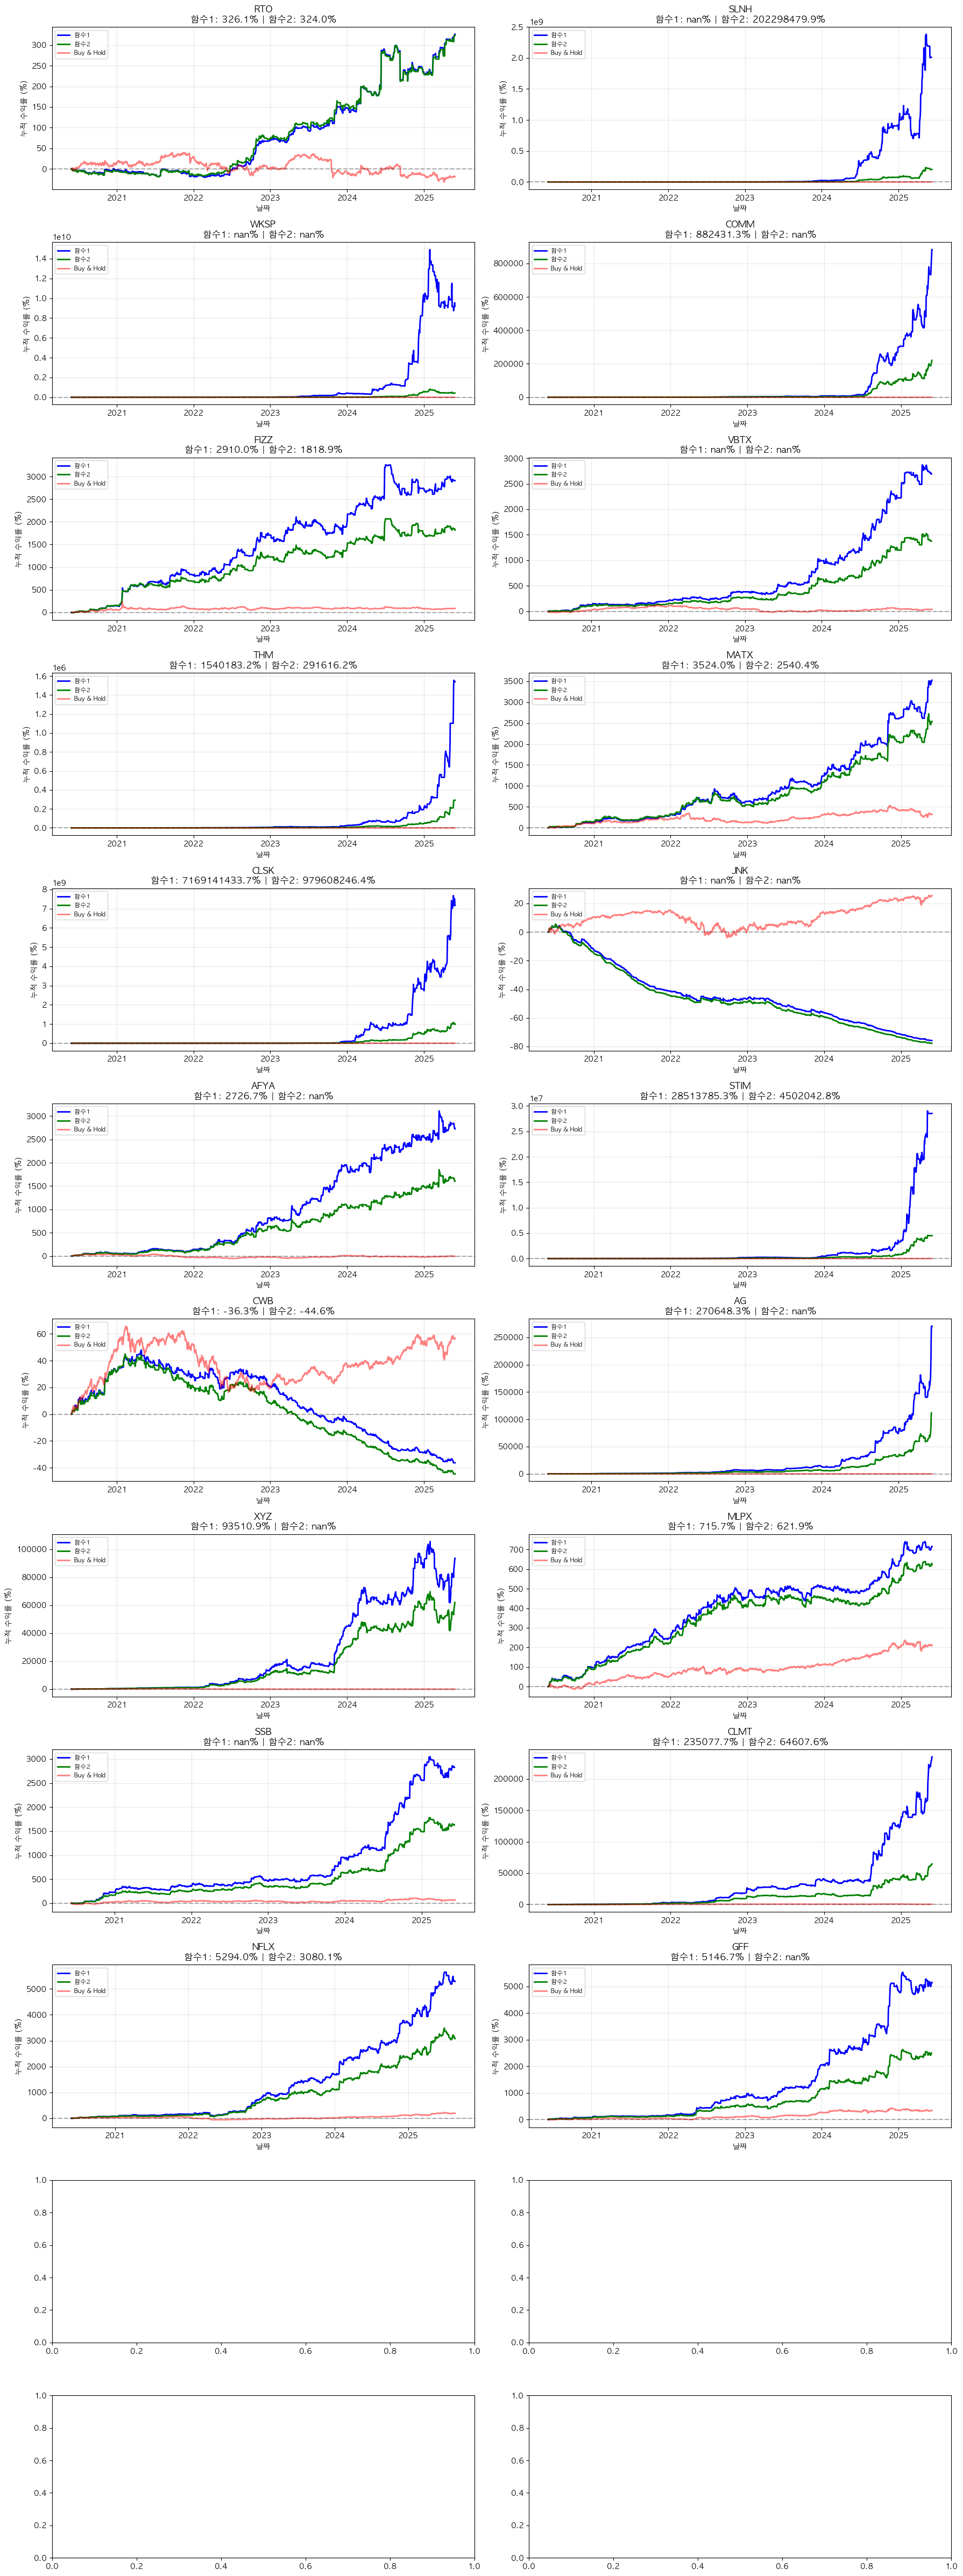

In [907]:

fig, axes = plt.subplots(12, 2, figsize=(18, 48))
axes = axes.flatten()

for idx, (ticker, results) in enumerate(comparison_results.items()):
    if idx < len(axes):
        ax = axes[idx]
        
        # ADX ÌïÑÌÑ∞Îßå
        adx_only = results['adx_only']
        ax.plot(adx_only.index, (adx_only['cumulative_returns'] - 1) * 100, 
                label='Ìï®Ïàò1', linewidth=2, color='blue')
        
        # ADX/Chaikin Î≥µÌï©
        adx_chaikin = results['adx_chaikin']
        ax.plot(adx_chaikin.index, (adx_chaikin['cumulative_returns'] - 1) * 100, 
                label='Ìï®Ïàò2', linewidth=2, color='green')
        
        # Buy & Hold
        ax.plot(adx_only.index, (adx_only['buy_hold_returns'] - 1) * 100, 
                label='Buy & Hold', linewidth=2, color='red', alpha=0.5)
        
        # ÏµúÏ¢Ö ÏàòÏùµÎ•† ÌëúÏãú
        adx_final = (adx_only['cumulative_returns'].iloc[-1] - 1) * 100
        combo_final = (adx_chaikin['cumulative_returns'].iloc[-1] - 1) * 100

        ax.set_title(f'{ticker}\nÌï®Ïàò1: {adx_final:.1f}% | Ìï®Ïàò2: {combo_final:.1f}%', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('ÎÇ†Ïßú')
        ax.set_ylabel('ÎàÑÏ†Å ÏàòÏùµÎ•† (%)')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3.2. Ïû•Ï§ë Ïã†Ìò∏ Í≥ÑÏÇ∞ ÌÖåÏä§Ìä∏

In [908]:
# Í∞úÏÑ†Îêú ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ìï®Ïàò - CSV Ï†ÄÏû• Í∏∞Îä• Ï∂îÍ∞Ä
def calculate_momentum_portfolio_returns_with_csv(stock_data, strategy_func, momentum_period=20, 
                                       rebalance_period=30, top_n=3, save_csv=False, 
                                       csv_filename=None, calculate_today_signals=False,
                                       calculate_intraday_signals=False, **kwargs):
    """
    ÏÉÅÎåÄÎ™®Î©òÌÖÄÏùÑ Ï†ÅÏö©Ìïú Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (CSV Ï†ÄÏû• Î∞è Ïû•Ï§ë Ïã†Ìò∏ Í∏∞Îä• Ìè¨Ìï®)
    
    Parameters:
    - save_csv: CSV ÌååÏùº Ï†ÄÏû• Ïó¨Î∂Ä (Í∏∞Î≥∏ False)
    - csv_filename: Ï†ÄÏû•Ìï† CSV ÌååÏùºÎ™Ö (Í∏∞Î≥∏Í∞í: momentum_calculation_YYYYMMDD_HHMMSS.csv)
    - calculate_today_signals: Ïò§Îäò ÎÇ†Ïßú Í∏∞Ï§Ä ÌïÑÌÑ∞ Í≥ÑÏÇ∞ Ïó¨Î∂Ä (Í∏∞Î≥∏ False)
    - calculate_intraday_signals: Ïû•Ï§ë ÌïÑÌÑ∞ Í≥ÑÏÇ∞ Ïó¨Î∂Ä (Í∏∞Î≥∏ False)
    """
    # Î™®Îì† Ï¢ÖÎ™©Ïùò Í≤∞Í≥º Ï†ÄÏû•
    all_results = {}
    all_dates = None
    
    # Í∞Å Ï¢ÖÎ™©Î≥Ñ Ï†ÑÎûµ Ïã§Ìñâ
    for ticker, df in stock_data.items():
        result = strategy_func(df, **kwargs)
        all_results[ticker] = result
        
        if all_dates is None:
            all_dates = set(result.index)
        else:
            all_dates = all_dates.intersection(set(result.index))
    
    # Í≥µÌÜµ ÎÇ†ÏßúÎßå ÏÑ†ÌÉù
    common_dates = sorted(list(all_dates))
    
    # Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏùºÏùº ÏàòÏùµÎ•† Ï†ÄÏû•
    portfolio_returns = pd.Series(index=common_dates, dtype=float)
    portfolio_returns[:] = 0.0
    
    # Ï¢ÖÎ™©Î≥Ñ Í∞ÄÏ§ëÏπò Í∏∞Î°ù
    weights_history = pd.DataFrame(index=common_dates, columns=list(stock_data.keys()))
    weights_history[:] = 0.0
    
    # Î¶¨Î∞∏Îü∞Ïã± ÎÇ†Ïßú Í≥ÑÏÇ∞
    rebalance_dates = common_dates[::rebalance_period]
    
    # ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≥ÑÏÇ∞Í≥ºÏ†ï Ï†ÄÏû•ÏùÑ ÏúÑÌïú Î¶¨Ïä§Ìä∏
    momentum_calculation_records = []
    
    # Í∞Å Î¶¨Î∞∏Îü∞Ïã± Í∏∞Í∞ÑÎ≥Ñ Ï≤òÎ¶¨
    for i in range(len(rebalance_dates)):
        start_date = rebalance_dates[i]
        end_date = rebalance_dates[i + 1] if i + 1 < len(rebalance_dates) else common_dates[-1]
        
        # Î™®Î©òÌÖÄ Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú Í≥ºÍ±∞ ÏàòÏùµÎ•†
        momentum_start_idx = common_dates.index(start_date) - momentum_period
        if momentum_start_idx < 0:
            momentum_start_idx = 0
        
        # Í∞Å Ï¢ÖÎ™©Ïùò Î™®Î©òÌÖÄ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
        momentum_scores = {}
        momentum_details = {}
        
        for ticker, result in all_results.items():
            # Î™®Î©òÌÖÄ Í∏∞Í∞Ñ ÎèôÏïàÏùò Í∞ÄÍ≤© Îç∞Ïù¥ÌÑ∞
            momentum_prices = result['close'].loc[common_dates[momentum_start_idx]:start_date]
            
            if len(momentum_prices) >= 2:
                # ÏãúÏûëÍ∞ÄÍ≤©Í≥º Ï¢ÖÎ£åÍ∞ÄÍ≤©
                start_price = momentum_prices.iloc[0]
                end_price = momentum_prices.iloc[-1]
                
                # Î™®Î©òÌÖÄ ÏàòÏùµÎ•† Í≥ÑÏÇ∞
                momentum_return = (end_price / start_price - 1) if start_price > 0 else 0
                
                # NaNÏù¥ÎÇò inf Ï≤òÎ¶¨
                if pd.isna(momentum_return) or np.isinf(momentum_return):
                    momentum_return = 0
                
                momentum_scores[ticker] = momentum_return
                momentum_details[ticker] = {
                    'start_price': start_price,
                    'end_price': end_price,
                    'momentum_return': momentum_return,
                    'momentum_period_start': momentum_prices.index[0],
                    'momentum_period_end': momentum_prices.index[-1]
                }
            else:
                momentum_scores[ticker] = 0
                momentum_details[ticker] = {
                    'start_price': 0,
                    'end_price': 0,
                    'momentum_return': 0,
                    'momentum_period_start': None,
                    'momentum_period_end': None
                }
        
        # ÏÉÅÏúÑ NÍ∞ú Ï¢ÖÎ™© ÏÑ†ÌÉù
        sorted_tickers = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        selected_tickers = [ticker for ticker, _ in sorted_tickers[:top_n]]
        
        # ÏÑ†ÌÉùÎêú Ï¢ÖÎ™©Ïóê ÎèôÏùº Í∞ÄÏ§ë
        weight = 1.0 / len(selected_tickers) if selected_tickers else 0
        
        # Î¶¨Î∞∏Îü∞Ïã± ÏãúÏ†êÏùò Í≥ÑÏÇ∞Í≥ºÏ†ï Í∏∞Î°ù
        for rank, (ticker, score) in enumerate(sorted_tickers):
            record = {
                'rebalance_date': start_date,
                'ticker': ticker,
                'rank': rank + 1,
                'momentum_score': score * 100,  # ÌçºÏÑºÌä∏Î°ú Î≥ÄÌôò
                'momentum_period_start': momentum_details[ticker]['momentum_period_start'],
                'momentum_period_end': momentum_details[ticker]['momentum_period_end'],
                'start_price': momentum_details[ticker]['start_price'],
                'end_price': momentum_details[ticker]['end_price'],
                'selected': ticker in selected_tickers,
                'weight': weight if ticker in selected_tickers else 0,
                'rebalance_period_start': start_date,
                'rebalance_period_end': end_date
            }
            momentum_calculation_records.append(record)
        
        # Ìï¥Îãπ Í∏∞Í∞Ñ ÎèôÏïàÏùò ÏàòÏùµÎ•† Í≥ÑÏÇ∞
        period_dates = [d for d in common_dates if start_date <= d <= end_date]
        
        for date in period_dates:
            daily_return = 0.0
            
            # ÏÑ†ÌÉùÎêú Ï¢ÖÎ™©Îì§Ïùò ÏàòÏùµÎ•† Í∞ÄÏ§ë ÌèâÍ∑†
            for ticker in selected_tickers:
                ticker_return = all_results[ticker].loc[date, 'returns']
                # NaNÏù¥ÎÇò inf Ï≤òÎ¶¨
                if pd.isna(ticker_return) or np.isinf(ticker_return):
                    ticker_return = 0
                daily_return += ticker_return * weight
                weights_history.loc[date, ticker] = weight
            
            portfolio_returns.loc[date] = daily_return
    
    # ÎàÑÏ†Å ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (NaN Ï≤òÎ¶¨)
    clean_returns = portfolio_returns.replace([np.inf, -np.inf], 0).fillna(0)
    portfolio_cumulative = (1 + clean_returns).cumprod()
    
    # ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≥ÑÏÇ∞Í≥ºÏ†ïÏùÑ DataFrameÏúºÎ°ú Î≥ÄÌôò
    momentum_calculation_df = pd.DataFrame(momentum_calculation_records)
    
    # Ïò§Îäò ÎÇ†Ïßú Í∏∞Ï§Ä ÌïÑÌÑ∞ Í≥ÑÏÇ∞ (ÏÑ†ÌÉùÏÇ¨Ìï≠)
    today_signals_df = None
    if calculate_today_signals and len(common_dates) > 0:
        today_date = common_dates[-1]
        today_signals = []
        
        print(f"\nüìä Ïò§Îäò({today_date}) Í∏∞Ï§Ä ÌïÑÌÑ∞ Í≥ÑÏÇ∞:")
        print("=" * 80)
        
        for ticker in stock_data.keys():
            if ticker in all_results:
                result = all_results[ticker]
                
                # Î™®Î©òÌÖÄ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
                if len(result) > momentum_period:
                    start_price = result['close'].iloc[-momentum_period-1]
                    current_price = result['close'].iloc[-1]
                    momentum_score = ((current_price - start_price) / start_price * 100) if start_price > 0 else 0
                else:
                    momentum_score = 0
                
                # Ïò§ÎäòÏùò ÌïÑÌÑ∞ ÏÉÅÌÉú
                last_idx = result.index[-1]
                
                today_signal = {
                    'ticker': ticker,
                    'momentum_score': momentum_score,
                    'UPTREND': result.get('UPTREND', pd.Series(False)).loc[last_idx] if 'UPTREND' in result.columns else False,
                    'GREEN4': result.get('GREEN4', pd.Series(False)).loc[last_idx] if 'GREEN4' in result.columns else False,
                    'obv_filter': result.get('obv_filter', pd.Series(False)).loc[last_idx] if 'obv_filter' in result.columns else False,
                    'GREEN2': result.get('GREEN2', pd.Series(False)).loc[last_idx] if 'GREEN2' in result.columns else False,
                }
                today_signals.append(today_signal)
        
        today_signals_df = pd.DataFrame(today_signals)
        today_signals_df = today_signals_df.sort_values('momentum_score', ascending=False)
    
    # Ïû•Ï§ë ÌïÑÌÑ∞ Í≥ÑÏÇ∞ (ÏÑ†ÌÉùÏÇ¨Ìï≠)
    intraday_signals_df = None
    if calculate_intraday_signals and len(common_dates) > 1:
        intraday_signals = []
        yesterday_idx = -2
        
        print(f"\nüìä Ïû•Ï§ë ÏÇ¨Ïö© Í∞ÄÎä•Ìïú ÌïÑÌÑ∞ ÏÉÅÌÉú (Ïñ¥Ï†ú Ï¢ÖÍ∞Ä Í∏∞Ï§Ä):")
        print("=" * 80)
        
        for ticker in stock_data.keys():
            if ticker in all_results:
                result = all_results[ticker]
                
                # Ïñ¥Ï†ú Ï¢ÖÍ∞Ä Í∏∞Ï§Ä Î™®Î©òÌÖÄ
                if len(result) > momentum_period + 1:
                    yesterday_close = result['close'].iloc[yesterday_idx]
                    close_20d_ago = result['close'].iloc[yesterday_idx - momentum_period]
                    momentum_score = ((yesterday_close - close_20d_ago) / close_20d_ago * 100) if close_20d_ago > 0 else 0
                else:
                    momentum_score = 0
                
                # Ïñ¥Ï†úÏùò ÌïÑÌÑ∞ ÏÉÅÌÉú (Ïò§Îäò ÏÇ¨Ïö© Í∞ÄÎä•)
                yesterday_data_idx = result.index[yesterday_idx]
                
                # Ïñ¥Ï†ú Range (Ïò§Îäò Î™©ÌëúÍ∞Ä Í≥ÑÏÇ∞Ïö©)
                yesterday_range = result['high'].iloc[yesterday_idx] - result['low'].iloc[yesterday_idx]
                
                intraday_signal = {
                    'ticker': ticker,
                    'momentum_score': momentum_score,
                    'yesterday_close': result['close'].iloc[yesterday_idx],
                    'yesterday_range': yesterday_range,
                    'UPTREND_active': result.get('UPTREND', pd.Series(False)).loc[yesterday_data_idx] if 'UPTREND' in result.columns else False,
                    'GREEN4_active': result.get('GREEN4', pd.Series(False)).loc[yesterday_data_idx] if 'GREEN4' in result.columns else False,
                    'obv_filter_active': result.get('obv_filter', pd.Series(False)).loc[yesterday_data_idx] if 'obv_filter' in result.columns else False,
                    'GREEN2_active': result.get('GREEN2', pd.Series(False)).loc[yesterday_data_idx] if 'GREEN2' in result.columns else False,
                    'target_addon_k0.3': yesterday_range * 0.3,
                    'target_addon_k0.5': yesterday_range * 0.5,
                }
                intraday_signals.append(intraday_signal)
        
        intraday_signals_df = pd.DataFrame(intraday_signals)
        intraday_signals_df = intraday_signals_df.sort_values('momentum_score', ascending=False)
        
        # ÏÉÅÏúÑ Ï¢ÖÎ™© Ï∂úÎ†•
        print("\nÎ™®Î©òÌÖÄ ÏÉÅÏúÑ Ï¢ÖÎ™© (Ïû•Ï§ë ÏÇ¨Ïö©):")
        for i, row in intraday_signals_df.head(top_n).iterrows():
            filters = []
            if row['UPTREND_active']: filters.append('ADX')
            if row['GREEN4_active']: filters.append('Chaikin')
            if row['obv_filter_active']: filters.append('OBV')
            if row['GREEN2_active']: filters.append('GREEN2')
            
            print(f"{row['ticker']:>6}: Î™®Î©òÌÖÄ {row['momentum_score']:>6.2f}% | ÌïÑÌÑ∞: {', '.join(filters) if filters else 'None'}")
            print(f"        Î™©ÌëúÍ∞Ä: ÏãúÍ∞Ä+{row['target_addon_k0.3']:.2f} (K=0.3), ÏãúÍ∞Ä+{row['target_addon_k0.5']:.2f} (K=0.5)")
    
    # CSV Ï†ÄÏû• ÏòµÏÖòÏù¥ ÏºúÏ†∏ÏûàÏúºÎ©¥ ÌååÏùºÎ°ú Ï†ÄÏû•
    if save_csv:
        if csv_filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            csv_filename = f"momentum_calculation_{timestamp}.csv"
        
        # Í≥ÑÏÇ∞Í≥ºÏ†ï CSV Ï†ÄÏû•
        momentum_calculation_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
        print(f"\nüìä ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≥ÑÏÇ∞Í≥ºÏ†ïÏù¥ '{csv_filename}'Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
        
        # Ï∂îÍ∞ÄÎ°ú ÏùºÎ≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í∞ÄÏ§ëÏπòÎèÑ Ï†ÄÏû•
        weights_filename = csv_filename.replace('.csv', '_weights.csv')
        weights_history.to_csv(weights_filename, encoding='utf-8-sig')
        print(f"üìä ÏùºÎ≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í∞ÄÏ§ëÏπòÍ∞Ä '{weights_filename}'Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
        
        # Ïû•Ï§ë Ïã†Ìò∏ÎèÑ Ï†ÄÏû•
        if calculate_intraday_signals and intraday_signals_df is not None:
            intraday_filename = csv_filename.replace('.csv', '_intraday.csv')
            intraday_signals_df.to_csv(intraday_filename, index=False, encoding='utf-8-sig')
            print(f"üìä Ïû•Ï§ë Ïã†Ìò∏Í∞Ä '{intraday_filename}'Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
        
        # ÏöîÏïΩ ÌÜµÍ≥Ñ Ï∂úÎ†•
        print(f"\nüìä ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≥ÑÏÇ∞ ÏöîÏïΩ:")
        print(f"- Ï¥ù Î¶¨Î∞∏Îü∞Ïã± ÌöüÏàò: {len(rebalance_dates)}Ìöå")
        print(f"- Ï¥ù Í≥ÑÏÇ∞ Î†àÏΩîÎìú: {len(momentum_calculation_df)}Í∞ú")
        print(f"- Î∂ÑÏÑù Í∏∞Í∞Ñ: {common_dates[0]} ~ {common_dates[-1]}")
        print(f"- ÌèâÍ∑† Î™®Î©òÌÖÄ Ïä§ÏΩîÏñ¥: {momentum_calculation_df['momentum_score'].mean():.2f}%")
        
        # Ï¢ÖÎ™©Î≥Ñ ÏÑ†ÌÉù ÎπàÎèÑ
        selection_stats = momentum_calculation_df[momentum_calculation_df['selected']].groupby('ticker').size()
        print(f"\nüìä Ï¢ÖÎ™©Î≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ìé∏ÏûÖ ÌöüÏàò:")
        for ticker, count in selection_stats.sort_values(ascending=False).items():
            print(f"  - {ticker}: {count}Ìöå")
    
    return portfolio_returns, portfolio_cumulative, weights_history, momentum_calculation_df

### 5.2. Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÌÜµÌï© ÏàòÏùµÎ•† Î∂ÑÏÑù


=== Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÑ±Í≥º ÏöîÏïΩ (ÎèôÏùº Í∞ÄÏ§ë) ===
Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¥ù ÏàòÏùµÎ•†: 194281.40%
Buy & Hold Ï¥ù ÏàòÏùµÎ•†: 258.14%
Ï¥àÍ≥º ÏàòÏùµÎ•†: 194023.26%
Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉ§ÌîÑ ÎπÑÏú®: 16.90
Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ MDD: -8.00%
Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ïó∞ÌôòÏÇ∞ ÏàòÏùµÎ•†: 325.86%
Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î≥ÄÎèôÏÑ±: 19.28%
Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏäπÎ•†: 64.01%


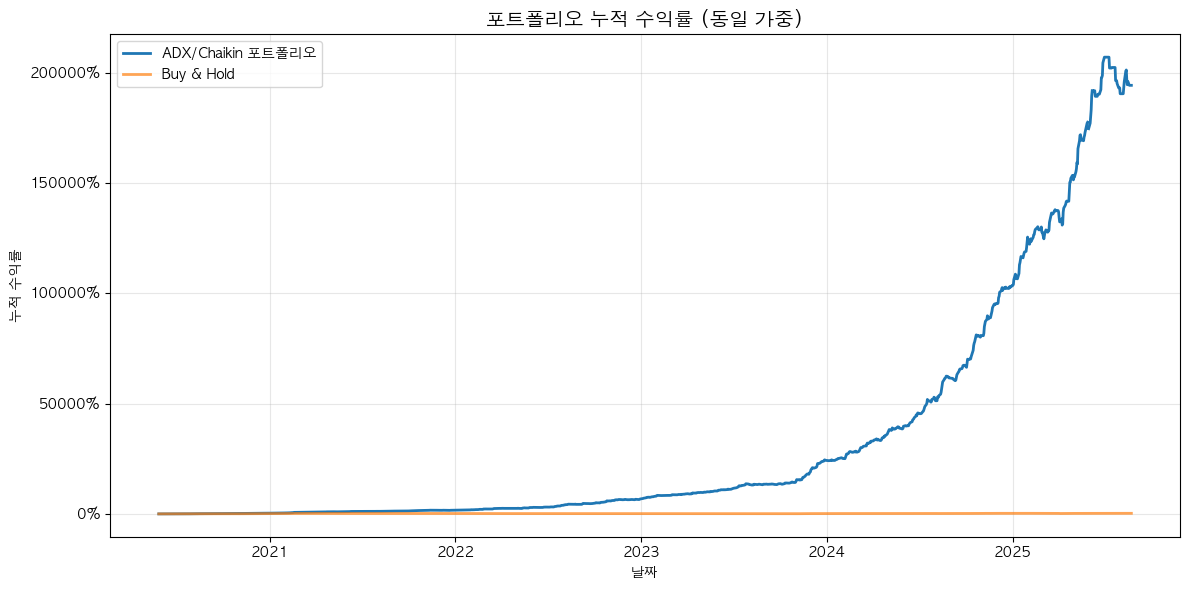

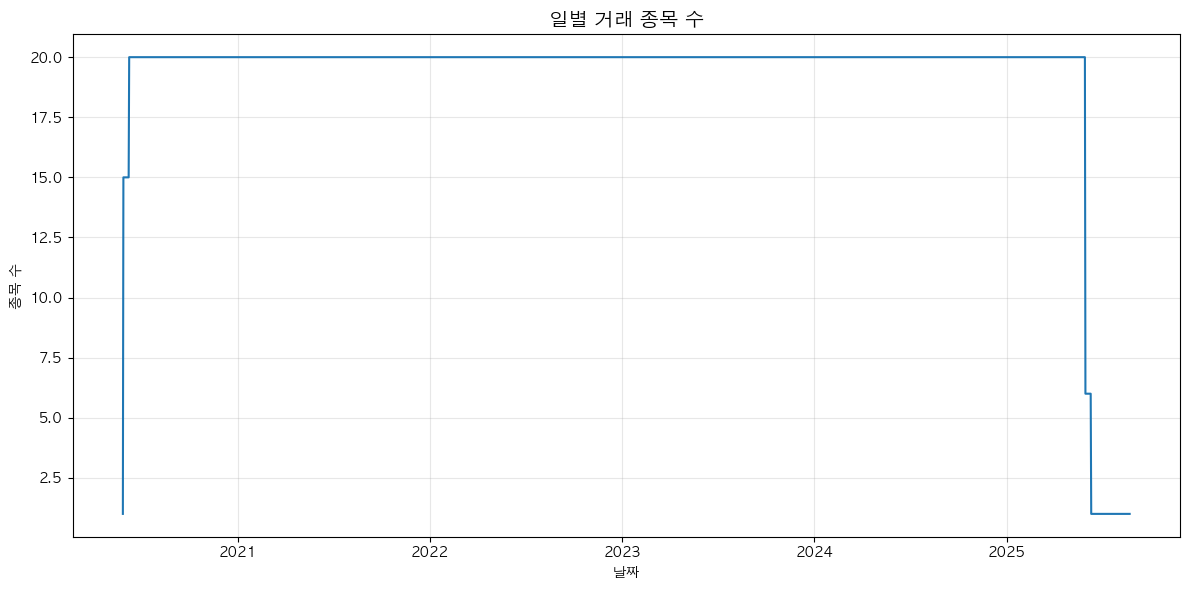

In [909]:
# Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ Ìï®Ïàò
def calculate_portfolio_returns(all_results, tickers):
    """Ïó¨Îü¨ Ï¢ÖÎ™©Ïùò Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (ÎèôÏùº Í∞ÄÏ§ë)"""
    # Î™®Îì† Í±∞ÎûòÏùº Ï∂îÏ∂ú
    all_dates = set()
    for ticker in tickers:
        if ticker in all_results:
            all_dates.update(all_results[ticker].index)
    all_dates = sorted(all_dates)
    
    # ÎÇ†ÏßúÎ≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    portfolio_data = []
    
    for date in all_dates:
        daily_returns = []
        buy_hold_returns = []
        
        for ticker in tickers:
            if ticker in all_results and date in all_results[ticker].index:
                daily_returns.append(all_results[ticker].loc[date, 'daily_return'])
                buy_hold_returns.append(all_results[ticker].loc[date, 'buy_hold_return'])
        
        if daily_returns:  # Ìï¥Îãπ ÎÇ†ÏßúÏóê Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÎäî Í≤ΩÏö∞Îßå
            portfolio_data.append({
                'date': date,
                'portfolio_return': np.mean(daily_returns),
                'buy_hold_return': np.mean(buy_hold_returns),
                'active_tickers': len(daily_returns)
            })
    
    # DataFrame ÏÉùÏÑ±
    df = pd.DataFrame(portfolio_data)
    df.set_index('date', inplace=True)
    
    # ÎàÑÏ†Å ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    df['portfolio_cumulative'] = (1 + df['portfolio_return']).cumprod() - 1
    df['buy_hold_cumulative'] = (1 + df['buy_hold_return']).cumprod() - 1
    
    return df

# ÏÑ±Í≥º ÏßÄÌëú Í≥ÑÏÇ∞ Ìï®Ïàò
def calculate_performance_metrics(returns, cumulative_returns):
    """ÏÑ±Í≥º ÏßÄÌëú Í≥ÑÏÇ∞"""
    if len(returns) == 0 or len(cumulative_returns) == 0:
        return {
            'total_return': 0,
            'annual_return': 0,
            'volatility': 0,
            'sharpe_ratio': 0,
            'mdd': 0,
            'win_rate': 0,
            'avg_win': 0,
            'avg_loss': 0,
            'trade_count': 0
        }
    
    try:
        # Í∏∞Î≥∏ ÏßÄÌëú
        total_return = cumulative_returns.iloc[-1] if len(cumulative_returns) > 0 else 0
        
        # Ïó∞ÌôòÏÇ∞ ÏàòÏùµÎ•†
        years = len(returns) / 252
        annual_return = (1 + total_return) ** (1/years) - 1 if years > 0 else 0
        
        # Î≥ÄÎèôÏÑ±
        volatility = returns.std() * np.sqrt(252)
        
        # ÏÉ§ÌîÑ ÎπÑÏú®
        sharpe_ratio = annual_return / volatility if volatility > 0 else 0
        
        # MDD
        cumulative_returns_series = pd.Series(cumulative_returns)
        running_max = cumulative_returns_series.expanding().max()
        drawdown = (cumulative_returns_series - running_max) / (1 + running_max)
        mdd = drawdown.min()
        
        # ÏäπÎ•†
        wins = returns[returns > 0]
        losses = returns[returns < 0]
        win_rate = len(wins) / len(returns) if len(returns) > 0 else 0
        
        # ÌèâÍ∑† ÏÜêÏùµ
        avg_win = wins.mean() if len(wins) > 0 else 0
        avg_loss = losses.mean() if len(losses) > 0 else 0
        
        return {
            'total_return': total_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'mdd': mdd,
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'trade_count': len(returns)
        }
    except Exception as e:
        print(f"ÏÑ±Í≥º ÏßÄÌëú Í≥ÑÏÇ∞ Ï§ë Ïò§Î•ò: {e}")
        return {
            'total_return': 0,
            'annual_return': 0,
            'volatility': 0,
            'sharpe_ratio': 0,
            'mdd': 0,
            'win_rate': 0,
            'avg_win': 0,
            'avg_loss': 0,
            'trade_count': 0
        }

# Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞
cumulative_returns = calculate_portfolio_returns(all_results, selected_tickers)

# ÏÑ±Í≥º ÏßÄÌëú Í≥ÑÏÇ∞
portfolio_metrics = calculate_performance_metrics(
    cumulative_returns['portfolio_return'], 
    cumulative_returns['portfolio_cumulative']
)
buy_hold_metrics = calculate_performance_metrics(
    cumulative_returns['buy_hold_return'], 
    cumulative_returns['buy_hold_cumulative']
)

# 8. Í≤∞Í≥º ÏãúÍ∞ÅÌôî - 1Î∞∞Ïó¥Ïóê 1Í∞úÏùò Í∑∏ÎûòÌîÑ, ÏàúÏÑú Î≥ÄÍ≤Ω
# 8-1. ÏÑ±Í≥º ÏßÄÌëú ÌÖåÏù¥Î∏î
print("\n=== Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÑ±Í≥º ÏöîÏïΩ (ÎèôÏùº Í∞ÄÏ§ë) ===")
print(f"Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¥ù ÏàòÏùµÎ•†: {portfolio_metrics['total_return']:.2%}")
print(f"Buy & Hold Ï¥ù ÏàòÏùµÎ•†: {buy_hold_metrics['total_return']:.2%}")
print(f"Ï¥àÍ≥º ÏàòÏùµÎ•†: {portfolio_metrics['total_return'] - buy_hold_metrics['total_return']:.2%}")
print(f"Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÉ§ÌîÑ ÎπÑÏú®: {portfolio_metrics['sharpe_ratio']:.2f}")
print(f"Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ MDD: {portfolio_metrics['mdd']:.2%}")
print(f"Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ïó∞ÌôòÏÇ∞ ÏàòÏùµÎ•†: {portfolio_metrics['annual_return']:.2%}")
print(f"Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î≥ÄÎèôÏÑ±: {portfolio_metrics['volatility']:.2%}")
print(f"Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏäπÎ•†: {portfolio_metrics['win_rate']:.2%}")

# 8-2. ÎàÑÏ†Å ÏàòÏùµÎ•† Í∑∏ÎûòÌîÑ
fig1 = plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns['portfolio_cumulative'], 
        label='ADX/Chaikin Ìè¨Ìä∏Ìè¥Î¶¨Ïò§', linewidth=2)
plt.plot(cumulative_returns.index, cumulative_returns['buy_hold_cumulative'], 
        label='Buy & Hold', linewidth=2, alpha=0.7)
plt.title('Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÎàÑÏ†Å ÏàòÏùµÎ•† (ÎèôÏùº Í∞ÄÏ§ë)', fontsize=14)
plt.xlabel('ÎÇ†Ïßú')
plt.ylabel('ÎàÑÏ†Å ÏàòÏùµÎ•†')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.show()

# 8-3. ÏùºÎ≥Ñ Í±∞Îûò Ï¢ÖÎ™© Ïàò
fig2 = plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns['active_tickers'])
plt.title('ÏùºÎ≥Ñ Í±∞Îûò Ï¢ÖÎ™© Ïàò', fontsize=14)
plt.xlabel('ÎÇ†Ïßú')
plt.ylabel('Ï¢ÖÎ™© Ïàò')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.3. ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ï†ÑÎûµ ÏãúÍ∞ÅÌôî (Ïó∞Í∞Ñ/ÏõîÍ∞Ñ ÏàòÏùµÎ•† Ìè¨Ìï®)


üìä ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï†ÑÎûµ Î∂ÑÏÑù:


/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_78509/737542318.py:57: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_returns = result['close'].shift(1).loc[common_dates[momentum_start_idx]:start_date].pct_change()



5Ïùº Î™®Î©òÌÖÄ Top5:
  Ï¥ù ÏàòÏùµÎ•†: 393641.4%
  ÏäπÎ•†: 53.2%
  Sharpe Ratio: 13.16
  MDD: -13.3%


/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_78509/737542318.py:57: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_returns = result['close'].shift(1).loc[common_dates[momentum_start_idx]:start_date].pct_change()



10Ïùº Î™®Î©òÌÖÄ Top7:
  Ï¥ù ÏàòÏùµÎ•†: 150078.9%
  ÏäπÎ•†: 56.7%
  Sharpe Ratio: 12.25
  MDD: -8.4%


/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_78509/737542318.py:57: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_returns = result['close'].shift(1).loc[common_dates[momentum_start_idx]:start_date].pct_change()



20Ïùº Î™®Î©òÌÖÄ Top10:
  Ï¥ù ÏàòÏùµÎ•†: 83193.3%
  ÏäπÎ•†: 59.0%
  Sharpe Ratio: 12.94
  MDD: -7.1%

ÎèôÏùºÍ∞ÄÏ§ë (ÎπÑÍµêÏö©):
  Ï¥ù ÏàòÏùµÎ•†: 194281.4%
  Sharpe Ratio: 16.90
  MDD: -8.0%


/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_78509/737542318.py:279: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(monthly_returns_data, labels=labels, patch_artist=True)


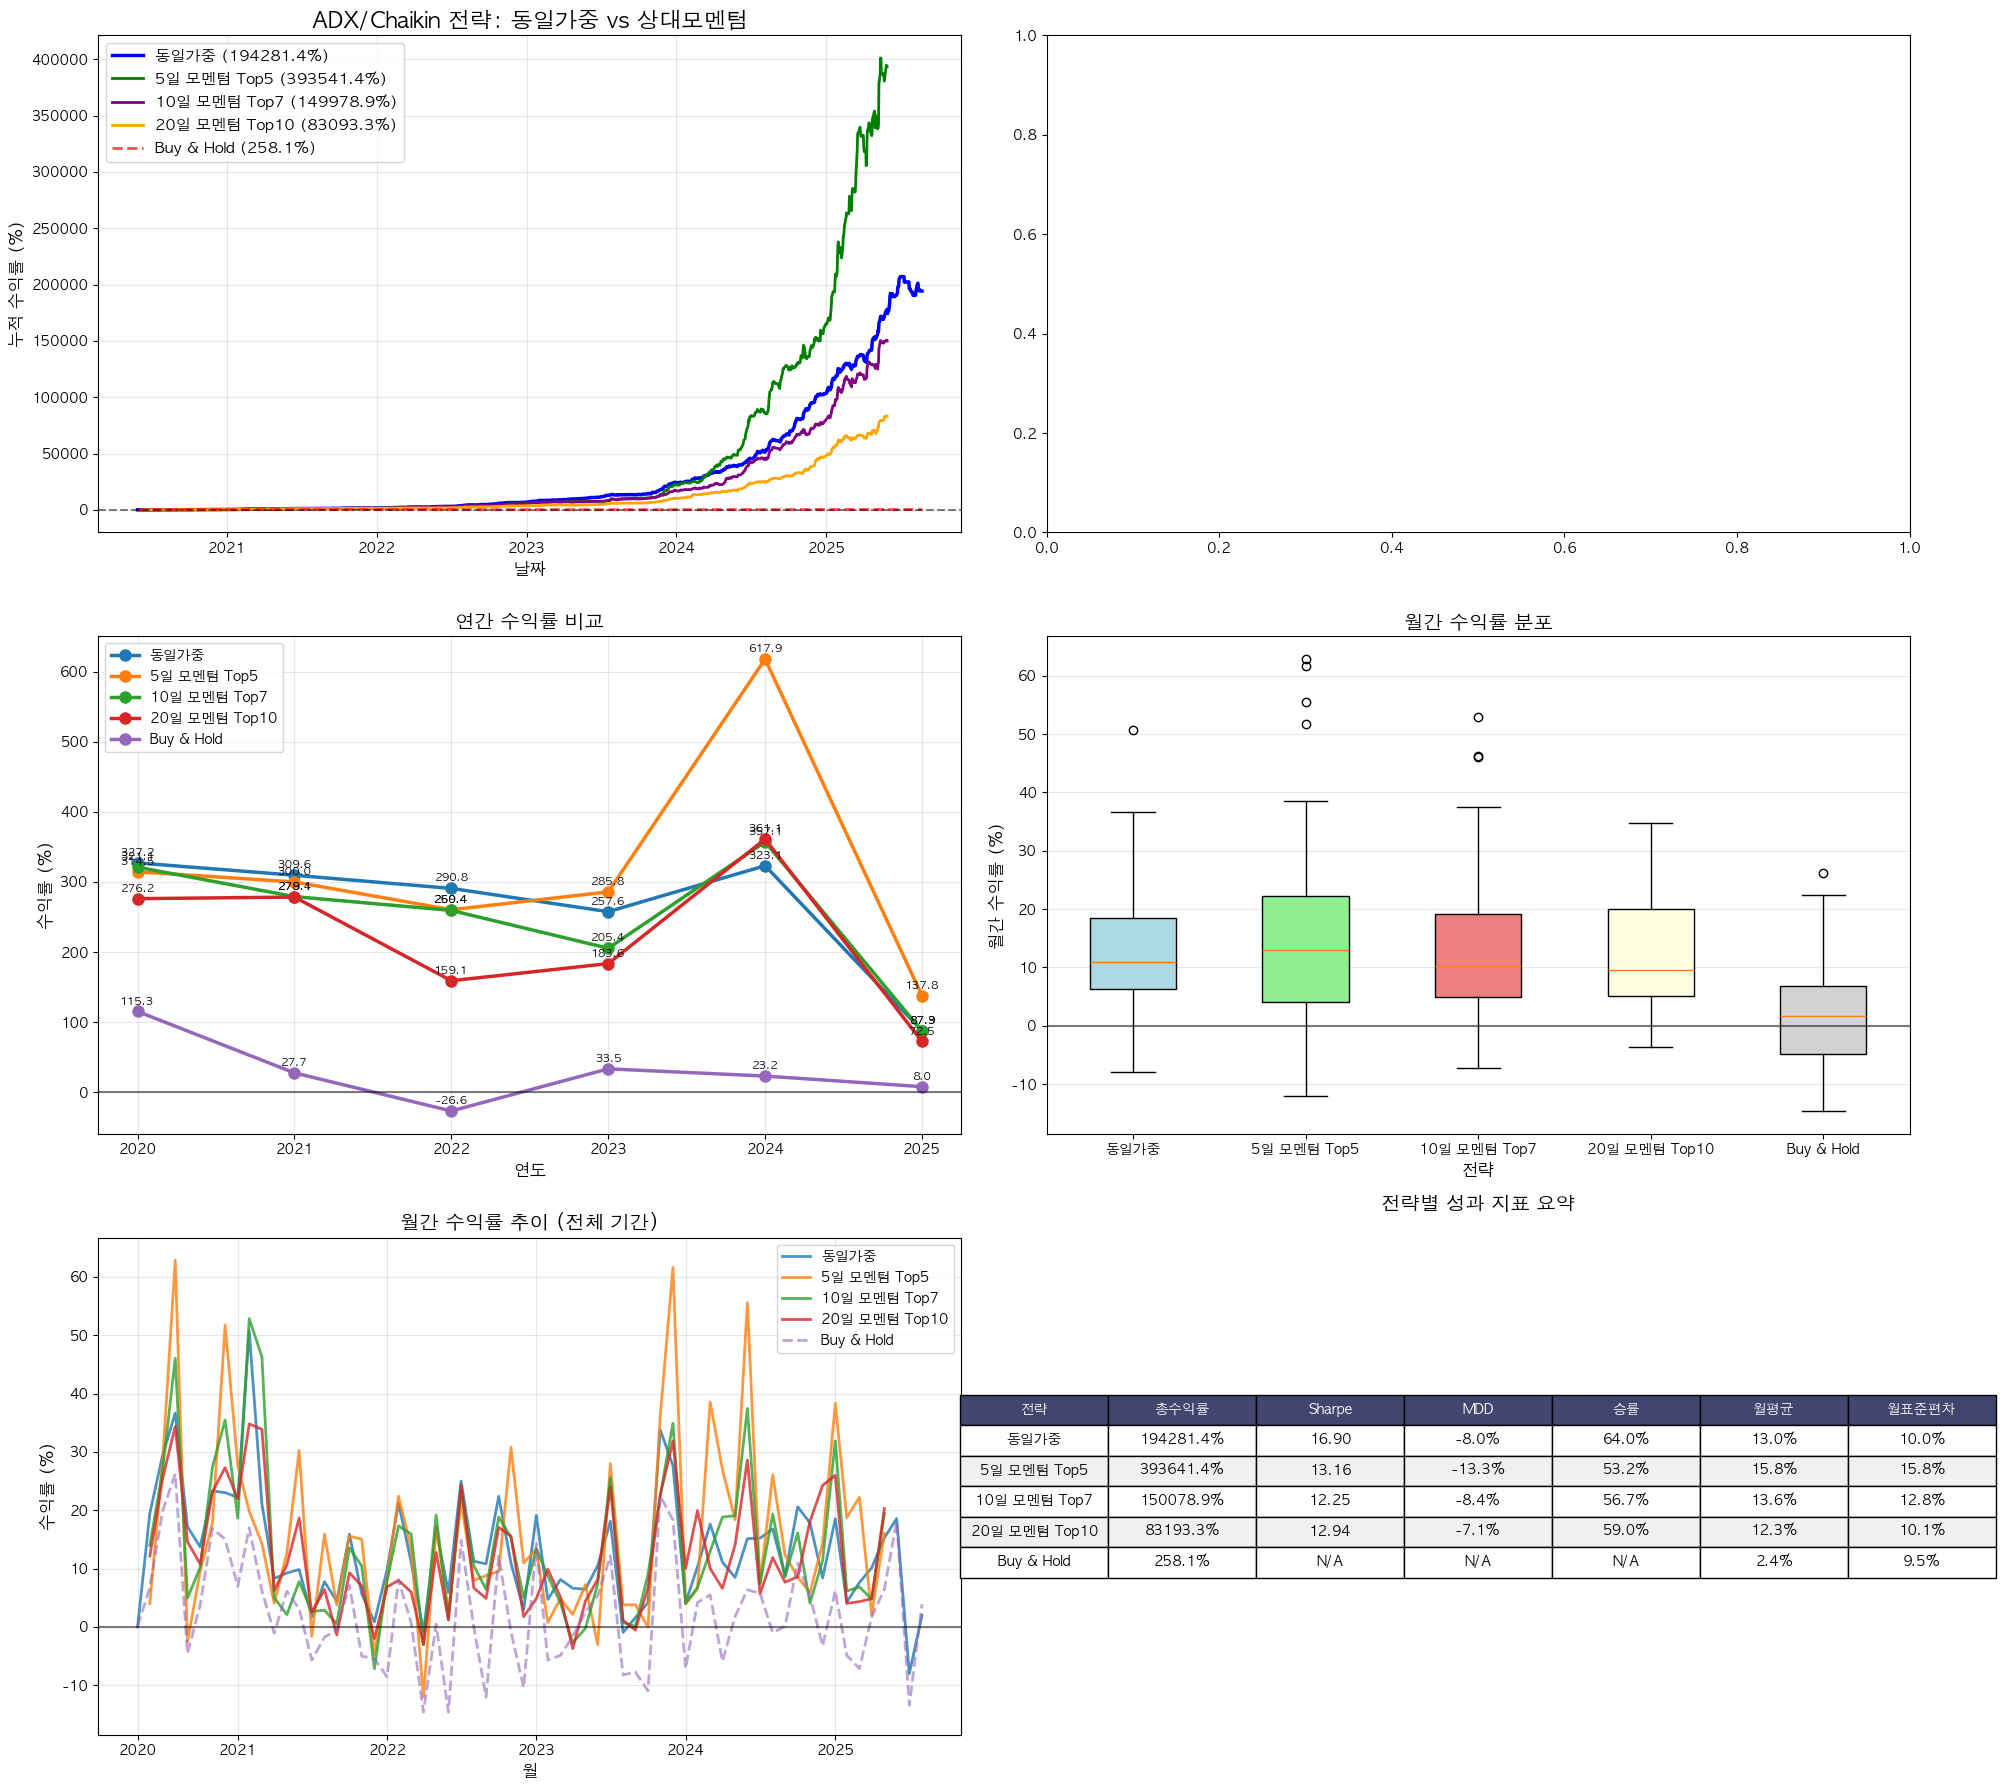


üìä Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï†ÑÎûµ ÏÑ±Í≥º ÎπÑÍµê:
         Ï†ÑÎûµ          |     Ï¥ùÏàòÏùµÎ•†     |   Sharpe   |    MDD     |     ÏäπÎ•†    
----------------------------------------------------------------------------------------------------
        ÎèôÏùºÍ∞ÄÏ§ë         |  194281.4  % |   16.90    |   -8.0   % |   64.0   %
    5Ïùº Î™®Î©òÌÖÄ Top5      |  393641.4  % |   13.16    |   -13.3  % |   53.2   %
    10Ïùº Î™®Î©òÌÖÄ Top7     |  150078.9  % |   12.25    |   -8.4   % |   56.7   %
   20Ïùº Î™®Î©òÌÖÄ Top10     |   83193.3  % |   12.94    |   -7.1   % |   59.0   %
     Buy & Hold      |    158.1   % |    N/A     |    N/A     |    N/A    


In [910]:
# ÏÉÅÎåÄÎ™®Î©òÌÖÄÏùÑ Ï†ÅÏö©Ìïú Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ Ìï®Ïàò
def calculate_momentum_portfolio_returns(stock_data, strategy_func, momentum_period=20, 
                                       rebalance_period=30, top_n=3, **kwargs):
    """
    ÏÉÅÎåÄÎ™®Î©òÌÖÄÏùÑ Ï†ÅÏö©Ìïú Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏàòÏùµÎ•† Í≥ÑÏÇ∞
    
    Parameters:
    - stock_data: Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞ ÎîïÏÖîÎÑàÎ¶¨
    - strategy_func: Ï†ÑÎûµ Ìï®Ïàò
    - momentum_period: Î™®Î©òÌÖÄ Í≥ÑÏÇ∞ Í∏∞Í∞Ñ (Í∏∞Î≥∏ 20Ïùº)
    - rebalance_period: Î¶¨Î∞∏Îü∞Ïã± Ï£ºÍ∏∞ (Í∏∞Î≥∏ 20Ïùº)
    - top_n: ÏÉÅÏúÑ nÍ∞ú Ï¢ÖÎ™© ÏÑ†ÌÉù (Í∏∞Î≥∏ 3Í∞ú)
    - **kwargs: Ï†ÑÎûµ Ìï®ÏàòÏóê Ï†ÑÎã¨Ìï† Ï∂îÍ∞Ä Ïù∏Ïûê
    """
    # Î™®Îì† Ï¢ÖÎ™©Ïùò Í≤∞Í≥º Ï†ÄÏû•
    all_results = {}
    all_dates = None
    
    # Í∞Å Ï¢ÖÎ™©Î≥Ñ Ï†ÑÎûµ Ïã§Ìñâ
    for ticker, df in stock_data.items():
        result = strategy_func(df, **kwargs)
        all_results[ticker] = result
        
        if all_dates is None:
            all_dates = set(result.index)
        else:
            all_dates = all_dates.intersection(set(result.index))
    
    # Í≥µÌÜµ ÎÇ†ÏßúÎßå ÏÑ†ÌÉù
    common_dates = sorted(list(all_dates))
    
    # Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏùºÏùº ÏàòÏùµÎ•† Ï†ÄÏû•
    portfolio_returns = pd.Series(index=common_dates, dtype=float)
    portfolio_returns[:] = 0.0
    
    # Ï¢ÖÎ™©Î≥Ñ Í∞ÄÏ§ëÏπò Í∏∞Î°ù
    weights_history = pd.DataFrame(index=common_dates, columns=list(stock_data.keys()))
    weights_history[:] = 0.0
    
    # Î¶¨Î∞∏Îü∞Ïã± ÎÇ†Ïßú Í≥ÑÏÇ∞
    rebalance_dates = common_dates[::rebalance_period]
    
    # Í∞Å Î¶¨Î∞∏Îü∞Ïã± Í∏∞Í∞ÑÎ≥Ñ Ï≤òÎ¶¨
    for i in range(len(rebalance_dates)):
        start_date = rebalance_dates[i]
        end_date = rebalance_dates[i + 1] if i + 1 < len(rebalance_dates) else common_dates[-1]
        
        # Î™®Î©òÌÖÄ Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú Í≥ºÍ±∞ ÏàòÏùµÎ•†
        momentum_start_idx = common_dates.index(start_date) - momentum_period
        if momentum_start_idx < 0:
            momentum_start_idx = 0
        
        # Í∞Å Ï¢ÖÎ™©Ïùò Î™®Î©òÌÖÄ Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
        momentum_scores = {}
        for ticker, result in all_results.items():
            # Î™®Î©òÌÖÄ Í∏∞Í∞Ñ ÎèôÏïàÏùò ÏàòÏùµÎ•†
            momentum_returns = result['close'].shift(1).loc[common_dates[momentum_start_idx]:start_date].pct_change()
            momentum_score = (1 + momentum_returns).prod() - 1
            # NaNÏù¥ÎÇò inf Ï≤òÎ¶¨
            if pd.isna(momentum_score) or np.isinf(momentum_score):
                momentum_score = 0
            momentum_scores[ticker] = momentum_score
        
        # ÏÉÅÏúÑ NÍ∞ú Ï¢ÖÎ™© ÏÑ†ÌÉù
        sorted_tickers = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        selected_tickers = [ticker for ticker, _ in sorted_tickers[:top_n]]
        
        # ÏÑ†ÌÉùÎêú Ï¢ÖÎ™©Ïóê ÎèôÏùº Í∞ÄÏ§ë
        weight = 1.0 / len(selected_tickers) if selected_tickers else 0
        
        # Ìï¥Îãπ Í∏∞Í∞Ñ ÎèôÏïàÏùò ÏàòÏùµÎ•† Í≥ÑÏÇ∞
        period_dates = [d for d in common_dates if start_date <= d <= end_date]
        
        for date in period_dates:
            daily_return = 0.0
            
            # ÏÑ†ÌÉùÎêú Ï¢ÖÎ™©Îì§Ïùò ÏàòÏùµÎ•† Í∞ÄÏ§ë ÌèâÍ∑†
            for ticker in selected_tickers:
                ticker_return = all_results[ticker].loc[date, 'returns']
                # NaNÏù¥ÎÇò inf Ï≤òÎ¶¨
                if pd.isna(ticker_return) or np.isinf(ticker_return):
                    ticker_return = 0
                daily_return += ticker_return * weight
                weights_history.loc[date, ticker] = weight
            
            portfolio_returns.loc[date] = daily_return
    
    # ÎàÑÏ†Å ÏàòÏùµÎ•† Í≥ÑÏÇ∞ (NaN Ï≤òÎ¶¨)
    clean_returns = portfolio_returns.replace([np.inf, -np.inf], 0).fillna(0)
    portfolio_cumulative = (1 + clean_returns).cumprod()
    
    return portfolio_returns, portfolio_cumulative, weights_history

# ÎèôÏùºÍ∞ÄÏ§ë Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ vs ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÎπÑÍµê
print("\nüìä ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï†ÑÎûµ Î∂ÑÏÑù:")
print("=" * 80)

# ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ - Îã§ÏñëÌïú ÏÑ§Ï†ï
momentum_configs = [
    {'period': 5, 'top_n': 5, 'name': '5Ïùº Î™®Î©òÌÖÄ Top5'},
    {'period': 10, 'top_n': 7, 'name': '10Ïùº Î™®Î©òÌÖÄ Top7'},
    {'period': 20, 'top_n': 10, 'name': '20Ïùº Î™®Î©òÌÖÄ Top10'}
]

momentum_results = {}

for config in momentum_configs:
    mom_daily, mom_cumulative, weights = calculate_momentum_portfolio_returns(
        stock_data, 
        volatility_breakout_with_all_filters_v5, 
        momentum_period=config['period'],
        top_n=config['top_n'],
        k=k_value,
        adx_threshold=adx_threshold,
        slippage=slippage,
        commission=commission,
        
    )
    
    momentum_results[config['name']] = {
        'daily': mom_daily,
        'cumulative': mom_cumulative,
        'weights': weights
    }
    
    # ÏÑ±Í≥º ÏßÄÌëú Í≥ÑÏÇ∞
    metrics = calculate_performance_metrics(mom_daily, mom_cumulative)
    
    print(f"\n{config['name']}:")
    print(f"  Ï¥ù ÏàòÏùµÎ•†: {metrics['total_return']*100:.1f}%")
    print(f"  ÏäπÎ•†: {metrics['win_rate']*100:.1f}%")
    print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    print(f"  MDD: {metrics['mdd']*100:.1f}%")

# ÎèôÏùºÍ∞ÄÏ§ë ÏÑ±Í≥º
if 'cumulative_returns' in locals() and not cumulative_returns.empty:
    equal_weight_metrics = calculate_performance_metrics(
        cumulative_returns['portfolio_return'], 
        cumulative_returns['portfolio_cumulative']
    )
    print(f"\nÎèôÏùºÍ∞ÄÏ§ë (ÎπÑÍµêÏö©):")
    print(f"  Ï¥ù ÏàòÏùµÎ•†: {equal_weight_metrics['total_return']*100:.1f}%")
    print(f"  Sharpe Ratio: {equal_weight_metrics['sharpe_ratio']:.2f}")
    print(f"  MDD: {equal_weight_metrics['mdd']*100:.1f}%")
else:
    print("\nÎèôÏùºÍ∞ÄÏ§ë Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
    equal_weight_metrics = None

print("=" * 80)

# ÏãúÍ∞ÅÌôî - ÌôïÏû•Îêú Î≤ÑÏ†Ñ (Ïó∞Í∞Ñ/ÏõîÍ∞Ñ ÏàòÏùµÎ•† Ìè¨Ìï®)
if momentum_results:
    # Îçî ÌÅ∞ Í∑∏Î¶º ÏÉùÏÑ± (3x2 Î†àÏù¥ÏïÑÏõÉ)
    fig = plt.figure(figsize=(20, 18))
    
    # 1. ÎàÑÏ†Å ÏàòÏùµÎ•† Í≥°ÏÑ†
    ax1 = plt.subplot(3, 2, 1)
    
    # ÎèôÏùºÍ∞ÄÏ§ë Ìè¨Ìä∏Ìè¥Î¶¨Ïò§
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        total_return = cumulative_returns['portfolio_cumulative'].iloc[-1] * 100
        ax1.plot(cumulative_returns.index, cumulative_returns['portfolio_cumulative'] * 100, 
                 label=f'ÎèôÏùºÍ∞ÄÏ§ë ({total_return:.1f}%)', 
                 linewidth=2.5, color='blue')

    # ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§Îì§
    colors = ['green', 'purple', 'orange']
    for i, (name, results) in enumerate(momentum_results.items()):
        total_return = (results['cumulative'].iloc[-1] - 1) * 100
        ax1.plot(results['cumulative'].index, (results['cumulative'] - 1) * 100,
                 label=f'{name} ({total_return:.1f}%)',
                 linewidth=2, color=colors[i])

    # Buy & Hold (Ï∞∏Í≥†Ïö©)
    if 'cumulative_returns' in locals() and 'buy_hold_cumulative' in cumulative_returns.columns:
        bh_return = cumulative_returns['buy_hold_cumulative'].iloc[-1] * 100
        ax1.plot(cumulative_returns.index, cumulative_returns['buy_hold_cumulative'] * 100, 
                 label=f'Buy & Hold ({bh_return:.1f}%)', 
                 linewidth=2, color='red', linestyle='--', alpha=0.7)

    ax1.set_title('ADX/Chaikin Ï†ÑÎûµ: ÎèôÏùºÍ∞ÄÏ§ë vs ÏÉÅÎåÄÎ™®Î©òÌÖÄ', fontsize=16, fontweight='bold')
    ax1.set_xlabel('ÎÇ†Ïßú', fontsize=12)
    ax1.set_ylabel('ÎàÑÏ†Å ÏàòÏùµÎ•† (%)', fontsize=12)
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # 2. Ï¢ÖÎ™©Î≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ìé∏ÏûÖ ÎπàÎèÑ (ÎßâÎåÄ Í∑∏ÎûòÌîÑ)
    ax2 = plt.subplot(3, 2, 2)
    
    if '20Ïùº Î™®Î©òÌÖÄ Top3' in momentum_results:
        weights = momentum_results['20Ïùº Î™®Î©òÌÖÄ Top3']['weights']
        selection_counts = (weights > 0).sum()
        selection_counts = selection_counts[selection_counts > 0].sort_values(ascending=False)

        if len(selection_counts) > 0:
            ax2.bar(range(len(selection_counts)), selection_counts.values, 
                    color='skyblue', alpha=0.8)
            ax2.set_xticks(range(len(selection_counts)))
            ax2.set_xticklabels(selection_counts.index, rotation=45)
            ax2.set_title('ÏÉÅÎåÄÎ™®Î©òÌÖÄ Top3 Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ìé∏ÏûÖ ÎπàÎèÑ', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Ï¢ÖÎ™©', fontsize=12)
            ax2.set_ylabel('Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ìé∏ÏûÖ ÏùºÏàò', fontsize=12)
            ax2.grid(True, alpha=0.3, axis='y')

            # Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ìé∏ÏûÖ ÎπÑÏú® ÌëúÏãú
            for i, (ticker, count) in enumerate(selection_counts.items()):
                ratio = count / len(weights) * 100
                ax2.text(i, count + 5, f'{ratio:.1f}%', ha='center', va='bottom')

    # 3. Ïó∞Í∞Ñ ÏàòÏùµÎ•† ÎπÑÍµê (ÏÑ†Ìòï Í∑∏ÎûòÌîÑ)
    ax3 = plt.subplot(3, 2, 3)
    
    yearly_returns = pd.DataFrame()
    
    # ÎèôÏùºÍ∞ÄÏ§ë Ïó∞Í∞Ñ ÏàòÏùµÎ•†
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        yearly_returns['ÎèôÏùºÍ∞ÄÏ§ë'] = cumulative_returns['portfolio_return'].resample('YE').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # Î™®Î©òÌÖÄ Ï†ÑÎûµ Ïó∞Í∞Ñ ÏàòÏùµÎ•†
    for name, results in momentum_results.items():
        yearly_returns[name] = results['daily'].resample('YE').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # Buy & Hold Ïó∞Í∞Ñ ÏàòÏùµÎ•†
    if 'cumulative_returns' in locals() and 'buy_hold_return' in cumulative_returns.columns:
        yearly_returns['Buy & Hold'] = cumulative_returns['buy_hold_return'].resample('YE').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # Ïó∞ÎèÑ Î†àÏù¥Î∏îÏùÑ Í∞ÑÎã®ÌïòÍ≤å Î≥ÄÍ≤Ω
    yearly_returns.index = yearly_returns.index.year
    
    # ÏÑ†Ìòï Í∑∏ÎûòÌîÑ ÏÉùÏÑ±
    for column in yearly_returns.columns:
        ax3.plot(yearly_returns.index, yearly_returns[column], 
                marker='o', linewidth=2.5, markersize=8, label=column)
    
    ax3.set_title('Ïó∞Í∞Ñ ÏàòÏùµÎ•† ÎπÑÍµê', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Ïó∞ÎèÑ', fontsize=12)
    ax3.set_ylabel('ÏàòÏùµÎ•† (%)', fontsize=12)
    ax3.legend(loc='best', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # xÏ∂ïÏóê Î™®Îì† Ïó∞ÎèÑ ÌëúÏãú
    ax3.set_xticks(yearly_returns.index)
    ax3.set_xticklabels(yearly_returns.index)
    
    # Í∞Å Ìè¨Ïù∏Ìä∏Ïóê Í∞í ÌëúÏãú
    for column in yearly_returns.columns:
        for x, y in zip(yearly_returns.index, yearly_returns[column]):
            if pd.notna(y):  # NaNÏù¥ ÏïÑÎãå Í≤ΩÏö∞Îßå ÌëúÏãú
                ax3.annotate(f'{y:.1f}', (x, y), textcoords="offset points", 
                            xytext=(0,5), ha='center', fontsize=8)
    
    # 4. ÏõîÍ∞Ñ ÏàòÏùµÎ•† Î∂ÑÌè¨ (Î∞ïÏä§ÌîåÎ°Ø)
    ax4 = plt.subplot(3, 2, 4)
    
    monthly_returns_data = []
    labels = []
    
    # ÎèôÏùºÍ∞ÄÏ§ë ÏõîÍ∞Ñ ÏàòÏùµÎ•†
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        monthly_eq = cumulative_returns['portfolio_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        monthly_returns_data.append(monthly_eq.values)
        labels.append('ÎèôÏùºÍ∞ÄÏ§ë')
    
    # Î™®Î©òÌÖÄ Ï†ÑÎûµ ÏõîÍ∞Ñ ÏàòÏùµÎ•†
    for name, results in momentum_results.items():
        monthly_mom = results['daily'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        monthly_returns_data.append(monthly_mom.values)
        labels.append(name)
    
    # Buy & Hold ÏõîÍ∞Ñ ÏàòÏùµÎ•†
    if 'cumulative_returns' in locals() and 'buy_hold_return' in cumulative_returns.columns:
        monthly_bh = cumulative_returns['buy_hold_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        monthly_returns_data.append(monthly_bh.values)
        labels.append('Buy & Hold')
    
    # Î∞ïÏä§ÌîåÎ°Ø ÏÉùÏÑ±
    bp = ax4.boxplot(monthly_returns_data, labels=labels, patch_artist=True)
    
    # ÏÉâÏÉÅ ÏÑ§Ï†ï
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightgray']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
    
    ax4.set_title('ÏõîÍ∞Ñ ÏàòÏùµÎ•† Î∂ÑÌè¨', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Ï†ÑÎûµ', fontsize=12)
    ax4.set_ylabel('ÏõîÍ∞Ñ ÏàòÏùµÎ•† (%)', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # 5. Ï†ÑÏ≤¥ Í∏∞Í∞Ñ ÏõîÍ∞Ñ ÏàòÏùµÎ•† (ÏÑ†Ìòï Í∑∏ÎûòÌîÑ) - Î™®Îì† Ï†ÑÎûµ Ìè¨Ìï®
    ax5 = plt.subplot(3, 2, 5)
    
    # Ï†ÑÏ≤¥ ÏõîÍ∞Ñ Îç∞Ïù¥ÌÑ∞
    all_monthly = pd.DataFrame()
    
    # ÎèôÏùºÍ∞ÄÏ§ë ÏõîÍ∞Ñ ÏàòÏùµÎ•†
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        all_monthly['ÎèôÏùºÍ∞ÄÏ§ë'] = cumulative_returns['portfolio_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # Î™®Îì† Î™®Î©òÌÖÄ Ï†ÑÎûµÏùò ÏõîÍ∞Ñ ÏàòÏùµÎ•†
    colors_monthly = ['green', 'purple', 'orange']
    for i, (name, results) in enumerate(momentum_results.items()):
        all_monthly[name] = results['daily'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # Buy & Hold ÏõîÍ∞Ñ ÏàòÏùµÎ•†
    if 'cumulative_returns' in locals() and 'buy_hold_return' in cumulative_returns.columns:
        all_monthly['Buy & Hold'] = cumulative_returns['buy_hold_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # ÏÑ†Ìòï Í∑∏ÎûòÌîÑ ÏÉùÏÑ±
    line_styles = ['-', '-', '-', '-', '--']
    alphas = [0.8, 0.8, 0.8, 0.8, 0.6]
    
    for i, column in enumerate(all_monthly.columns):
        ax5.plot(all_monthly.index, all_monthly[column], 
                linewidth=2, label=column, 
                linestyle=line_styles[i] if i < len(line_styles) else '-',
                alpha=alphas[i] if i < len(alphas) else 0.8)
    
    ax5.set_title('ÏõîÍ∞Ñ ÏàòÏùµÎ•† Ï∂îÏù¥ (Ï†ÑÏ≤¥ Í∏∞Í∞Ñ)', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Ïõî', fontsize=12)
    ax5.set_ylabel('ÏàòÏùµÎ•† (%)', fontsize=12)
    ax5.legend(loc='best', fontsize=10)
    ax5.grid(True, alpha=0.3)
    ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # xÏ∂ï Ìè¨Îß∑ ÏÑ§Ï†ï (Ïó∞ÎèÑ ÌëúÏãú)
    years = all_monthly.index.year.unique()
    year_starts = []
    year_labels = []
    for year in years:
        year_data = all_monthly[all_monthly.index.year == year]
        if len(year_data) > 0:
            year_starts.append(year_data.index[0])
            year_labels.append(str(year))
    
    ax5.set_xticks(year_starts)
    ax5.set_xticklabels(year_labels)
    
    # 6. Ï†ÑÎûµÎ≥Ñ ÏÑ±Í≥º ÏßÄÌëú ÌÖåÏù¥Î∏î
    ax6 = plt.subplot(3, 2, 6)
    ax6.axis('tight')
    ax6.axis('off')
    
    # ÌÖåÏù¥Î∏î Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    table_data = []
    table_columns = ['Ï†ÑÎûµ', 'Ï¥ùÏàòÏùµÎ•†', 'Sharpe', 'MDD', 'ÏäπÎ•†', 'ÏõîÌèâÍ∑†', 'ÏõîÌëúÏ§ÄÌé∏Ï∞®']
    
    # ÎèôÏùºÍ∞ÄÏ§ë
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        monthly_eq = cumulative_returns['portfolio_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        table_data.append([
            'ÎèôÏùºÍ∞ÄÏ§ë',
            f"{equal_weight_metrics['total_return']*100:.1f}%",
            f"{equal_weight_metrics['sharpe_ratio']:.2f}",
            f"{equal_weight_metrics['mdd']*100:.1f}%",
            f"{equal_weight_metrics['win_rate']*100:.1f}%",
            f"{monthly_eq.mean():.1f}%",
            f"{monthly_eq.std():.1f}%"
        ])
    
    # Î™®Î©òÌÖÄ Ï†ÑÎûµÎì§
    for name, results in momentum_results.items():
        metrics = calculate_performance_metrics(results['daily'], results['cumulative'])
        monthly_returns = results['daily'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        
        table_data.append([
            name,
            f"{metrics['total_return']*100:.1f}%",
            f"{metrics['sharpe_ratio']:.2f}",
            f"{metrics['mdd']*100:.1f}%",
            f"{metrics['win_rate']*100:.1f}%",
            f"{monthly_returns.mean():.1f}%",
            f"{monthly_returns.std():.1f}%"
        ])
    
    # Buy & Hold
    if 'cumulative_returns' in locals() and 'buy_hold_cumulative' in cumulative_returns.columns:
        bh_return = cumulative_returns['buy_hold_cumulative'].iloc[-1] * 100
        monthly_bh = cumulative_returns['buy_hold_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        table_data.append([
            'Buy & Hold',
            f"{bh_return:.1f}%",
            'N/A',
            'N/A',
            'N/A',
            f"{monthly_bh.mean():.1f}%",
            f"{monthly_bh.std():.1f}%"
        ])
    
    # ÌÖåÏù¥Î∏î ÏÉùÏÑ±
    table = ax6.table(cellText=table_data,
                      colLabels=table_columns,
                      cellLoc='center',
                      loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Ìó§Îçî Ïä§ÌÉÄÏùº
    for i in range(len(table_columns)):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Ìñâ ÏÉâÏÉÅ ÍµêÎåÄÎ°ú
    for i in range(1, len(table_data) + 1):
        if i % 2 == 0:
            for j in range(len(table_columns)):
                table[(i, j)].set_facecolor('#f0f0f0')
    
    ax6.set_title('Ï†ÑÎûµÎ≥Ñ ÏÑ±Í≥º ÏßÄÌëú ÏöîÏïΩ', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

    # ÏÑ±Í≥º ÎπÑÍµê ÌÖåÏù¥Î∏î (ÌÖçÏä§Ìä∏)
    print("\nüìä Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï†ÑÎûµ ÏÑ±Í≥º ÎπÑÍµê:")
    print("=" * 100)
    print(f"{'Ï†ÑÎûµ':^20} | {'Ï¥ùÏàòÏùµÎ•†':^12} | {'Sharpe':^10} | {'MDD':^10} | {'ÏäπÎ•†':^10}")
    print("-" * 100)

    # ÎèôÏùºÍ∞ÄÏ§ë
    if equal_weight_metrics:
        print(f"{'ÎèôÏùºÍ∞ÄÏ§ë':^20} | {equal_weight_metrics['total_return']*100:^11.1f}% | "
              f"{equal_weight_metrics['sharpe_ratio']:^10.2f} | {equal_weight_metrics['mdd']*100:^9.1f}% | "
              f"{equal_weight_metrics['win_rate']*100:^9.1f}%")

    # ÏÉÅÎåÄÎ™®Î©òÌÖÄ
    for name, results in momentum_results.items():
        metrics = calculate_performance_metrics(results['daily'], results['cumulative'])
        print(f"{name:^20} | {metrics['total_return']*100:^11.1f}% | "
              f"{metrics['sharpe_ratio']:^10.2f} | {metrics['mdd']*100:^9.1f}% | "
              f"{metrics['win_rate']*100:^9.1f}%")

    # Buy & Hold
    if 'cumulative_returns' in locals() and 'buy_hold_cumulative' in cumulative_returns.columns:
        bh_return = (cumulative_returns['buy_hold_cumulative'].iloc[-1] - 1) * 100
        print(f"{'Buy & Hold':^20} | {bh_return:^11.1f}% | {'N/A':^10} | {'N/A':^10} | {'N/A':^10}")
    print("=" * 100)

##### Ïò§Îäò Îß§Îß§Ìï† Ï¢ÖÎ™© Ï∂úÎ†•

In [911]:
# Ïò§ÎäòÏùò Îß§Îß§ Ïã†Ìò∏ Î∂ÑÏÑù ÌÖåÏä§Ìä∏
recommendation = analyze_today_signals(stock_data, volatility_breakout_with_all_filters_v5, 
                                     lookback_days=10, k=0.3, adx_threshold=35)

# Í≤∞Í≥º ÏöîÏïΩ Ï∂úÎ†•
print("\n" + "="*60)
print("üìä Î∂ÑÏÑù Í≤∞Í≥º ÏöîÏïΩ")
print("="*60)
print(f"ÏãúÏû• ÏÉÅÌÉú:")
print(f"  - ÌïÑÌÑ∞ Ï∂©Ï°± ÎπÑÏú®: {recommendation['market_condition']['filter_ratio']:.1f}%")
print(f"  - ÌèâÍ∑† Î™®Î©òÌÖÄ: {recommendation['market_condition']['avg_momentum']:.2f}%")
print(f"  - ÏµúÍ∑º 10Ïùº ÌèâÍ∑† ÏàòÏùµÎ•†: {recommendation['market_condition']['avg_returns_10d']:.3f}%")
print(f"\nÏ∂îÏ≤ú Ïï°ÏÖò: {recommendation['action']}")
print(f"Îß§Ïàò ÌõÑÎ≥¥ Ï¢ÖÎ™© Ïàò: {len(recommendation['candidates'])}")

if len(recommendation['candidates']) > 0:
    print("\nÎß§Ïàò ÌõÑÎ≥¥:")
    for candidate in recommendation['candidates']:
        print(f"  - {candidate['ticker']}: Î™®Î©òÌÖÄ {candidate['momentum_score']:.2f}%")


                           üìä Ïò§ÎäòÏùò Îß§Îß§ Ïã†Ìò∏ Î∂ÑÏÑù (ÏµúÍ∑º 10Ïùº Í∏∞Ï§Ä)                           
Î∂ÑÏÑù ÏãúÍ∞Ñ: 2025-09-02 07:33:21
Î∂ÑÏÑù ÏÑ§Ï†ï: K=0.3, ADX=35, Î™®Î©òÌÖÄÍ∏∞Í∞Ñ=20Ïùº
--------------------------------------------------------------------------------



üìà ÏãúÏû• ÏÉÅÌô© Î∂ÑÏÑù:
--------------------------------------------------------------------------------
‚úì Ï†ÑÏ≤¥ 20Í∞ú Ï¢ÖÎ™© Ï§ë 9Í∞ú(45.0%)Í∞Ä ÌïÑÌÑ∞ Ï°∞Í±¥ Ï∂©Ï°±
‚úì ÌèâÍ∑† Î™®Î©òÌÖÄ: 8.45% (ÏñëÏàò: 16/20)
‚úì ÏµúÍ∑º 10Ïùº ÌèâÍ∑† ÏùºÏàòÏùµÎ•†: 0.752%

üéØ Ïò§ÎäòÏùò Îß§Îß§ Ï∂îÏ≤ú:
--------------------------------------------------------------------------------

‚úÖ Îß§Ïàò ÌõÑÎ≥¥ Ï¢ÖÎ™© (1Í∞ú):

  üéØ AG (Î™®Î©òÌÖÄ 2ÏúÑ)
     - Î™®Î©òÌÖÄ: 43.22%
     - ÌòÑÏû¨Í∞Ä: $8.45
     - Î™©ÌëúÍ∞Ä: $8.61
     - ÌôúÏÑ± ÌïÑÌÑ∞: macd_filter
     - RSI: 77.9
     - MACD ÌûàÏä§ÌÜ†Í∑∏Îû®: 0.2856
     - ÏµúÍ∑º 10Ïùº: Îß§ÏàòÏã†Ìò∏ 8Ìöå, ÌèâÍ∑†ÏàòÏùµ 5.905%
     - Ï∂îÏÑ∏Í∞ïÎèÑ: 4.726%/Ïùº
     - 10ÏùºÍ∞Ñ ÌïÑÌÑ∞ÌôúÏÑ±: obv_filter(8Ïùº), macd_filter(9Ïùº), rsi_filter(6Ïùº)

üìä ÌïÑÌÑ∞Î≥Ñ ÌôúÏÑ±Ìôî ÌòÑÌô©:
--------------------------------------------------------------------------------
  - UPTREND: 0Í∞ú Ï¢ÖÎ™© ÌôúÏÑ±Ìôî
  - GREEN4: 0Í∞ú Ï¢ÖÎ™© ÌôúÏÑ±Ìôî
  - obv_filter: 4Í∞ú Ï¢ÖÎ™© ÌôúÏÑ±Ìôî
  - GR

#### 5.3.1. Î¶¨Î∞∏Îü∞Ïã± ÎÇ†Ïßú ÏÇ∞Ï∂ú

In [912]:
# CSV Ï†ÄÏû• Í∏∞Îä•ÏùÑ Ìè¨Ìï®Ìïú ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≥ÑÏÇ∞ ÌÖåÏä§Ìä∏
print("\nüìä ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≥ÑÏÇ∞Í≥ºÏ†ïÏùÑ CSVÎ°ú Ï†ÄÏû•ÌïòÎäî ÌÖåÏä§Ìä∏:")
print("=" * 80)

# Í∏∞Ï°¥ Ìï®Ïàò ÎåÄÏã† ÏÉàÎ°úÏö¥ Ìï®Ïàò ÏÇ¨Ïö©
mom_daily_csv, mom_cumulative_csv, weights_csv, momentum_df = calculate_momentum_portfolio_returns_with_csv(
    stock_data,
    volatility_breakout_with_all_filters_v4,
    momentum_period=20,
    top_n=3,
    rebalance_period=30,
    k=k_value,
    adx_threshold=adx_threshold,
    save_csv=True,  # CSV Ï†ÄÏû• ÏºúÍ∏∞
    csv_filename='momentum_calculation_top_safe_etf.csv'
)

# CSV ÌååÏùº ÎÇ¥Ïö© ÌôïÏù∏
print(f"\nüìä Ï†ÄÏû•Îêú CSV ÌååÏùº Íµ¨Ï°∞ (Ï≤òÏùå 10Ìñâ):")
print(momentum_df.head(10))

# ÏµúÍ∑º Î¶¨Î∞∏Îü∞Ïã± ÏÉÅÏÑ∏ Ï†ïÎ≥¥
print(f"\nüìä Í∞ÄÏû• ÏµúÍ∑º Î¶¨Î∞∏Îü∞Ïã± ÏÉÅÏÑ∏ Ï†ïÎ≥¥:")
latest_rebalance = momentum_df['rebalance_date'].max()
latest_data = momentum_df[momentum_df['rebalance_date'] == latest_rebalance]

print(f"\nÎ¶¨Î∞∏Îü∞Ïã± ÎÇ†Ïßú: {latest_rebalance}")
print(latest_data[['ticker', 'rank', 'momentum_score', 'selected', 'weight']].to_string())

# Ï¢ÖÎ™©Î≥Ñ ÌèâÍ∑† Î™®Î©òÌÖÄ Ïä§ÏΩîÏñ¥
ticker_momentum_stats = momentum_df.groupby('ticker')['momentum_score'].agg(['mean', 'std', 'count'])
print(f"\nüìä Ï¢ÖÎ™©Î≥Ñ ÌèâÍ∑† Î™®Î©òÌÖÄ Ïä§ÏΩîÏñ¥:")
print(ticker_momentum_stats.sort_values('mean', ascending=False))

# ÏÑ†ÌÉùÎêú Ï¢ÖÎ™© vs ÏÑ†ÌÉùÎêòÏßÄ ÏïäÏùÄ Ï¢ÖÎ™©Ïùò Î™®Î©òÌÖÄ ÎπÑÍµê
selected_momentum = momentum_df[momentum_df['selected']]['momentum_score'].mean()
not_selected_momentum = momentum_df[~momentum_df['selected']]['momentum_score'].mean()

print(f"\nüìä Î™®Î©òÌÖÄ Ïä§ÏΩîÏñ¥ ÎπÑÍµê:")
print(f"- ÏÑ†ÌÉùÎêú Ï¢ÖÎ™© ÌèâÍ∑†: {selected_momentum:.2f}%")
print(f"- ÏÑ†ÌÉùÎêòÏßÄ ÏïäÏùÄ Ï¢ÖÎ™© ÌèâÍ∑†: {not_selected_momentum:.2f}%")
print(f"- Ï∞®Ïù¥: {selected_momentum - not_selected_momentum:.2f}%p")

print(f"\n‚úÖ CSV ÌååÏùºÏù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§!")
print(f"- Í≥ÑÏÇ∞Í≥ºÏ†ï: momentum_calculation_top_safe_etf.csv")
print(f"- ÏùºÎ≥Ñ Í∞ÄÏ§ëÏπò: momentum_calculation_top_safe_etf_weights.csv")


üìä ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≥ÑÏÇ∞Í≥ºÏ†ïÏùÑ CSVÎ°ú Ï†ÄÏû•ÌïòÎäî ÌÖåÏä§Ìä∏:

üìä ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≥ÑÏÇ∞Í≥ºÏ†ïÏù¥ 'momentum_calculation_top_safe_etf.csv'Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.
üìä ÏùºÎ≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Í∞ÄÏ§ëÏπòÍ∞Ä 'momentum_calculation_top_safe_etf_weights.csv'Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.

üìä ÏÉÅÎåÄÎ™®Î©òÌÖÄ Í≥ÑÏÇ∞ ÏöîÏïΩ:
- Ï¥ù Î¶¨Î∞∏Îü∞Ïã± ÌöüÏàò: 42Ìöå
- Ï¥ù Í≥ÑÏÇ∞ Î†àÏΩîÎìú: 840Í∞ú
- Î∂ÑÏÑù Í∏∞Í∞Ñ: 2020-06-09 00:00:00 ~ 2025-05-29 00:00:00
- ÌèâÍ∑† Î™®Î©òÌÖÄ Ïä§ÏΩîÏñ¥: 3.34%

üìä Ï¢ÖÎ™©Î≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ìé∏ÏûÖ ÌöüÏàò:
  - STIM: 19Ìöå
  - WKSP: 13Ìöå
  - SLNH: 12Ìöå
  - CLSK: 10Ìöå
  - COMM: 9Ìöå
  - AFYA: 8Ìöå
  - AG: 8Ìöå
  - CLMT: 8Ìöå
  - NFLX: 7Ìöå
  - XYZ: 6Ìöå
  - THM: 6Ìöå
  - MATX: 4Ìöå
  - GFF: 3Ìöå
  - FIZZ: 3Ìöå
  - RTO: 3Ìöå
  - MLPX: 3Ìöå
  - VBTX: 3Ìöå
  - JNK: 1Ìöå

üìä Ï†ÄÏû•Îêú CSV ÌååÏùº Íµ¨Ï°∞ (Ï≤òÏùå 10Ìñâ):
  rebalance_date ticker  rank  momentum_score momentum_period_start  \
0     2020-06-09    RTO     1             0.0                   NaT   
1     2020

#### 5.3.2 ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ï¢ÖÎ™©Î≥Ñ ÏÑ†ÌÉù ÎπàÎèÑ Î∂ÑÏÑù

In [913]:
# ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ï¢ÖÎ™©Î≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ìé∏ÏûÖ ÎπàÎèÑ Î∂ÑÏÑù
print("\nüìä ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ï†ÑÎûµ Ï¢ÖÎ™©Î≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ìé∏ÏûÖ ÎπàÎèÑ:")
print("=" * 80)

# momentum_resultsÍ∞Ä Ï†ïÏùòÎêòÏñ¥ ÏûàÎäîÏßÄ ÌôïÏù∏
if 'momentum_results' not in locals():
    print("Î®ºÏ†Ä ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ï†ÑÎûµÏùÑ Ïã§ÌñâÌï¥Ï£ºÏÑ∏Ïöî (Ïù¥Ï†Ñ ÏÖÄ Ïã§Ìñâ)")
else:
    for name, results in momentum_results.items():
        weights = results['weights']
        
        # Í∞Å Ï¢ÖÎ™©Ïù¥ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§Ïóê Ìé∏ÏûÖÎêú ÏùºÏàò Í≥ÑÏÇ∞
        selection_days = (weights > 0).sum()
        total_days = len(weights)
        
        # Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ìé∏ÏûÖ ÎπàÎèÑÍ∞Ä ÎÜíÏùÄ ÏàúÏúºÎ°ú Ï†ïÎ†¨
        sorted_tickers = selection_days.sort_values(ascending=False)
        
        print(f"\n{name}:")
        print(f"{'ÏàúÏúÑ':^6} | {'Ìã∞Ïª§':^10} | {'Ìé∏ÏûÖÏùºÏàò':^10} | {'Ìé∏ÏûÖÎπÑÏú®':^10}")
        print("-" * 40)
        
        for i, (ticker, days) in enumerate(sorted_tickers.items()):
            if days > 0:
                ratio = days / total_days * 100
                print(f"{i+1:^6} | {ticker:^10} | {days:^10} | {ratio:^9.1f}%")

# ÏõîÎ≥Ñ ÏàòÏùµÎ•† Î∂ÑÏÑù
print("\n\nüìä ÏõîÎ≥Ñ ÏàòÏùµÎ•† ÎπÑÍµê:")
print("=" * 80)

# ÏõîÎ≥Ñ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ Ìï®Ïàò
def calculate_monthly_returns(daily_returns, cumulative_returns):
    monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1) * 100
    return monthly_returns

if 'cumulative_returns' in locals() and 'momentum_results' in locals() and not cumulative_returns.empty:
    # ÎèôÏùºÍ∞ÄÏ§ë ÏõîÎ≥Ñ ÏàòÏùµÎ•†
    equal_monthly = calculate_monthly_returns(
        cumulative_returns['portfolio_return'], 
        cumulative_returns['portfolio_cumulative']
    )

    # ÏµúÍ≥† ÏÑ±Í≥º Î™®Î©òÌÖÄ Ï†ÑÎûµ ÏÑ†ÌÉù (20Ïùº Î™®Î©òÌÖÄ Top3)
    if '20Ïùº Î™®Î©òÌÖÄ Top3' in momentum_results:
        best_momentum = momentum_results['20Ïùº Î™®Î©òÌÖÄ Top3']
        mom_monthly = calculate_monthly_returns(best_momentum['daily'], best_momentum['cumulative'])

        # ÏõîÎ≥Ñ ÎπÑÍµê
        comparison_df = pd.DataFrame({
            'ÎèôÏùºÍ∞ÄÏ§ë': equal_monthly,
            'Î™®Î©òÌÖÄTop3': mom_monthly
        })
        comparison_df['Ï¥àÍ≥ºÏàòÏùµ'] = comparison_df['Î™®Î©òÌÖÄTop3'] - comparison_df['ÎèôÏùºÍ∞ÄÏ§ë']

        print(comparison_df.tail(12))  # ÏµúÍ∑º 12Í∞úÏõî
else:
    print("Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§. Î®ºÏ†Ä Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∂ÑÏÑùÏùÑ Ïã§ÌñâÌïòÏÑ∏Ïöî.")

# ÏßÑÏûÖ Ïú†ÌòïÎ≥Ñ ÌÜµÍ≥Ñ (ADX/Chaikin Î≥µÌï© ÌïÑÌÑ∞)
print("\n\nüìä Î™®Î©òÌÖÄ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ìé∏ÏûÖ Ï¢ÖÎ™©Ïùò ÏßÑÏûÖ Ïú†Ìòï Î∂ÑÏÑù:")
print("=" * 80)

if 'momentum_results' in locals() and 'all_results' in locals() and '20Ïùº Î™®Î©òÌÖÄ Top3' in momentum_results:
    # 20Ïùº Î™®Î©òÌÖÄ Top3 Ï†ÑÎûµÏùò Ìé∏ÏûÖÎêú Ï¢ÖÎ™©Îì§ Î∂ÑÏÑù
    best_momentum_weights = momentum_results['20Ïùº Î™®Î©òÌÖÄ Top3']['weights']
    selected_dates = best_momentum_weights.index[best_momentum_weights.sum(axis=1) > 0]

    entry_type_stats = {
        'ADX': 0,
        'Chaikin': 0,
        'Both': 0,
        'Total': 0
    }

    for date in selected_dates:
        selected_tickers = best_momentum_weights.columns[best_momentum_weights.loc[date] > 0]
        
        for ticker in selected_tickers:
            if ticker in all_results and date in all_results[ticker].index:
                if all_results[ticker].loc[date, 'buy_signal']:
                    entry_type = all_results[ticker].loc[date, 'entry_type']
                    if entry_type in entry_type_stats:
                        entry_type_stats[entry_type] += 1
                        entry_type_stats['Total'] += 1

    if entry_type_stats['Total'] > 0:
        print(f"ADX ÌïÑÌÑ∞ ÏßÑÏûÖ: {entry_type_stats['ADX']} ({entry_type_stats['ADX']/entry_type_stats['Total']*100:.1f}%)")
        print(f"Chaikin ÌïÑÌÑ∞ ÏßÑÏûÖ: {entry_type_stats['Chaikin']} ({entry_type_stats['Chaikin']/entry_type_stats['Total']*100:.1f}%)")
        print(f"Both ÏßÑÏûÖ: {entry_type_stats['Both']} ({entry_type_stats['Both']/entry_type_stats['Total']*100:.1f}%)")
        print(f"Ï¥ù Í±∞Îûò: {entry_type_stats['Total']}")
    else:
        print("Í±∞Îûò Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
else:
    print("ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§. Ïù¥Ï†Ñ ÏÖÄÎì§ÏùÑ Î®ºÏ†Ä Ïã§ÌñâÌïòÏÑ∏Ïöî.")

# ÏµúÏ¢Ö Í≤∞Î°†
print("\n\nüí° ADX/Chaikin + ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ï†ÑÎûµ Í≤∞Î°†:")
print("=" * 80)
print("1. ADX/Chaikin Î≥µÌï© ÌïÑÌÑ∞Î°ú Í±∞Îûò Ïã†Ìò∏Ïùò Ïßà Í∞úÏÑ†")
print("2. ÏÉÅÎåÄÎ™®Î©òÌÖÄÏúºÎ°ú Í∞ïÌïú Ï¢ÖÎ™©Ïóê ÏßëÏ§ë Ìà¨Ïûê")
print("3. ÎèôÏ†Å Ï¢ÖÎ™© ÏÑ†ÌÉùÏúºÎ°ú ÏãúÏû• Î≥ÄÌôîÏóê Ï†ÅÏùë")
print("4. Ìö°Î≥¥Ïû•ÏóêÏÑúÎèÑ Chaikin ÌïÑÌÑ∞Î°ú Í∏∞Ìöå Ìè¨Ï∞©")
print("5. ÏµúÏ†Å ÏÑ§Ï†ï: 20Ïùº Î™®Î©òÌÖÄ, Top3~5 Ï¢ÖÎ™©, Ïõî 1Ìöå Î¶¨Î∞∏Îü∞Ïã±")
print("=" * 80)


üìä ÏÉÅÎåÄÎ™®Î©òÌÖÄ Ï†ÑÎûµ Ï¢ÖÎ™©Î≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ìé∏ÏûÖ ÎπàÎèÑ:

5Ïùº Î™®Î©òÌÖÄ Top5:
  ÏàúÏúÑ   |     Ìã∞Ïª§     |    Ìé∏ÏûÖÏùºÏàò    |    Ìé∏ÏûÖÎπÑÏú®   
----------------------------------------
  1    |     AG     |    609     |   48.7   %
  2    |    COMM    |    522     |   41.8   %
  3    |    STIM    |    459     |   36.7   %
  4    |    SLNH    |    450     |   36.0   %
  5    |    AFYA    |    428     |   34.2   %
  6    |    MATX    |    420     |   33.6   %
  7    |    CLSK    |    400     |   32.0   %
  8    |    WKSP    |    390     |   31.2   %
  9    |    NFLX    |    389     |   31.1   %
  10   |    XYZ     |    339     |   27.1   %
  11   |    GFF     |    308     |   24.6   %
  12   |    CLMT    |    296     |   23.7   %
  13   |    FIZZ    |    278     |   22.2   %
  14   |    RTO     |    247     |   19.8   %
  15   |    THM     |    246     |   19.7   %
  16   |    VBTX    |    185     |   14.8   %
  17   |    SSB     |    155     |   12.4   %
  18   |    MLP

/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_78509/2665262503.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1) * 100


#### 5.3.3. Îß§Îß§Ïã†Ìò∏ ÎπàÎèÑ Î∂ÑÏÑù

In [914]:
# Chaikin Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù Î∞è ÌïÑÌÑ∞ ÏûëÎèô ÌôïÏù∏
print("\nüîç Chaikin Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù:")
print("=" * 100)

# Ï≤´ Î≤àÏß∏ Ï¢ÖÎ™©ÏúºÎ°ú ÏÉÅÏÑ∏ Î∂ÑÏÑù
test_ticker = tickers[0]  # Ï≤´ Î≤àÏß∏ Ìã∞Ïª§Î°ú ÌÖåÏä§Ìä∏
test_df = stock_data[test_ticker]

print(f"\n{test_ticker} Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå (Ï≤òÏùå 5Í∞ú):")
print(test_df[['adx_14', 'pdi_14', 'mdi_14', 'chaikin_oscillator', 'chaikin_signal', 'chaikin_yesterday']].head())

print(f"\n{test_ticker} Îç∞Ïù¥ÌÑ∞ ÌÜµÍ≥Ñ:")
print(f"- Ï†ÑÏ≤¥ Î†àÏΩîÎìú: {len(test_df)}")
print(f"- Chaikin null Í∞úÏàò: {test_df['chaikin_oscillator'].isna().sum()}")
print(f"- Chaikin Signal null Í∞úÏàò: {test_df['chaikin_signal'].isna().sum()}")

# Chaikin ÌïÑÌÑ∞ Ï°∞Í±¥ ÏÉÅÏÑ∏ ÌôïÏù∏
test_result = volatility_breakout_with_all_filters_v5(test_df, k=0.5, adx_threshold=20)

# ADX < 20Ïù∏ Í≤ΩÏö∞ ÌôïÏù∏
adx_low = test_result['adx_14'] < 20
print(f"\nADX < 20Ïù∏ Í≤ΩÏö∞: {adx_low.sum()}Í∞ú")

# Chaikin Ï°∞Í±¥ Í∞ÅÍ∞Å ÌôïÏù∏
chaikin_above_signal = test_result['chaikin_oscillator'] > test_result['chaikin_signal']
chaikin_above_yesterday = test_result['chaikin_oscillator'] > test_result['chaikin_yesterday']
print(f"Chaikin > Signal: {chaikin_above_signal.sum()}Í∞ú")
print(f"Chaikin > Yesterday: {chaikin_above_yesterday.sum()}Í∞ú")

# Chaikin ÌïÑÌÑ∞ ÎßåÏ°± ÏºÄÏù¥Ïä§
GREEN4_satisfied = test_result['GREEN4'].sum()
print(f"\nChaikin ÌïÑÌÑ∞ ÎßåÏ°± (ADX<20 & ChaikinÏ°∞Í±¥): {GREEN4_satisfied}Í∞ú")

# Î≥ÄÎèôÏÑ± ÎèåÌåå Ïã†Ìò∏ ÌôïÏù∏
volatility_signals = test_result['volatility_signal'].sum()
print(f"Î≥ÄÎèôÏÑ± ÎèåÌåå Ïã†Ìò∏: {volatility_signals}Í∞ú")

# Î≥ÄÎèôÏÑ± ÎèåÌåå + Chaikin ÌïÑÌÑ∞ ÎèôÏãú ÎßåÏ°±
volatility_and_chaikin = (test_result['volatility_signal'] & test_result['GREEN4']).sum()
print(f"Î≥ÄÎèôÏÑ± ÎèåÌåå + Chaikin ÌïÑÌÑ∞ ÎèôÏãú ÎßåÏ°±: {volatility_and_chaikin}Í∞ú")

# Ï†ÑÏ≤¥ Ï¢ÖÎ™©Ïóê ÎåÄÌïú Chaikin ÌïÑÌÑ∞ Í≤ÄÏ¶ù
print("\n\nüìä Ï†ÑÏ≤¥ Ï¢ÖÎ™© Chaikin ÌïÑÌÑ∞ Í≤ÄÏ¶ù:")
print("=" * 100)
print(f"{'Ìã∞Ïª§':^10} | {'ADX<20':^10} | {'Chaikin>Signal':^15} | {'Chaikin>Yesterday':^18} | {'ChaikinÌïÑÌÑ∞':^12} | {'Î≥ÄÎèôÏÑ±+Chaikin':^15}")
print("-" * 100)

for ticker, df in stock_data.items():
    result = volatility_breakout_with_adx_chaikin(df, k=0.5, adx_threshold=20)
    
    adx_low_count = (result['adx_14'] < 20).sum()
    chaikin_signal_count = (result['chaikin_oscillator'] > result['chaikin_signal']).sum()
    chaikin_yesterday_count = (result['chaikin_oscillator'] > result['chaikin_yesterday']).sum()
    GREEN4_count = result['GREEN4'].sum()
    volatility_chaikin_count = (result['volatility_signal'] & result['GREEN4']).sum()
    
    print(f"{ticker:^10} | {adx_low_count:^10} | {chaikin_signal_count:^15} | {chaikin_yesterday_count:^18} | "
          f"{GREEN4_count:^12} | {volatility_chaikin_count:^15}")

print("=" * 100)


üîç Chaikin Îç∞Ïù¥ÌÑ∞ Í≤ÄÏ¶ù:

RTO Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå (Ï≤òÏùå 5Í∞ú):
            adx_14  pdi_14  mdi_14  chaikin_oscillator  chaikin_signal  \
date                                                                     
2020-05-29    -1.0    -1.0    -1.0                -1.0            -1.0   
2020-06-01    -1.0    -1.0    -1.0                -1.0            -1.0   
2020-06-02    -1.0    -1.0    -1.0                -1.0            -1.0   
2020-06-03    -1.0    -1.0    -1.0                -1.0            -1.0   
2020-06-04    -1.0    -1.0    -1.0                -1.0            -1.0   

            chaikin_yesterday  
date                           
2020-05-29                NaN  
2020-06-01               -1.0  
2020-06-02               -1.0  
2020-06-03               -1.0  
2020-06-04               -1.0  

RTO Îç∞Ïù¥ÌÑ∞ ÌÜµÍ≥Ñ:
- Ï†ÑÏ≤¥ Î†àÏΩîÎìú: 1257
- Chaikin null Í∞úÏàò: 0
- Chaikin Signal null Í∞úÏàò: 0

ADX < 20Ïù∏ Í≤ΩÏö∞: 734Í∞ú
Chaikin > Signal: 637Í∞ú
Chaikin > Yesterday: 627Í∞ú

C

## 6. ADX ÏûÑÍ≥ÑÍ∞í ÏµúÏ†ÅÌôî

In [591]:
# ADX ÏûÑÍ≥ÑÍ∞íÎ≥Ñ ÏÑ±Í≥º ÎπÑÍµê
adx_thresholds = [15, 20, 25, 30, 35]

print("\nüìä ADX ÏûÑÍ≥ÑÍ∞íÎ≥Ñ ÏÑ±Í≥º ÎπÑÍµê:")
print("=" * 100)
print(f"{'Ìã∞Ïª§':^10} | {'ADX>15':^15} | {'ADX>20':^15} | {'ADX>25':^15} | {'ADX>30':^15} | {'ADX>35':^15}")
print(f"{'':^10} | {'ÏàòÏùµÎ•†':^7}{'Í±∞Îûò':^8} | {'ÏàòÏùµÎ•†':^7}{'Í±∞Îûò':^8} | {'ÏàòÏùµÎ•†':^7}{'Í±∞Îûò':^8} | {'ÏàòÏùµÎ•†':^7}{'Í±∞Îûò':^8} | {'ÏàòÏùµÎ•†':^7}{'Í±∞Îûò':^8}")
print("-" * 100)

for ticker, df in stock_data.items():
    row_data = f"{ticker:^10} |"
    
    for threshold in adx_thresholds:
        result = volatility_breakout_with_all_filters(df, k=k_value, adx_threshold=threshold)
        final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
        trades = result['buy_signal'].sum()
        
        row_data += f" {final_return:^6.1f}%{trades:^7} |"
    
    print(row_data)

print("=" * 100)


üìä ADX ÏûÑÍ≥ÑÍ∞íÎ≥Ñ ÏÑ±Í≥º ÎπÑÍµê:
    Ìã∞Ïª§     |     ADX>15      |     ADX>20      |     ADX>25      |     ADX>30      |     ADX>35     
           |   ÏàòÏùµÎ•†     Í±∞Îûò    |   ÏàòÏùµÎ•†     Í±∞Îûò    |   ÏàòÏùµÎ•†     Í±∞Îûò    |   ÏàòÏùµÎ•†     Í±∞Îûò    |   ÏàòÏùµÎ•†     Í±∞Îûò   
----------------------------------------------------------------------------------------------------
   TQQQ    | 23631.3%  959   | 82015.0%  980   | 364588.3% 1039   | 1037130.3% 1068   | 1834701.3% 1110   |
   SQQQ    | 1518.0%  587   |  nan  %  760   |  nan  %  896   |  nan  %  981   |  nan  % 1031   |
   UGL     |  nan  %  878   |  nan  %  973   |  nan  % 1040   |  nan  % 1074   |  nan  % 1071   |
   URTY    | 17601.2%  824   | 120431.7%  906   | 1537111.3%  984   | 4037532.1% 1022   | 5323531.2% 1062   |
   FAS     |  nan  %  955   |  nan  %  996   |  nan  % 1065   |  nan  % 1118   |  nan  % 1125   |


### 6.1. ÏµúÏ†Å Ï†ÑÎûµ Ï°∞Ìï© Ï∞æÍ∏∞

## 7. Í±∞Îûò ÎπÑÏö© ÏòÅÌñ• Î∂ÑÏÑù

In [592]:
# Í±∞Îûò ÎπÑÏö© ÏãúÎÇòÎ¶¨Ïò§Î≥Ñ ÏÑ±Í≥º ÎπÑÍµê
print("\nüìä Í±∞Îûò ÎπÑÏö© ÏãúÎÇòÎ¶¨Ïò§Î≥Ñ ÏÑ±Í≥º Î∂ÑÏÑù:")
print("=" * 120)

# Í±∞Îûò ÎπÑÏö© ÏãúÎÇòÎ¶¨Ïò§ ÏÑ§Ï†ï
cost_scenarios = [
    {'name': 'ÎπÑÏö© ÏóÜÏùå', 'slippage': 0.0, 'commission': 0.0},
    {'name': 'ÎÇÆÏùÄ ÎπÑÏö©', 'slippage': 0.0005, 'commission': 0.0005},  # 0.05% + 0.05%
    {'name': 'Ï§ëÍ∞Ñ ÎπÑÏö©', 'slippage': 0.001, 'commission': 0.0015},   # 0.1% + 0.15%
    {'name': 'ÎÜíÏùÄ ÎπÑÏö©', 'slippage': 0.002, 'commission': 0.003},    # 0.2% + 0.3%
]

# Í∞Å Ï¢ÖÎ™©Î≥ÑÎ°ú ÏãúÎÇòÎ¶¨Ïò§ ÎπÑÍµê
scenario_results = {}

for ticker in tickers[:4]:  # ÏãúÍ∞Ñ Ï†àÏïΩÏùÑ ÏúÑÌï¥ Ï≤òÏùå 4Í∞úÎßå
    df = stock_data[ticker]
    scenario_results[ticker] = {}
    
    print(f"\n{ticker} Î∂ÑÏÑù:")
    print(f"{'ÏãúÎÇòÎ¶¨Ïò§':^15} | {'ÏàòÏùµÎ•†':^12} | {'Í±∞ÎûòÏàò':^10} | {'ÌèâÍ∑†ÏàòÏùµ':^12} | {'ÏäπÎ•†':^10} | {'Í±∞ÎûòÎãπÎπÑÏö©':^12}")
    print("-" * 80)
    
    for scenario in cost_scenarios:
        # Ï†ÑÎûµ Ïã§Ìñâ
        result = volatility_breakout_with_all_filters_v4(
            df, 
            k=k_value, 
            adx_threshold=adx_threshold,
            slippage=scenario['slippage'],
            commission=scenario['commission']
        )
        
        # ÏÑ±Í≥º Í≥ÑÏÇ∞
        trades = result[result['buy_signal']]
        num_trades = len(trades)
        final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
        
        if num_trades > 0:
            avg_return = trades['returns'].mean() * 100
            win_rate = (trades['returns'] > 0).sum() / num_trades * 100
            cost_per_trade = (scenario['slippage'] * 2 + scenario['commission'] * 2) * 100
        else:
            avg_return = 0
            win_rate = 0
            cost_per_trade = 0
        
        # Í≤∞Í≥º Ï†ÄÏû•
        scenario_results[ticker][scenario['name']] = {
            'final_return': final_return,
            'num_trades': num_trades,
            'avg_return': avg_return,
            'win_rate': win_rate
        }
        
        print(f"{scenario['name']:^15} | {final_return:^11.1f}% | {num_trades:^10} | "
              f"{avg_return:^11.2f}% | {win_rate:^9.1f}% | {cost_per_trade:^11.2f}%")

print("\n" + "=" * 120)

# Ï†ÑÏ≤¥ ÏöîÏïΩ
print("\nüí° Í±∞Îûò ÎπÑÏö© ÏòÅÌñ• ÏöîÏïΩ:")
print("=" * 80)

for ticker in tickers[:4]:
    if ticker in scenario_results:
        no_cost = scenario_results[ticker]['ÎπÑÏö© ÏóÜÏùå']['final_return']
        mid_cost = scenario_results[ticker]['Ï§ëÍ∞Ñ ÎπÑÏö©']['final_return']
        impact = mid_cost - no_cost
        
        print(f"{ticker}: {no_cost:>6.1f}% ‚Üí {mid_cost:>6.1f}% (ÏòÅÌñ•: {impact:>6.1f}%)")

print("=" * 80)
print("\n‚ö†Ô∏è  Ï§ëÏöî: Ïã§Ï†ú Í±∞ÎûòÏóêÏÑúÎäî Ïä¨Î¶¨ÌîºÏßÄ 0.1% + ÏàòÏàòÎ£å 0.15% = Í±∞ÎûòÎãπ 0.5% ÎπÑÏö© Î∞úÏÉù")
print("   Ïó∞ 100Ìöå Í±∞Îûò Ïãú ÏïΩ 50%Ïùò ÏàòÏùµÎ•† Í∞êÏÜå Ìö®Í≥º")


üìä Í±∞Îûò ÎπÑÏö© ÏãúÎÇòÎ¶¨Ïò§Î≥Ñ ÏÑ±Í≥º Î∂ÑÏÑù:

TQQQ Î∂ÑÏÑù:
     ÏãúÎÇòÎ¶¨Ïò§       |     ÏàòÏùµÎ•†      |    Í±∞ÎûòÏàò     |     ÌèâÍ∑†ÏàòÏùµ     |     ÏäπÎ•†     |    Í±∞ÎûòÎãπÎπÑÏö©    
--------------------------------------------------------------------------------
     ÎπÑÏö© ÏóÜÏùå      | 175964358281.6% |    1287    |    1.75    % |   71.1   % |    0.00    %
     ÎÇÆÏùÄ ÎπÑÏö©      | 13660721493.2% |    1287    |    1.54    % |   68.8   % |    0.20    %
     Ï§ëÍ∞Ñ ÎπÑÏö©      | 295947947.8% |    1287    |    1.24    % |   65.0   % |    0.50    %
     ÎÜíÏùÄ ÎπÑÏö©      |  484531.6  % |    1287    |    0.74    % |   56.7   % |    1.00    %

SQQQ Î∂ÑÏÑù:
     ÏãúÎÇòÎ¶¨Ïò§       |     ÏàòÏùµÎ•†      |    Í±∞ÎûòÏàò     |     ÌèâÍ∑†ÏàòÏùµ     |     ÏäπÎ•†     |    Í±∞ÎûòÎãπÎπÑÏö©    
--------------------------------------------------------------------------------
     ÎπÑÏö© ÏóÜÏùå      | 517004828.8% |    991     |    1.70    % |   61.9   % |    0.00    %
     ÎÇÆÏùÄ ÎπÑÏö©   

### 7.1. Í±∞Îûò ÎπàÎèÑ Í∞êÏÜå Ï†ÑÎûµ

In [593]:
# Í±∞Îûò ÎπàÎèÑÎ•º Ï§ÑÏù¥Í∏∞ ÏúÑÌïú ÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ï†ï
print("\nüìä Í±∞Îûò ÎπàÎèÑ Í∞êÏÜåÎ•º ÏúÑÌïú ÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî:")
print("=" * 100)

# ÌÖåÏä§Ìä∏Ìï† ÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ìï©
param_tests = [
    {'k': 0.3, 'adx': 15, 'name': 'Í∏∞Î≥∏ ÏÑ§Ï†ï'},
    {'k': 0.5, 'adx': 20, 'name': 'K‚Üë ADX‚Üë'},
    {'k': 0.7, 'adx': 25, 'name': 'K‚Üë‚Üë ADX‚Üë‚Üë'},
    {'k': 0.3, 'adx': 25, 'name': 'KÏú†ÏßÄ ADX‚Üë‚Üë'},
    {'k': 0.5, 'adx': 30, 'name': 'K‚Üë ADX‚Üë‚Üë‚Üë'},
]

# Ï§ëÍ∞Ñ ÎπÑÏö© ÏãúÎÇòÎ¶¨Ïò§ Ï†ÅÏö©
slippage = 0.001
commission = 0.0015

print(f"{'ÏÑ§Ï†ï':^20} | {list(stock_data.keys())[0]:^25} | {list(stock_data.keys())[1]:^25}")
print(f"{'':^20} | {'Í±∞ÎûòÏàò':^8}{'ÎπÑÏö©Ï†Ñ':^8}{'ÎπÑÏö©ÌõÑ':^9} | {'Í±∞ÎûòÏàò':^8}{'ÎπÑÏö©Ï†Ñ':^8}{'ÎπÑÏö©ÌõÑ':^9}")
print("-" * 100)

for params in param_tests:
    row_str = f"{params['name']:^20} |"
    
    for ticker in stock_data.keys():
        df = stock_data[ticker]
        
        # ÎπÑÏö© ÏóÜÏù¥
        result_no_cost = volatility_breakout_with_all_filters_v4(
            df, k=params['k'], adx_threshold=params['adx']
        )
        
        # ÎπÑÏö© Ìè¨Ìï®
        result_with_cost = volatility_breakout_with_all_filters_v4(
            df, k=params['k'], adx_threshold=params['adx'],
            slippage=slippage, commission=commission
        )
        
        num_trades = result_no_cost['buy_signal'].sum()
        return_no_cost = (result_no_cost['cumulative_returns'].iloc[-1] - 1) * 100
        return_with_cost = (result_with_cost['cumulative_returns'].iloc[-1] - 1) * 100
        
        row_str += f" {num_trades:^8}{return_no_cost:^7.0f}%{return_with_cost:^8.0f}% |"
    
    print(row_str)

print("=" * 100)

# ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ Ï∞æÍ∏∞
print("\nüí° Í±∞Îûò ÎπÑÏö©ÏùÑ Í≥†Î†§Ìïú ÏµúÏ†Å Ï†ÑÎûµ:")
print("=" * 80)

best_params = {}
for ticker in tickers[:4]:
    df = stock_data[ticker]
    best_return = -float('inf')
    best_k = 0
    best_adx = 0
    best_trades = 0
    
    for k in [0.3, 0.5, 0.7]:
        for adx in [15, 20, 25, 30]:
            result = volatility_breakout_with_all_filters_v4(
                df, k=k, adx_threshold=adx,
                slippage=0.001, commission=0.0015
            )
            
            final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
            num_trades = result['buy_signal'].sum()
            
            if final_return > best_return:
                best_return = final_return
                best_k = k
                best_adx = adx
                best_trades = num_trades
    
    best_params[ticker] = {
        'k': best_k, 'adx': best_adx, 
        'return': best_return, 'trades': best_trades
    }
    
    print(f"{ticker}: K={best_k}, ADX={best_adx} ‚Üí "
          f"ÏàòÏùµÎ•† {best_return:.1f}% (Í±∞Îûò {best_trades}Ìöå)")

print("=" * 80)


üìä Í±∞Îûò ÎπàÎèÑ Í∞êÏÜåÎ•º ÏúÑÌïú ÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî:
         ÏÑ§Ï†ï          |           TQQQ            |           SQQQ           
                     |   Í±∞ÎûòÏàò     ÎπÑÏö©Ï†Ñ      ÎπÑÏö©ÌõÑ    |   Í±∞ÎûòÏàò     ÎπÑÏö©Ï†Ñ      ÎπÑÏö©ÌõÑ   
----------------------------------------------------------------------------------------------------
       Í∏∞Î≥∏ ÏÑ§Ï†ï         |   1287  175964358282%295947948% |   991   517004829%3763044 % |   1087    nan  %  nan   % |   1202  190675374676%490660902% |   1266    nan  %  nan   % |
      K‚Üë ADX‚Üë        |   1112  258983782%1027147 % |   896   3667611% 42263  % |   997     nan  %  nan   % |   1038  333858847%1918719 % |   1095    nan  %  nan   % |
     K‚Üë‚Üë ADX‚Üë‚Üë       |   902   2322586% 25931  % |   790   177751 %  3365  % |   872     nan  %  nan   % |   849   14669136% 215418 % |   910   5502987% 59326  % |
     KÏú†ÏßÄ ADX‚Üë‚Üë       |   1277  110859187166%195758974% |   1037  433277923%2503118 % |   1113    nan  %  nan

### 8.2 ÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî

In [594]:
# ÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî
print("\nüìä Ï†ÑÏ≤¥ ÌïÑÌÑ∞ Ï†ÅÏö© Ïãú ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ Ï∞æÍ∏∞:")
print("=" * 100)

# ÌÖåÏä§Ìä∏Ìï† ÌååÎùºÎØ∏ÌÑ∞Îì§
k_values = [0.3, 0.5, 0.7]
adx_thresholds = [15, 20, 25]
momentum_thresholds = [-0.05, 0.0, 0.05]  # -5%, 0%, 5%

# TQQQÏôÄ SQQQÏóê ÎåÄÌï¥ÏÑúÎßå ÏÉÅÏÑ∏ Î∂ÑÏÑù
test_tickers = list(stock_data.keys())[:1]

for ticker in test_tickers:
    df = stock_data[ticker]
    best_params = None
    best_return = -float('inf')
    best_trades = 0
    
    print(f"\n{ticker} ÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî:")
    print("-" * 80)
    print(f"{'K':^5} | {'ADX':^5} | {'Î™®Î©òÌÖÄ':^8} | {'Í±∞ÎûòÏàò':^8} | {'ÏàòÏùµÎ•†(ÎπÑÏö©Ï†Ñ)':^15} | {'ÏàòÏùµÎ•†(ÎπÑÏö©ÌõÑ)':^15}")
    print("-" * 80)
    
    for k in k_values:
        for adx in adx_thresholds:
            for mom in momentum_thresholds:
                # ÎπÑÏö© ÏóÜÏù¥
                result_no_cost = volatility_breakout_with_all_filters_v4(
                    df, k=k, adx_threshold=adx, 
                    momentum_threshold=mom, use_atr_filter=True
                )
                
                # ÎπÑÏö© Ìè¨Ìï®
                result_with_cost = volatility_breakout_with_all_filters_v4(
                    df, k=k, adx_threshold=adx, 
                    momentum_threshold=mom, use_atr_filter=True,
                    slippage=0.001, commission=0.0015
                )
                
                trades = result_no_cost['buy_signal'].sum()
                return_no_cost = (result_no_cost['cumulative_returns'].iloc[-1] - 1) * 100
                return_with_cost = (result_with_cost['cumulative_returns'].iloc[-1] - 1) * 100
                
                print(f"{k:^5.1f} | {adx:^5} | {mom:^8.1%} | {trades:^8} | {return_no_cost:^15.1f}% | {return_with_cost:^15.1f}%")
                
                # ÎπÑÏö© ÌõÑ ÏàòÏùµÎ•† Í∏∞Ï§ÄÏúºÎ°ú ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ ÏÑ†ÌÉù
                if return_with_cost > best_return:
                    best_return = return_with_cost
                    best_trades = trades
                    best_params = {'k': k, 'adx': adx, 'momentum': mom}
    
    print("-" * 80)
    print(f"ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞: K={best_params['k']}, ADX>{best_params['adx']}, Î™®Î©òÌÖÄ>{best_params['momentum']:.1%}")
    print(f"ÏµúÏ¢Ö ÏàòÏùµÎ•†: {best_return:.1f}% (Í±∞Îûò {best_trades}Ìöå)")

print("=" * 100)


üìä Ï†ÑÏ≤¥ ÌïÑÌÑ∞ Ï†ÅÏö© Ïãú ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ Ï∞æÍ∏∞:

TQQQ ÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôî:
--------------------------------------------------------------------------------
  K   |  ADX  |   Î™®Î©òÌÖÄ    |   Í±∞ÎûòÏàò    |    ÏàòÏùµÎ•†(ÎπÑÏö©Ï†Ñ)     |    ÏàòÏùµÎ•†(ÎπÑÏö©ÌõÑ)    
--------------------------------------------------------------------------------
 0.3  |  15   |  -5.0%   |   1287   | 175964358281.6 % |   295947947.8  %
 0.3  |  15   |   0.0%   |   1287   | 175964358281.6 % |   295947947.8  %
 0.3  |  15   |   5.0%   |   1287   | 175964358281.6 % |   295947947.8  %
 0.3  |  20   |  -5.0%   |   1279   | 167759475667.9 % |   293651087.1  %
 0.3  |  20   |   0.0%   |   1279   | 167759475667.9 % |   293651087.1  %
 0.3  |  20   |   5.0%   |   1279   | 167759475667.9 % |   293651087.1  %
 0.3  |  25   |  -5.0%   |   1277   | 110859187165.7 % |   195758974.3  %
 0.3  |  25   |   0.0%   |   1277   | 110859187165.7 % |   195758974.3  %
 0.3  |  25   |   5.0%   |   1277   | 11085918716